In [120]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import os, sys, shutil
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from keras.callbacks import Callback, EarlyStopping
from tensorflow import keras
from bayes_opt import BayesianOptimization

df = pd.read_csv('LME_AL.csv',header=1)

# remove missing data
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

# convert datatime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 852 entries, 2020-01-02 to 2023-10-27
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   close            852 non-null    float64
 1   open             852 non-null    float64
 2   high             852 non-null    float64
 3   low              852 non-null    float64
 4   volume           852 non-null    float64
 5   pct_chg          852 non-null    float64
 6   swing            852 non-null    float64
 7   oi               852 non-null    float64
 8   wind_nonferrous  852 non-null    float64
 9   sha_ind          852 non-null    float64
 10  nasd_ind         852 non-null    float64
 11  sp500_ind        852 non-null    float64
 12  sp_cna_ind       852 non-null    float64
 13  dj_ind_ind       852 non-null    float64
 14  dj_glo_ind       852 non-null    float64
 15  hs_ind           852 non-null    float64
 16  eu100_ind        852 non-null    float64
 1

In [121]:
# rolling window
df.reset_index(inplace=True)
window_size = 60 #60 days
seq = ['X'+str(i) for i in range(window_size)]
for i in range(window_size, len(df)):
    df.loc[i,seq] = df[i-window_size:i]['close'].tolist()

# split data
x_train, y_train = df[window_size:int(len(df)*0.7)].drop(['Date','close'],axis=1), df[window_size:int(len(df)*0.7)]['close']
x_test, y_test = df[int(len(df)*0.7):].drop(['Date','close'],axis=1), df[int(len(df)*0.7):]['close']

# standardization
scaler = MinMaxScaler(feature_range=(0, 1)).fit(x_train)

x_test = pd.DataFrame(scaler.transform(x_test),columns=x_test.columns,index=x_test.index)
x_train = pd.DataFrame(scaler.transform(x_train),columns=x_train.columns,index=x_train.index)

x_seq_test = x_test[seq]
x_seq_train = x_train[seq]

In [122]:
def supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    arguments:
    data: list of values
    n_in: lookback time period(s)
    n_out: prediction time period(s)
    dropnan: True/False
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [123]:
class MAPEHistory(keras.callbacks.Callback):
    def __init__(self, train_data, validation_data):
        self.train_data = train_data
        self.validation_data = validation_data
        self.mape_train = []
        self.mape_test = []

    def on_epoch_end(self, epoch, logs=None):
        # Use the stored train_data and validation_data for predictions
        train_predict = self.model.predict(self.train_data[0])
        train_true = self.train_data[1]
        test_predict = self.model.predict(self.validation_data[0])
        test_true = self.validation_data[1]

        # Calculate MAPE for training data
        train_mape = self.cal_mape(train_true, train_predict)
        
        # Calculate MAPE for test data
        test_mape = self.cal_mape(test_true, test_predict)

        # Append the calculated MAPE to the lists
        self.mape_train.append(train_mape)
        self.mape_test.append(test_mape)

    def cal_mape(self, true_values, predictions):
        # Avoid division by zero and calculate MAPE
        mask = true_values != 0
        return np.mean(np.abs((true_values[mask] - predictions[mask]) / true_values[mask]))

In [138]:
#Without bayesian_optimization

def run_lstm(x_train, y_train, x_test, y_test, lookback, drop_pro, epoch_count, learn_r):
    # Convert x_train and x_test to numpy arrays and reshape
    train_X = x_train.values.reshape((x_train.shape[0], 1, -1)) 
    test_X = x_test.values.reshape((x_test.shape[0], 1, -1))

    train_y = np.array(y_train)
    test_y = np.array(y_test)

    
    # LSTM model
    model = Sequential()
    model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(drop_pro))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learn_r)
    model.compile(loss='mae', optimizer=optimizer)

    # Early stopping and MAPEHistory assumed to be defined
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True)
    mape_history = MAPEHistory(train_data=[train_X, train_y], validation_data=[test_X, test_y])


    history = model.fit(train_X, train_y, epochs=epoch_count, batch_size=10, validation_data=(test_X, test_y), verbose=0, shuffle=False, callbacks=[early_stopping, mape_history])

    predicted_values = model.predict(test_X)
    average_test_mape = np.mean(mape_history.mape_test)

    # output
    print('Dataset name: {}'.format(dataset_name_string))
    print('Lookback window periods: {}'.format(lookback))
    #print('Training proportion: {}'.format(train_proportion))
    print('Dropout proportion: {}'.format(drop_pro))
    print('Last epoch loss: {}'.format(history.history['loss'][-1]))
    print('Last epoch val_loss: {}'.format(history.history['val_loss'][-1]))
    print("Average Test MAPE:", average_test_mape)
    
    # plot history
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Loss proportion', fontsize=20)
    plt.legend(fontsize=20)
    plt.title('Loss Curve')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(test_y, label='Real value')
    plt.plot(predicted_values, label='Predicted value')
    plt.xlabel('Time')
    plt.ylabel('Closing Value')
    plt.legend()
    plt.title('Predicted and Real value over Time')
    plt.show()
    
    plt.figure(figsize=(20,10))
    plt.plot(mape_history.mape_train, label='Train MAPE')
    plt.plot(mape_history.mape_test, label='Test MAPE')
    plt.xlabel('Epochs')
    plt.ylabel('MAPE')
    plt.title('MAPE over Epochs')
    plt.legend()
    plt.show()

In [125]:
x_seq_train = supervised(x_seq_train, 4, 1)
x_seq_test = supervised(x_seq_test, 4, 1)

y_train_a = y_train[-len(x_seq_train):]
y_test_a = y_test[-len(x_seq_test):]


8/8 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 13.
8/8 [==============================] - 0s 575us/step
Epoch 63: early stopping
8/8 [==============================] - 0s 559us/step
Dataset name: Example Dataset
Lookback window periods: 6
Dropout proportion: 0.3
Last epoch loss: 231.36422729492188
Last epoch val_loss: 368.2598571777344
Average Test MAPE: 0.22730095545354592


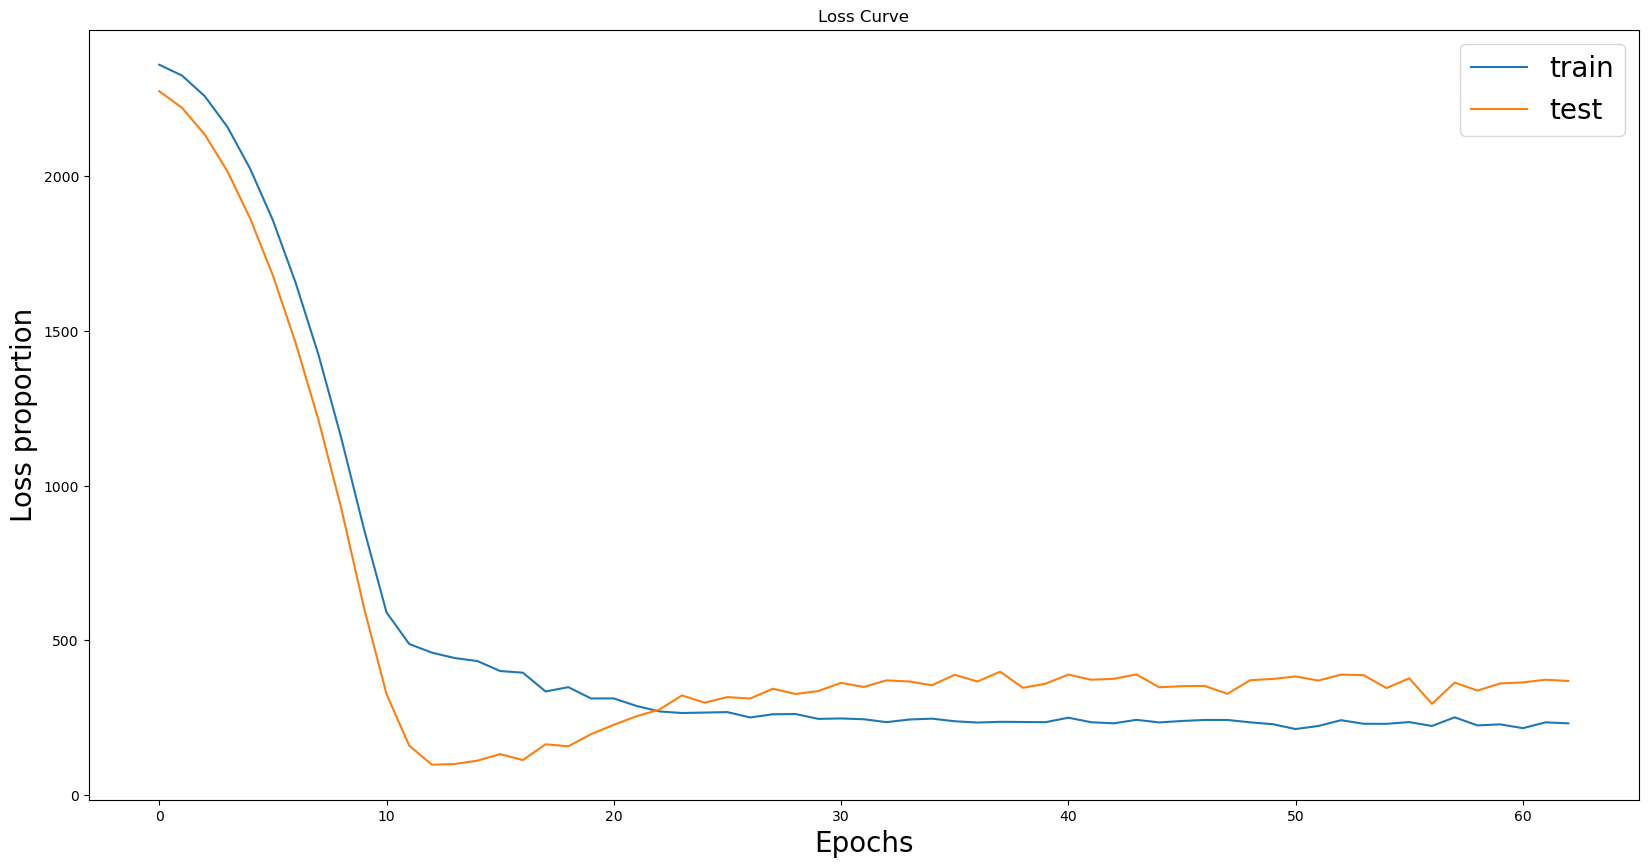

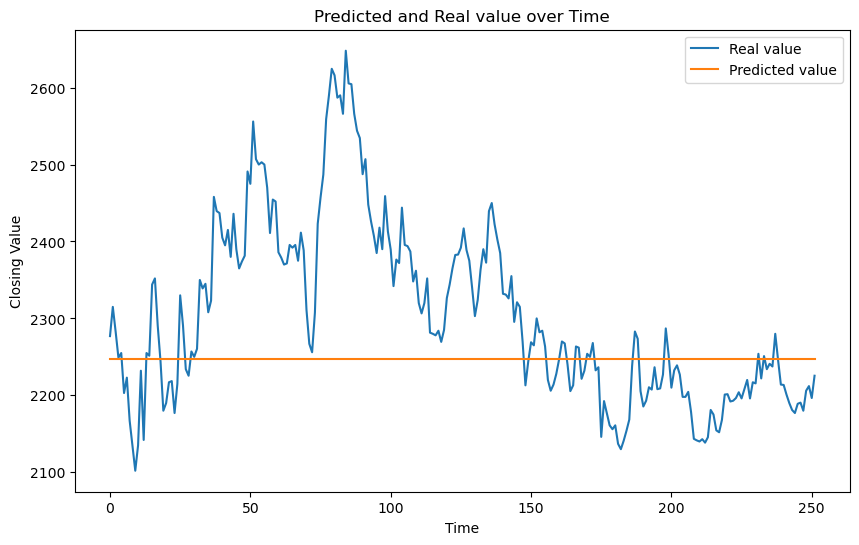

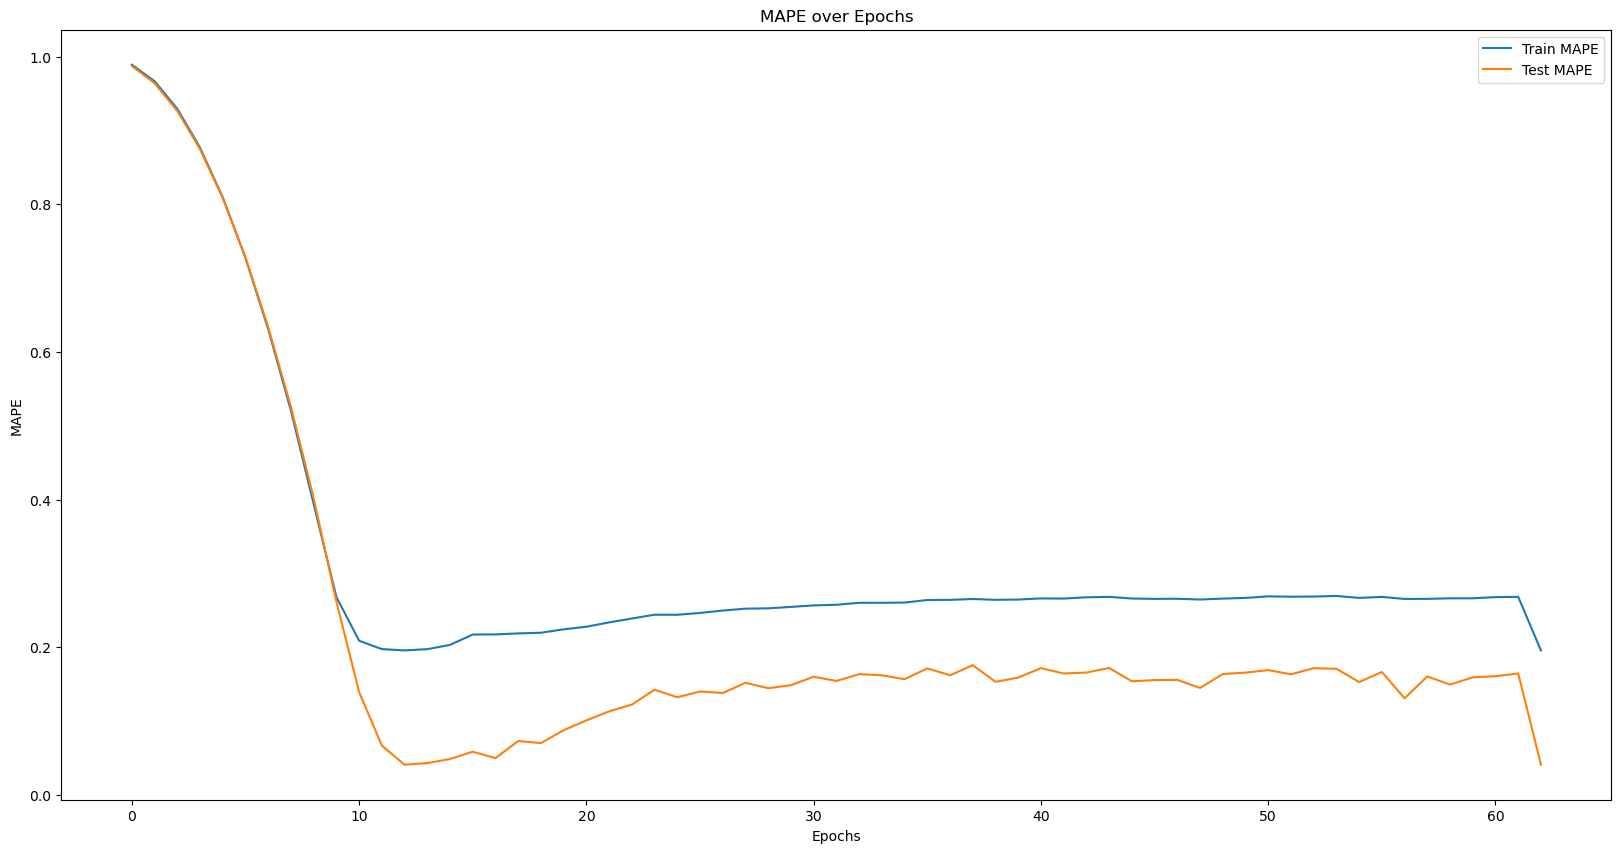

In [142]:
# Reshape for LSTM
#train_X = x_seq_train.values.reshape((x_seq_train.shape[0], 1, x_seq_train.shape[1]))
#test_X = x_seq_test.values.reshape((x_seq_test.shape[0], 1, x_seq_test.shape[1]))

run_lstm(x_seq_train, y_train_a, x_seq_test, y_test_a, lookback=6, drop_pro=0.3, epoch_count=150, learn_r=0.001)


## Hyper parameter tuning

In [127]:
def run_lstm_b(x_train, y_train, x_test, y_test, lookback, drop_pro, epoch_count, learn_r):
   
    # Convert x_train and x_test to numpy arrays and reshape
    train_X = x_train.values.reshape((x_train.shape[0], 1, -1)) 
    test_X = x_test.values.reshape((x_test.shape[0], 1, -1))

    # Ensure y_train and y_test are numpy arrays
    train_y = np.array(y_train)
    test_y = np.array(y_test)   

    model = Sequential()
    
    model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))

    model.add(Dropout(drop_pro))
    model.add(Dense(50, activation='relu'))


    model.add(Dense(1))
    optimizer = Adam(learning_rate=learn_r)
    model.compile(loss='mae', optimizer=optimizer)
  

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=50, verbose=1,         
                               restore_best_weights=True)  


    early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True)

    mape_history = MAPEHistory(train_data=[train_X, train_y], validation_data=[test_X, test_y])

    history = model.fit(train_X, train_y, epochs=epoch_count, batch_size=10, validation_data=(test_X, test_y), 
    verbose=0, shuffle=False, callbacks=[early_stopping, mape_history])
    #mape = calculate_mape(test_y, predicted_values)
    
    predicted_values = model.predict(test_X)
    average_test_mape = np.mean(mape_history.mape_test)


    return {'average_test_mape': average_test_mape}

In [128]:
def bayesian_optimization_function(drop_pro, learn_r):
    
    result = run_lstm_b(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, lookback=6, 
                        drop_pro=drop_pro, epoch_count=100, 
                        learn_r=learn_r)
    
    return -result['average_test_mape']  


In [143]:
# 实例化贝叶斯优化器
optimizer = BayesianOptimization(
    f=bayesian_optimization_function,
    pbounds={'drop_pro': (0.1, 0.5), 'learn_r': (1e-5, 1e-2)},
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=50)

|   iter    |  target   | drop_pro  |  learn_r  |
-------------------------------------------------
8/8 [==============================] - 0s 477us/step
Restoring model weights from the end of the best epoch: 2.
8/8 [==============================] - 0s 546us/step
Epoch 52: early stopping
8/8 [==============================] - 0s 487us/step
| 1         | -0.2458   | 0.2668    | 0.007206  |
17/17 [==============================] - 0s 389us/step


8/8 [==============================] - 0s 483us/step
Restoring model weights from the end of the best epoch: 4.
8/8 [==============================] - 0s 453us/step
Epoch 54: early stopping
8/8 [==============================] - 0s 471us/step
| 2         | -0.2226   | 0.1       | 0.00303   |
8/8 [==============================] - 0s 488us/step


8/8 [==============================] - 0s 468us/step
Restoring model weights from the end of the best epoch: 16.
8/8 [==============================] - 0s 483us/step
Epoch 66: early stopping
8/8 [==============================] - 0s 521us/step
| 3         | -0.2009   | 0.1587    | 0.0009325 |
17/17 [==============================] - 0s 394us/step


8/8 [==============================] - 0s 440us/step
Restoring model weights from the end of the best epoch: 4.
8/8 [==============================] - 0s 450us/step
Epoch 54: early stopping
8/8 [==============================] - 0s 502us/step
| 4         | -0.2318   | 0.1745    | 0.003462  |
8/8 [==============================] - 0s 456us/step


8/8 [==============================] - 0s 499us/step
| 5         | -0.2518   | 0.2587    | 0.005393  |
17/17 [==============================] - 0s 388us/step


8/8 [==============================] - 0s 439us/step
Restoring model weights from the end of the best epoch: 2.
8/8 [==============================] - 0s 442us/step
Epoch 52: early stopping
8/8 [==============================] - 0s 524us/step
| 6         | -0.2557   | 0.2677    | 0.006855  |
8/8 [==============================] - 0s 480us/step


8/8 [==============================] - 0s 488us/step
Restoring model weights from the end of the best epoch: 40.
8/8 [==============================] - 0s 494us/step
Epoch 90: early stopping
8/8 [==============================] - 0s 486us/step
| 7         | -0.2525   | 0.1818    | 0.008782  |
17/17 [==============================] - 0s 386us/step


8/8 [==============================] - 0s 442us/step
Restoring model weights from the end of the best epoch: 2.
8/8 [==============================] - 0s 457us/step
Epoch 52: early stopping
8/8 [==============================] - 0s 563us/step
| 8         | -0.2587   | 0.111     | 0.006708  |
8/8 [==============================] - 0s 472us/step
Restoring model weights from the end of the best epoch: 4.
8/8 [==============================] - 0s 470us/step
Epoch 54: early stopping
8/8 [==============================] - 0s 485us/step
| 9         | -0.2583   | 0.2669    | 0.005591  |
8/8 [==============================] - 0s 464us/step


8/8 [==============================] - 0s 435us/step
Restoring model weights from the end of the best epoch: 7.
8/8 [==============================] - 0s 451us/step
Epoch 57: early stopping
8/8 [==============================] - 0s 556us/step
| 10        | -0.2066   | 0.1562    | 0.001989  |
17/17 [==============================] - 0s 389us/step


8/8 [==============================] - 0s 424us/step
Restoring model weights from the end of the best epoch: 3.
8/8 [==============================] - 0s 437us/step
Epoch 53: early stopping
8/8 [==============================] - 0s 530us/step
| 11        | -0.2405   | 0.1594    | 0.004305  |
8/8 [==============================] - 0s 437us/step


8/8 [==============================] - 0s 448us/step
| 12        | -0.4465   | 0.1559    | 0.0001835 |
17/17 [==============================] - 0s 394us/step


8/8 [==============================] - 0s 439us/step
Restoring model weights from the end of the best epoch: 4.
8/8 [==============================] - 0s 416us/step
Epoch 54: early stopping
8/8 [==============================] - 0s 512us/step
| 13        | -0.2222   | 0.1       | 0.003583  |
8/8 [==============================] - 0s 436us/step


8/8 [==============================] - 0s 450us/step
Restoring model weights from the end of the best epoch: 5.
8/8 [==============================] - 0s 440us/step
Epoch 55: early stopping
8/8 [==============================] - 0s 494us/step
| 14        | -0.2245   | 0.1561    | 0.003067  |
8/8 [==============================] - 0s 441us/step
Restoring model weights from the end of the best epoch: 5.
8/8 [==============================] - 0s 428us/step
Epoch 55: early stopping
8/8 [==============================] - 0s 414us/step
| 15        | -0.2261   | 0.1574    | 0.00239   |
17/17 [==============================] - 0s 381us/step


8/8 [==============================] - 0s 446us/step


8/8 [==============================] - 0s 450us/step
| 16        | -0.2018   | 0.1745    | 0.003373  |
8/8 [==============================] - 0s 446us/step
Restoring model weights from the end of the best epoch: 4.
8/8 [==============================] - 0s 431us/step
Epoch 54: early stopping


8/8 [==============================] - 0s 440us/step
| 17        | -0.2222   | 0.1562    | 0.003032  |
8/8 [==============================] - 0s 470us/step
Restoring model weights from the end of the best epoch: 5.
8/8 [==============================] - 0s 460us/step
Epoch 55: early stopping
8/8 [==============================] - 0s 522us/step
| 18        | -0.2201   | 0.1559    | 0.002377  |
17/17 [==============================] - 0s 388us/step


8/8 [==============================] - 0s 457us/step
Restoring model weights from the end of the best epoch: 4.
8/8 [==============================] - 0s 478us/step
Epoch 54: early stopping
8/8 [==============================] - 0s 478us/step
| 19        | -0.2151   | 0.1002    | 0.003058  |
8/8 [==============================] - 0s 484us/step


8/8 [==============================] - 0s 435us/step
Restoring model weights from the end of the best epoch: 5.
8/8 [==============================] - 0s 524us/step
Epoch 55: early stopping
8/8 [==============================] - 0s 489us/step
| 20        | -0.2251   | 0.1741    | 0.002977  |
8/8 [==============================] - 0s 479us/step
Restoring model weights from the end of the best epoch: 6.


8/8 [==============================] - 0s 502us/step
Epoch 56: early stopping
8/8 [==============================] - 0s 540us/step
| 21        | -0.2161   | 0.1746    | 0.002907  |
8/8 [==============================] - 0s 499us/step
Restoring model weights from the end of the best epoch: 6.
8/8 [==============================] - 0s 482us/step
Epoch 56: early stopping
8/8 [==============================] - 0s 485us/step
| 22        | -0.2148   | 0.156     | 0.002204  |
8/8 [==============================] - 0s 502us/step


8/8 [==============================] - 0s 439us/step
Restoring model weights from the end of the best epoch: 4.
8/8 [==============================] - 0s 482us/step
Epoch 54: early stopping
8/8 [==============================] - 0s 493us/step
| 23        | -0.2197   | 0.1562    | 0.003045  |
17/17 [==============================] - 0s 387us/step


8/8 [==============================] - 0s 455us/step
Restoring model weights from the end of the best epoch: 10.
8/8 [==============================] - 0s 500us/step
Epoch 60: early stopping
8/8 [==============================] - 0s 484us/step
| 24        | -0.2025   | 0.1583    | 0.001385  |
8/8 [==============================] - 0s 467us/step


8/8 [==============================] - 0s 434us/step
Restoring model weights from the end of the best epoch: 10.
8/8 [==============================] - 0s 462us/step
Epoch 60: early stopping
8/8 [==============================] - 0s 565us/step
| 25        | -0.202    | 0.1589    | 0.001356  |
8/8 [==============================] - 0s 471us/step
Restoring model weights from the end of the best epoch: 6.
8/8 [==============================] - 0s 472us/step
Epoch 56: early stopping
8/8 [==============================] - 0s 484us/step
| 26        | -0.2083   | 0.1584    | 0.002046  |
17/17 [==============================] - 0s 429us/step


8/8 [==============================] - 0s 465us/step
Restoring model weights from the end of the best epoch: 5.
8/8 [==============================] - 0s 457us/step
Epoch 55: early stopping
8/8 [==============================] - 0s 478us/step
| 27        | -0.2355   | 0.1565    | 0.003667  |
8/8 [==============================] - 0s 479us/step


8/8 [==============================] - 0s 492us/step
Restoring model weights from the end of the best epoch: 18.
8/8 [==============================] - 0s 463us/step
Epoch 68: early stopping
8/8 [==============================] - 0s 578us/step
| 28        | -0.2093   | 0.1581    | 0.0008081 |
17/17 [==============================] - 0s 390us/step


8/8 [==============================] - 0s 463us/step
Restoring model weights from the end of the best epoch: 4.
8/8 [==============================] - 0s 492us/step
Epoch 54: early stopping
8/8 [==============================] - 0s 466us/step
| 29        | -0.2207   | 0.1585    | 0.002852  |
8/8 [==============================] - 0s 511us/step


8/8 [==============================] - 0s 459us/step
Restoring model weights from the end of the best epoch: 6.
8/8 [==============================] - 0s 491us/step
Epoch 56: early stopping
8/8 [==============================] - 0s 490us/step
| 30        | -0.2019   | 0.1591    | 0.002104  |
8/8 [==============================] - 0s 492us/step
Restoring model weights from the end of the best epoch: 5.
8/8 [==============================] - 0s 485us/step
Epoch 55: early stopping
8/8 [==============================] - 0s 491us/step
| 31        | -0.2248   | 0.1594    | 0.002676  |
17/17 [==============================] - 0s 385us/step


8/8 [==============================] - 0s 496us/step
Restoring model weights from the end of the best epoch: 8.
8/8 [==============================] - 0s 505us/step
Epoch 58: early stopping
8/8 [==============================] - 0s 520us/step
| 32        | -0.2046   | 0.1598    | 0.001673  |
8/8 [==============================] - 0s 467us/step


8/8 [==============================] - 0s 461us/step
Restoring model weights from the end of the best epoch: 15.
8/8 [==============================] - 0s 465us/step
Epoch 65: early stopping
8/8 [==============================] - 0s 488us/step
| 33        | -0.1994   | 0.1596    | 0.0008606 |
17/17 [==============================] - 0s 459us/step


8/8 [==============================] - 0s 473us/step
Restoring model weights from the end of the best epoch: 16.
8/8 [==============================] - 0s 484us/step
Epoch 66: early stopping
8/8 [==============================] - 0s 497us/step
| 34        | -0.201    | 0.1603    | 0.0008484 |
8/8 [==============================] - 0s 455us/step


8/8 [==============================] - 0s 451us/step
| 35        | -0.8764   | 0.1595    | 7.722e-05 |
17/17 [==============================] - 0s 387us/step


8/8 [==============================] - 0s 501us/step
Restoring model weights from the end of the best epoch: 8.
8/8 [==============================] - 0s 3ms/step
Epoch 58: early stopping
8/8 [==============================] - 0s 591us/step
| 36        | -0.198    | 0.1611    | 0.001613  |
8/8 [==============================] - 0s 457us/step


8/8 [==============================] - 0s 446us/step
Restoring model weights from the end of the best epoch: 7.
8/8 [==============================] - 0s 496us/step
Epoch 57: early stopping
8/8 [==============================] - 0s 513us/step
| 37        | -0.2023   | 0.1622    | 0.001741  |
17/17 [==============================] - 0s 392us/step


8/8 [==============================] - 0s 475us/step
Restoring model weights from the end of the best epoch: 19.
8/8 [==============================] - 0s 486us/step
Epoch 69: early stopping
8/8 [==============================] - 0s 508us/step
| 38        | -0.2072   | 0.1617    | 0.0007156 |
8/8 [==============================] - 0s 511us/step


8/8 [==============================] - 0s 426us/step
Restoring model weights from the end of the best epoch: 16.
8/8 [==============================] - 0s 498us/step
Epoch 66: early stopping
8/8 [==============================] - 0s 459us/step
| 39        | -0.1998   | 0.163     | 0.0007813 |
8/8 [==============================] - 0s 486us/step
Restoring model weights from the end of the best epoch: 6.
8/8 [==============================] - 0s 490us/step
Epoch 56: early stopping
8/8 [==============================] - 0s 489us/step
| 40        | -0.2199   | 0.1634    | 0.002266  |


8/8 [==============================] - 0s 483us/step
Restoring model weights from the end of the best epoch: 5.
8/8 [==============================] - 0s 512us/step
Epoch 55: early stopping
8/8 [==============================] - 0s 483us/step
| 41        | -0.2125   | 0.1619    | 0.002755  |
17/17 [==============================] - 0s 386us/step


8/8 [==============================] - 0s 458us/step
Restoring model weights from the end of the best epoch: 18.
8/8 [==============================] - 0s 467us/step
Epoch 68: early stopping
8/8 [==============================] - 0s 545us/step
| 42        | -0.2083   | 0.1642    | 0.0008805 |
8/8 [==============================] - 0s 468us/step


17/17 [==============================] - 0s 397us/step


8/8 [==============================] - 0s 532us/step
| 43        | -0.1864   | 0.1014    | 0.00308   |
8/8 [==============================] - 0s 471us/step
Restoring model weights from the end of the best epoch: 4.
8/8 [==============================] - 0s 495us/step
Epoch 54: early stopping
8/8 [==============================] - 0s 475us/step
| 44        | -0.2453   | 0.1014    | 0.00402   |
8/8 [==============================] - 0s 495us/step


8/8 [==============================] - 0s 482us/step
Restoring model weights from the end of the best epoch: 5.
8/8 [==============================] - 0s 475us/step
Epoch 55: early stopping
8/8 [==============================] - 0s 476us/step
| 45        | -0.2191   | 0.1017    | 0.00228   |
17/17 [==============================] - 0s 403us/step


8/8 [==============================] - 0s 514us/step
| 46        | -0.2065   | 0.1025    | 0.003345  |
8/8 [==============================] - 0s 485us/step


8/8 [==============================] - 0s 491us/step
Restoring model weights from the end of the best epoch: 5.
8/8 [==============================] - 0s 478us/step
Epoch 55: early stopping
8/8 [==============================] - 0s 531us/step
| 47        | -0.2238   | 0.1609    | 0.00294   |
17/17 [==============================] - 0s 389us/step


8/8 [==============================] - 0s 458us/step
Restoring model weights from the end of the best epoch: 5.
8/8 [==============================] - 0s 479us/step
Epoch 55: early stopping
8/8 [==============================] - 0s 518us/step
| 48        | -0.2235   | 0.1029    | 0.002311  |
8/8 [==============================] - 0s 507us/step


8/8 [==============================] - 0s 485us/step
Restoring model weights from the end of the best epoch: 7.
8/8 [==============================] - 0s 509us/step
Epoch 57: early stopping
8/8 [==============================] - 0s 535us/step
| 49        | -0.2106   | 0.1005    | 0.001992  |
17/17 [==============================] - 0s 388us/step


8/8 [==============================] - 0s 470us/step
| 50        | -0.9864   | 0.1627    | 2.161e-05 |
8/8 [==============================] - 0s 493us/step


8/8 [==============================] - 0s 474us/step
Restoring model weights from the end of the best epoch: 7.
8/8 [==============================] - 0s 533us/step
Epoch 57: early stopping
8/8 [==============================] - 0s 486us/step
| 51        | -0.2027   | 0.1633    | 0.001559  |
8/8 [==============================] - 0s 466us/step
Restoring model weights from the end of the best epoch: 5.
8/8 [==============================] - 0s 473us/step
Epoch 55: early stopping


8/8 [==============================] - 0s 485us/step
| 52        | -0.2452   | 0.1629    | 0.003483  |
8/8 [==============================] - 0s 472us/step
Restoring model weights from the end of the best epoch: 7.
8/8 [==============================] - 0s 478us/step
Epoch 57: early stopping
8/8 [==============================] - 0s 497us/step
| 53        | -0.2061   | 0.1645    | 0.001899  |
17/17 [==============================] - 0s 383us/step


8/8 [==============================] - 0s 485us/step


8/8 [==============================] - 0s 472us/step
| 54        | -0.1875   | 0.1645    | 0.003074  |
8/8 [==============================] - 0s 496us/step
Restoring model weights from the end of the best epoch: 5.
8/8 [==============================] - 0s 465us/step
Epoch 55: early stopping
8/8 [==============================] - 0s 483us/step
| 55        | -0.2358   | 0.1655    | 0.002818  |
17/17 [==============================] - 0s 381us/step


8/8 [==============================] - 0s 487us/step
Restoring model weights from the end of the best epoch: 3.
8/8 [==============================] - 0s 514us/step
Epoch 53: early stopping
8/8 [==============================] - 0s 496us/step
| 56        | -0.2342   | 0.1643    | 0.004452  |
8/8 [==============================] - 0s 494us/step


8/8 [==============================] - 0s 488us/step
Restoring model weights from the end of the best epoch: 19.
8/8 [==============================] - 0s 478us/step
Epoch 69: early stopping
8/8 [==============================] - 0s 584us/step
| 57        | -0.2088   | 0.1655    | 0.0007015 |
17/17 [==============================] - 0s 395us/step


8/8 [==============================] - 0s 453us/step
Restoring model weights from the end of the best epoch: 9.
8/8 [==============================] - 0s 500us/step
Epoch 59: early stopping
8/8 [==============================] - 0s 496us/step
| 58        | -0.2022   | 0.1664    | 0.001419  |
8/8 [==============================] - 0s 475us/step


8/8 [==============================] - 0s 498us/step
Restoring model weights from the end of the best epoch: 11.
8/8 [==============================] - 0s 467us/step
Epoch 61: early stopping
8/8 [==============================] - 0s 506us/step
| 59        | -0.1957   | 0.1676    | 0.00113   |
17/17 [==============================] - 0s 412us/step


8/8 [==============================] - 0s 470us/step
| 60        | -0.9651   | 0.1664    | 3.539e-05 |


In [139]:
def random_search_lstm(x_seq_train, y_train_a, x_seq_test, y_test_a, 
                       hyperparameters, iterations, dataset_name_string):
    for i in range(iterations):
        
        lookback = random.choice(hyperparameters['lookback'])
        dropout_pro = random.choice(hyperparameters['dropout_pro'])
        epoch_count = random.choice(hyperparameters['epoch_counts'])
        learn_r = random.choice(hyperparameters['learn_r'])

        print(f"Iteration {i+1}/{iterations}:")
        print(f"Lookback Periods: {lookback}, Dropout proportion: {dropout_pro}, "
              f"Epochs: {epoch_count}, Learning Rate: {learn_r}")

        run_lstm(x_seq_train, y_train_a, x_seq_test, y_test_a, lookback=60, drop_pro=0.5, epoch_count=100, learn_r=0.01)

hyperparameters = {
    'lookback': [3, 4, 5],
    'dropout_pro': [0.4, 0.2, 0.3],
    'epoch_counts': [50, 100, 150],
    'learn_r': [0.001, 0.01, 0.1]
}

iterations = 20
dataset_name_string = "Example Dataset"


Iteration 1/20:
Lookback Periods: 5, Dropout proportion: 0.3, Epochs: 50, Learning Rate: 0.1
8/8 [==============================] - 0s 557us/step
Restoring model weights from the end of the best epoch: 16.
8/8 [==============================] - 0s 618us/step
Epoch 66: early stopping
8/8 [==============================] - 0s 550us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 563.2659301757812
Last epoch val_loss: 523.1731567382812
Average Test MAPE: 0.22794504927732867


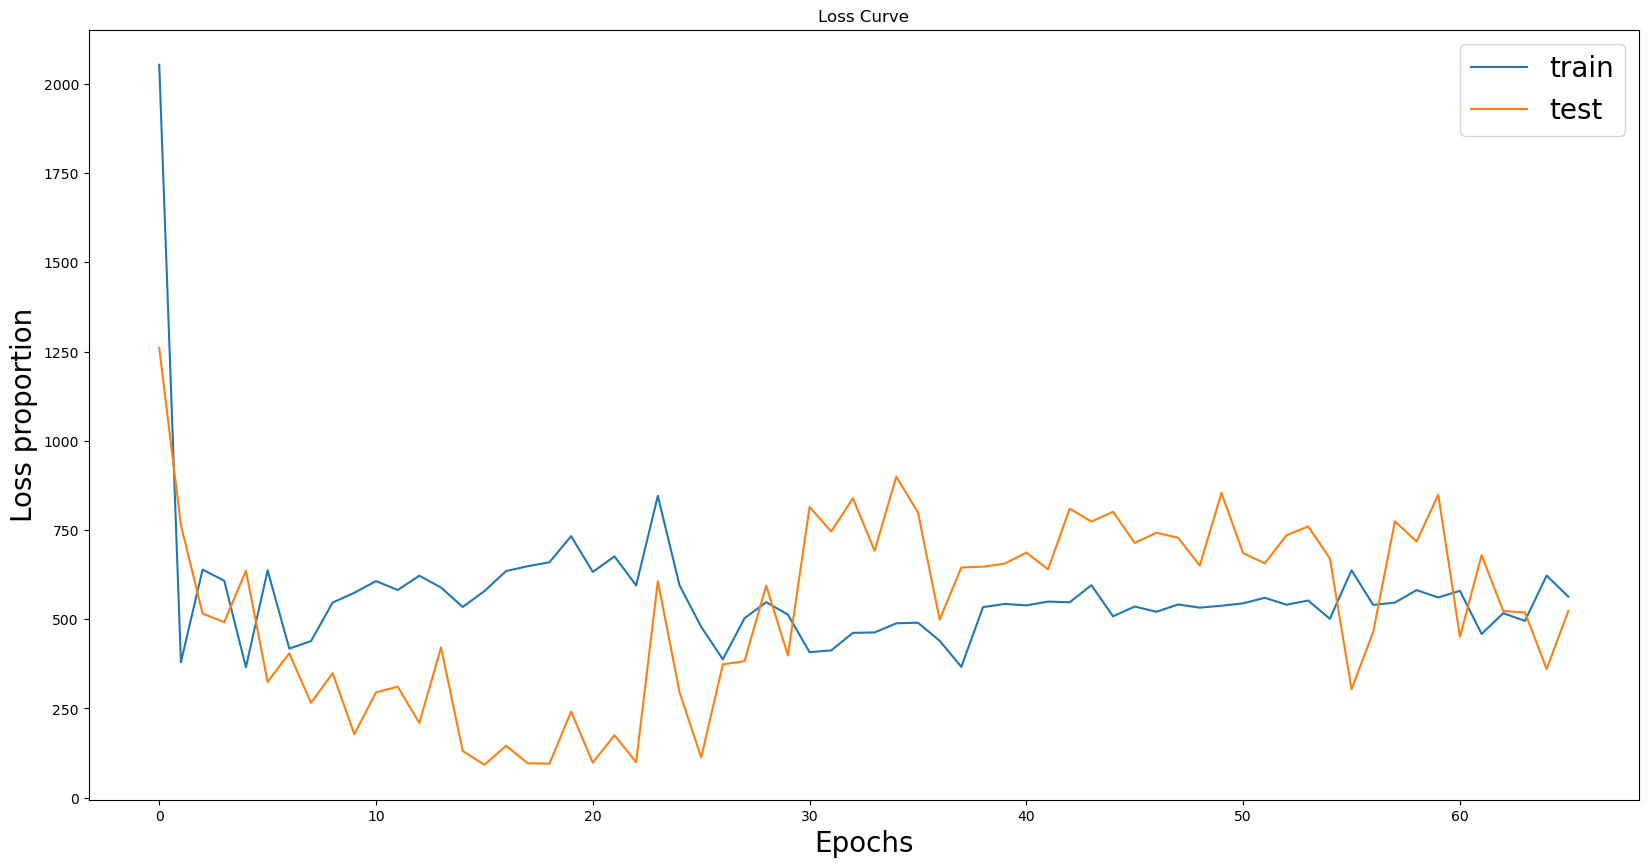

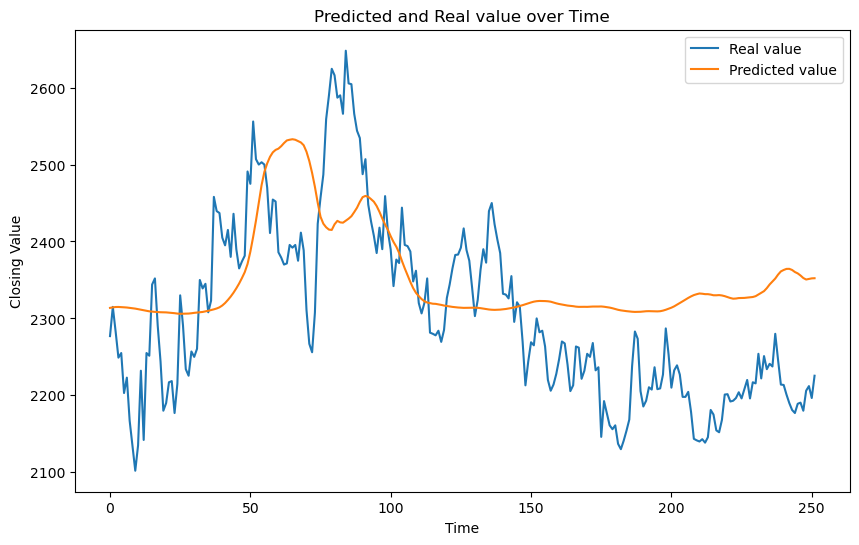

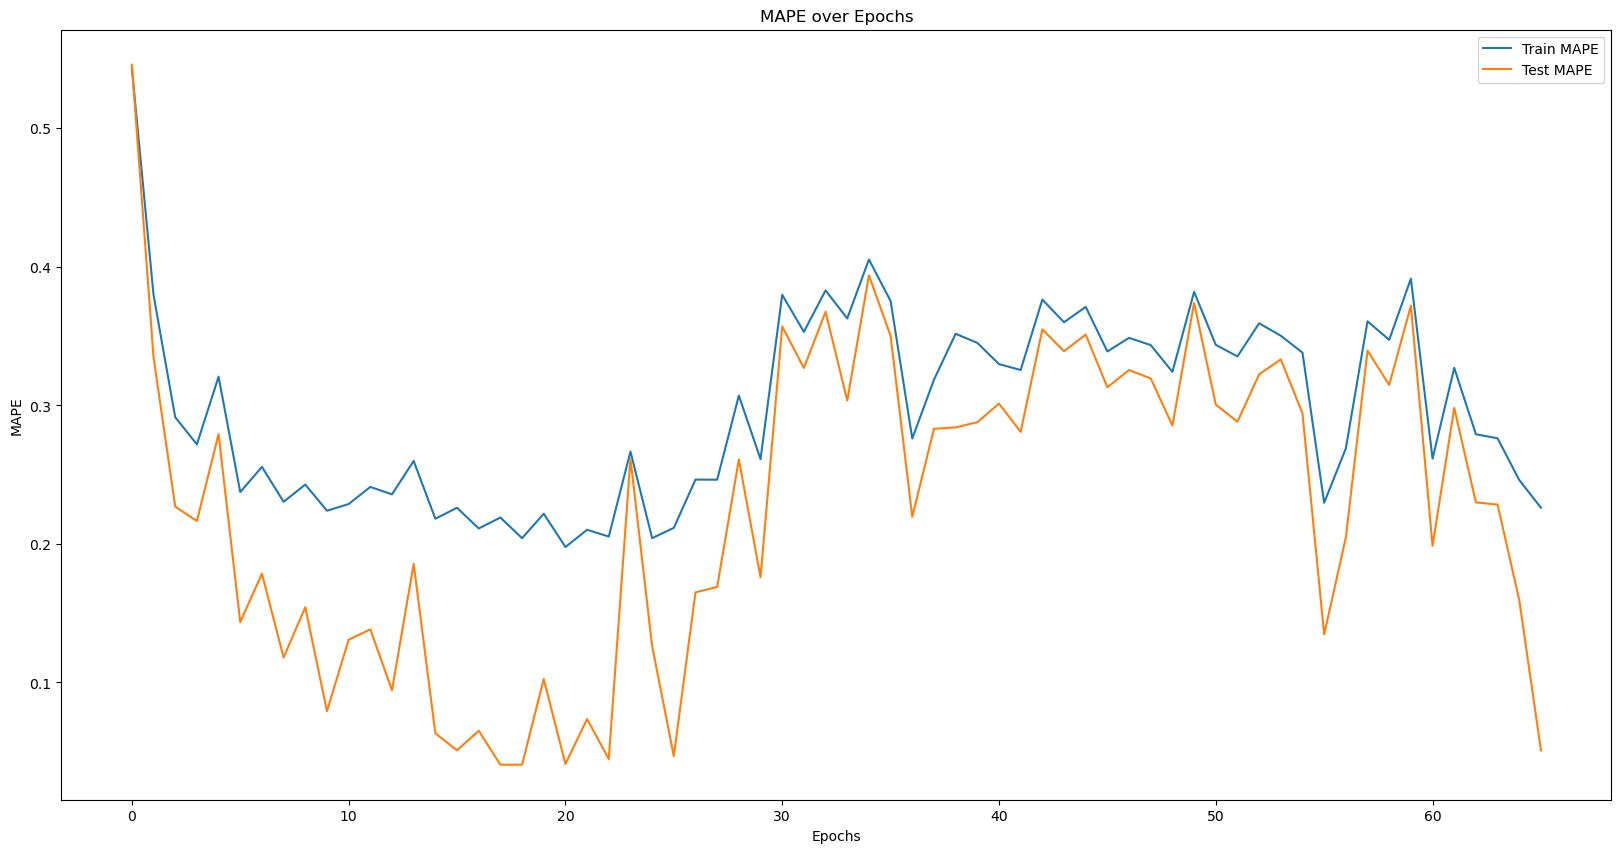

Iteration 2/20:
Lookback Periods: 3, Dropout proportion: 0.3, Epochs: 50, Learning Rate: 0.1
8/8 [==============================] - 0s 553us/step
Restoring model weights from the end of the best epoch: 25.


8/8 [==============================] - 0s 555us/step
Epoch 75: early stopping
8/8 [==============================] - 0s 584us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 567.8793334960938
Last epoch val_loss: 504.8556823730469
Average Test MAPE: 0.2141371002162467


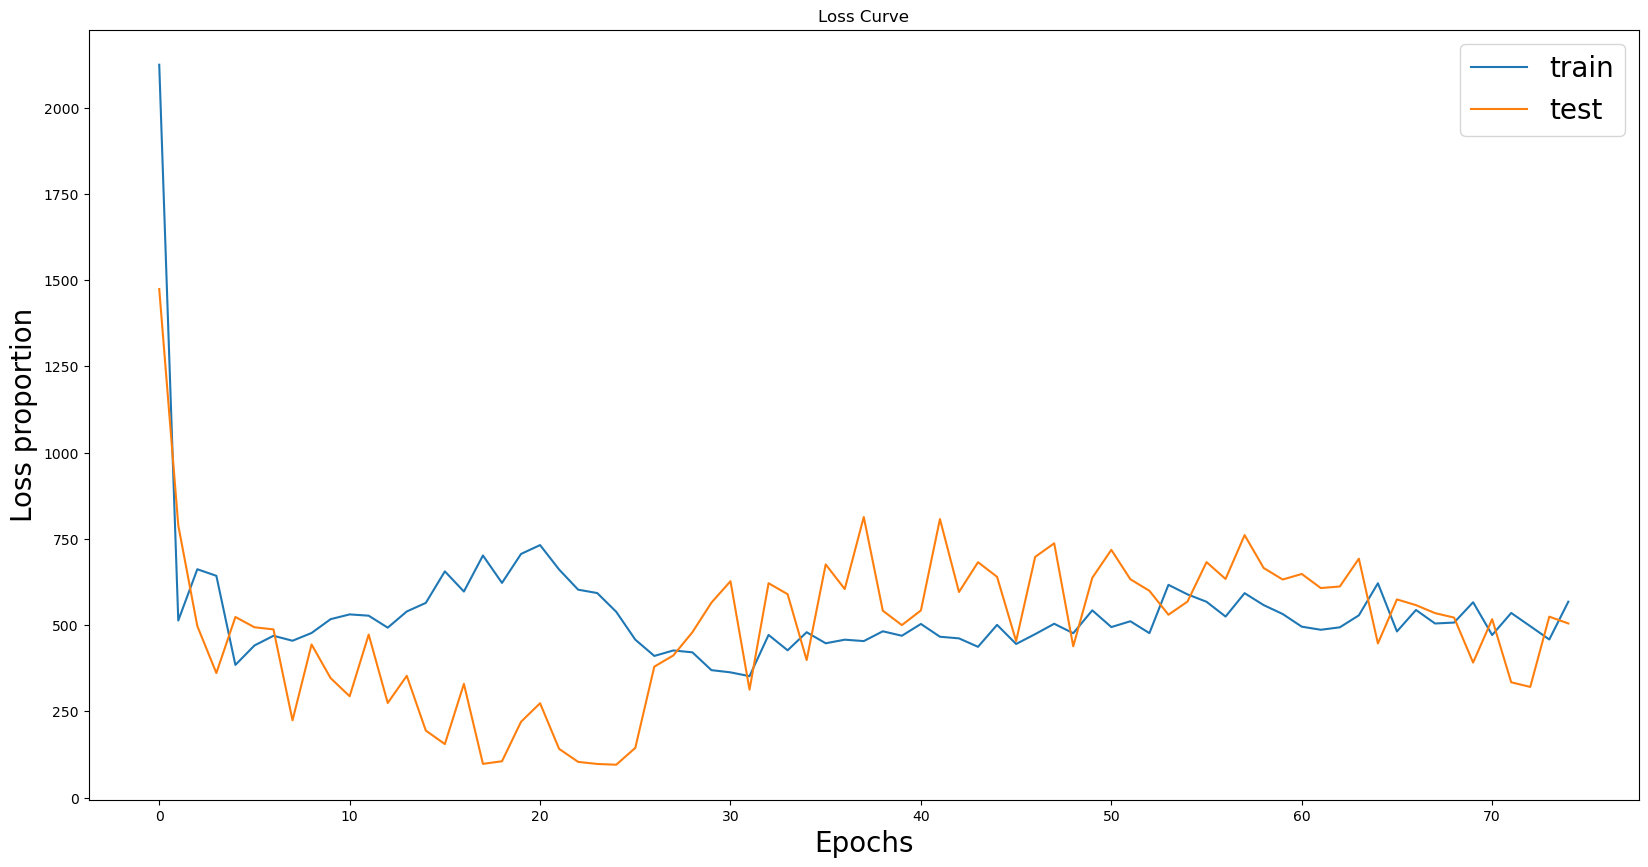

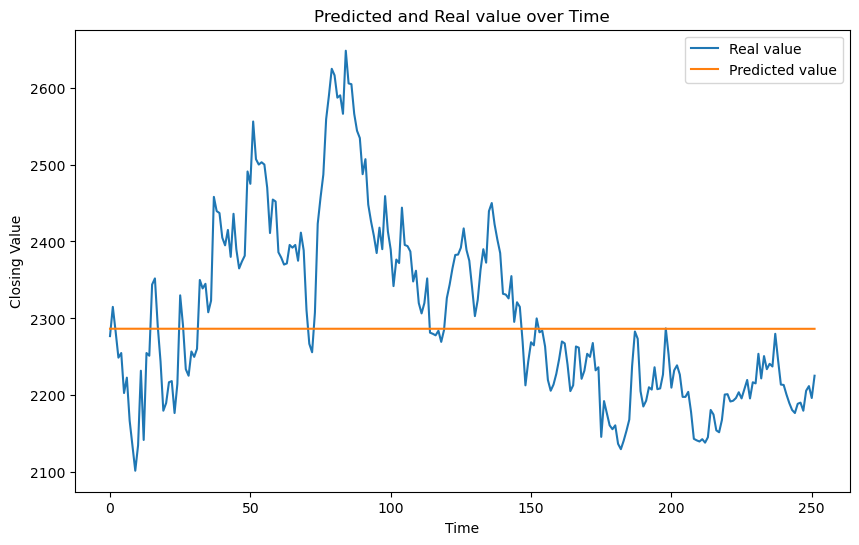

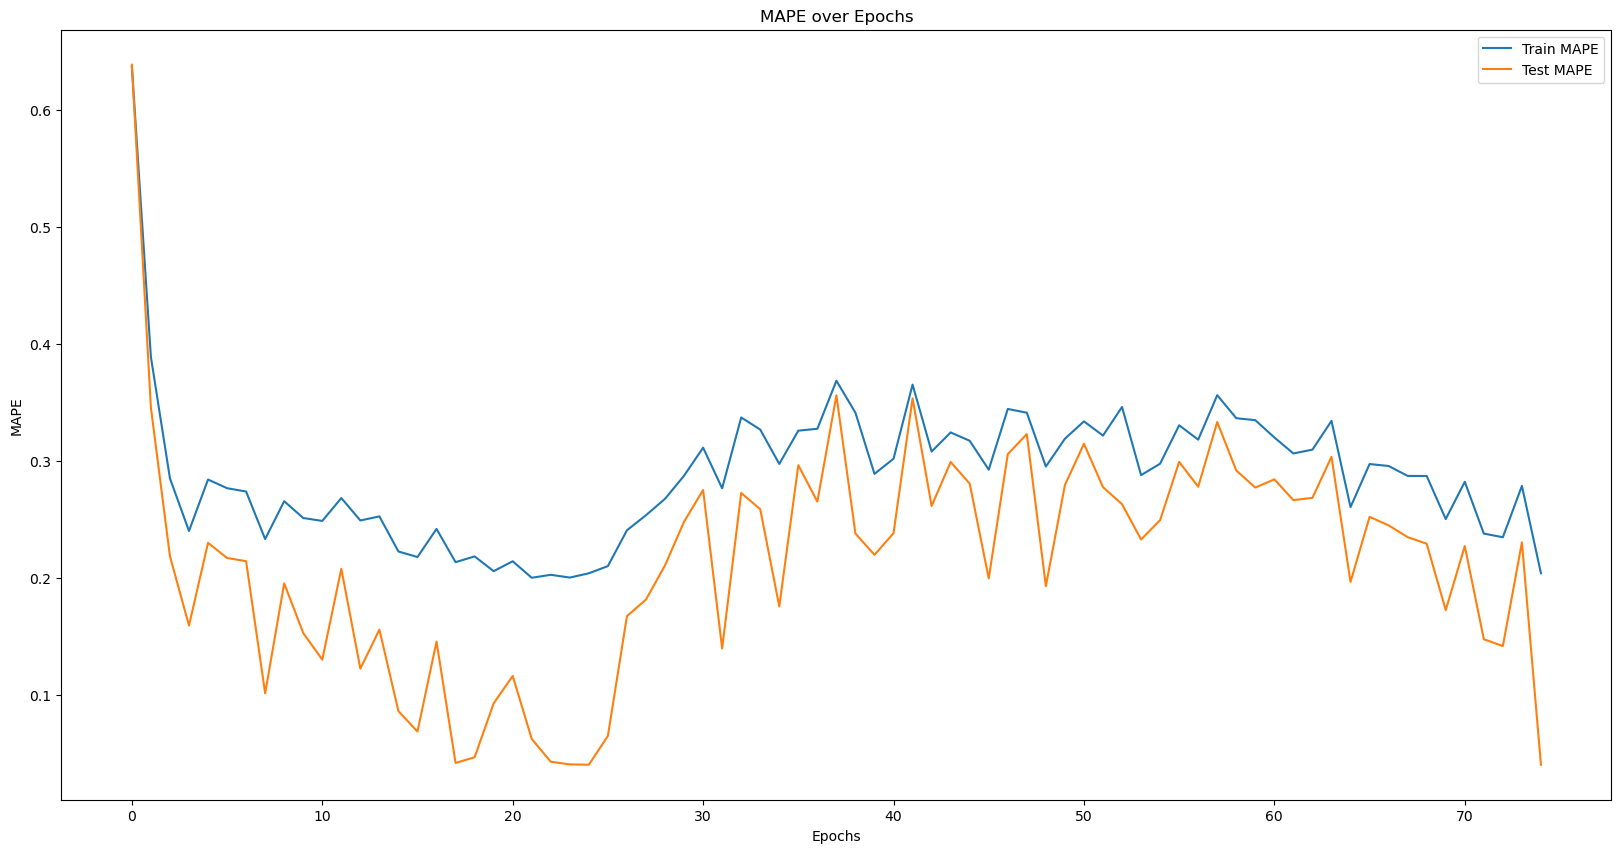

Iteration 3/20:
Lookback Periods: 5, Dropout proportion: 0.2, Epochs: 100, Learning Rate: 0.1
8/8 [==============================] - 0s 561us/step
Restoring model weights from the end of the best epoch: 18.
8/8 [==============================] - 0s 565us/step
Epoch 68: early stopping
8/8 [==============================] - 0s 552us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 542.2745971679688
Last epoch val_loss: 607.344482421875
Average Test MAPE: 0.2161154348935166


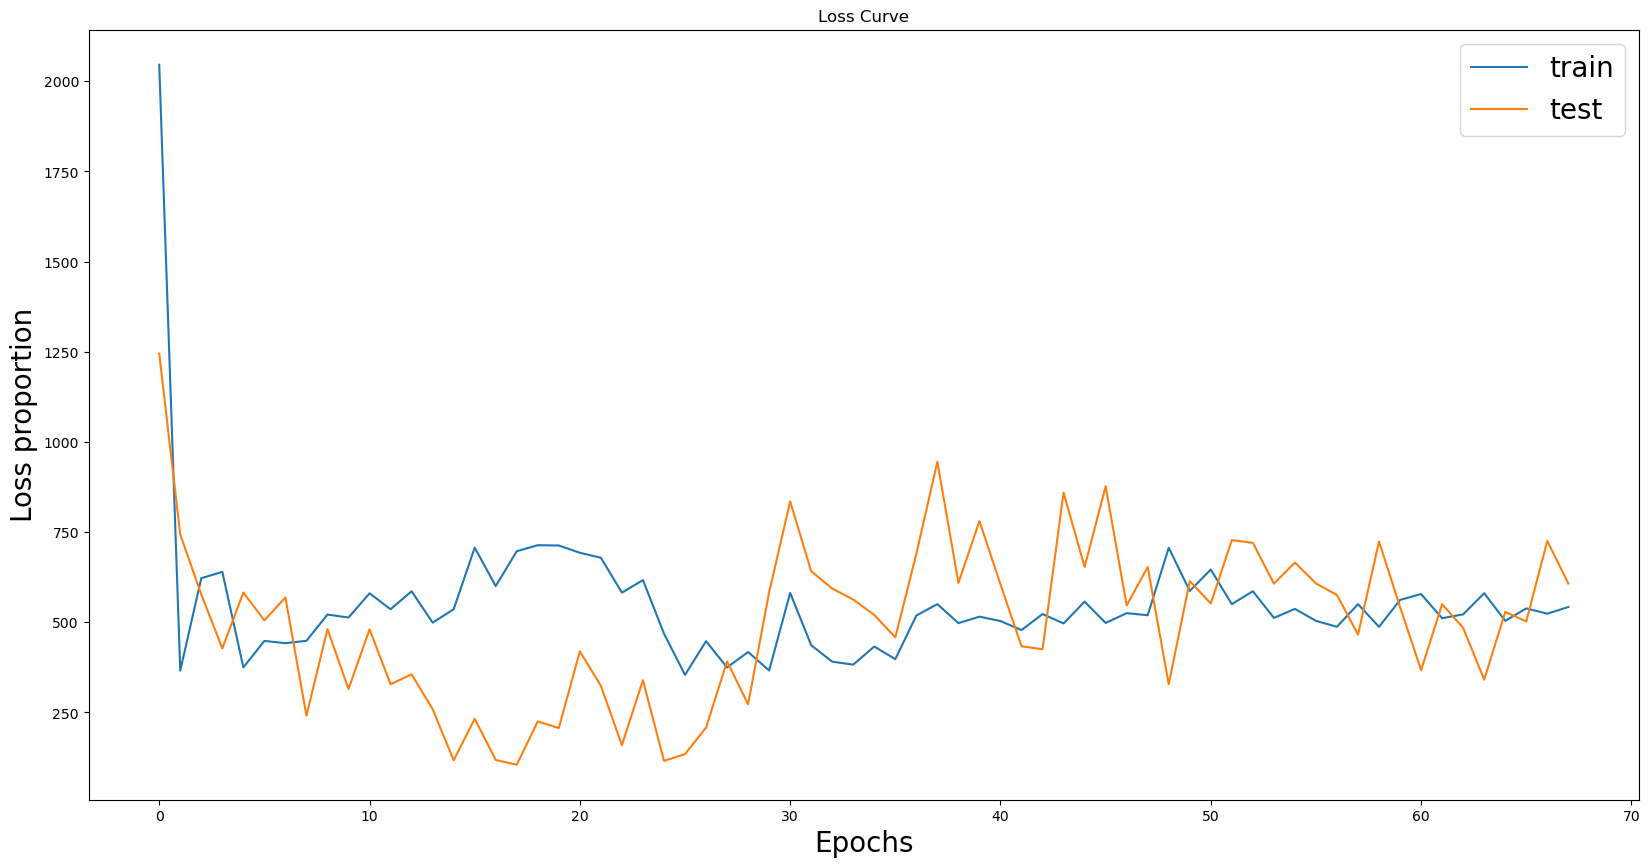

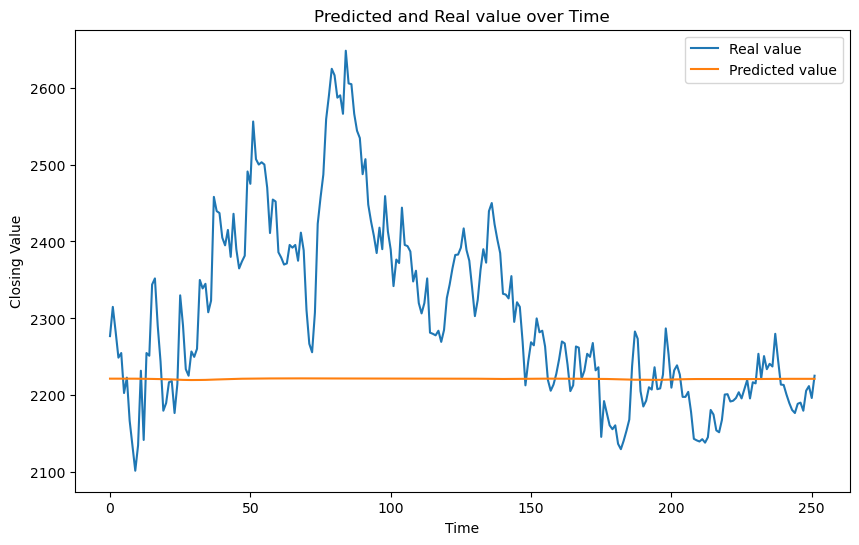

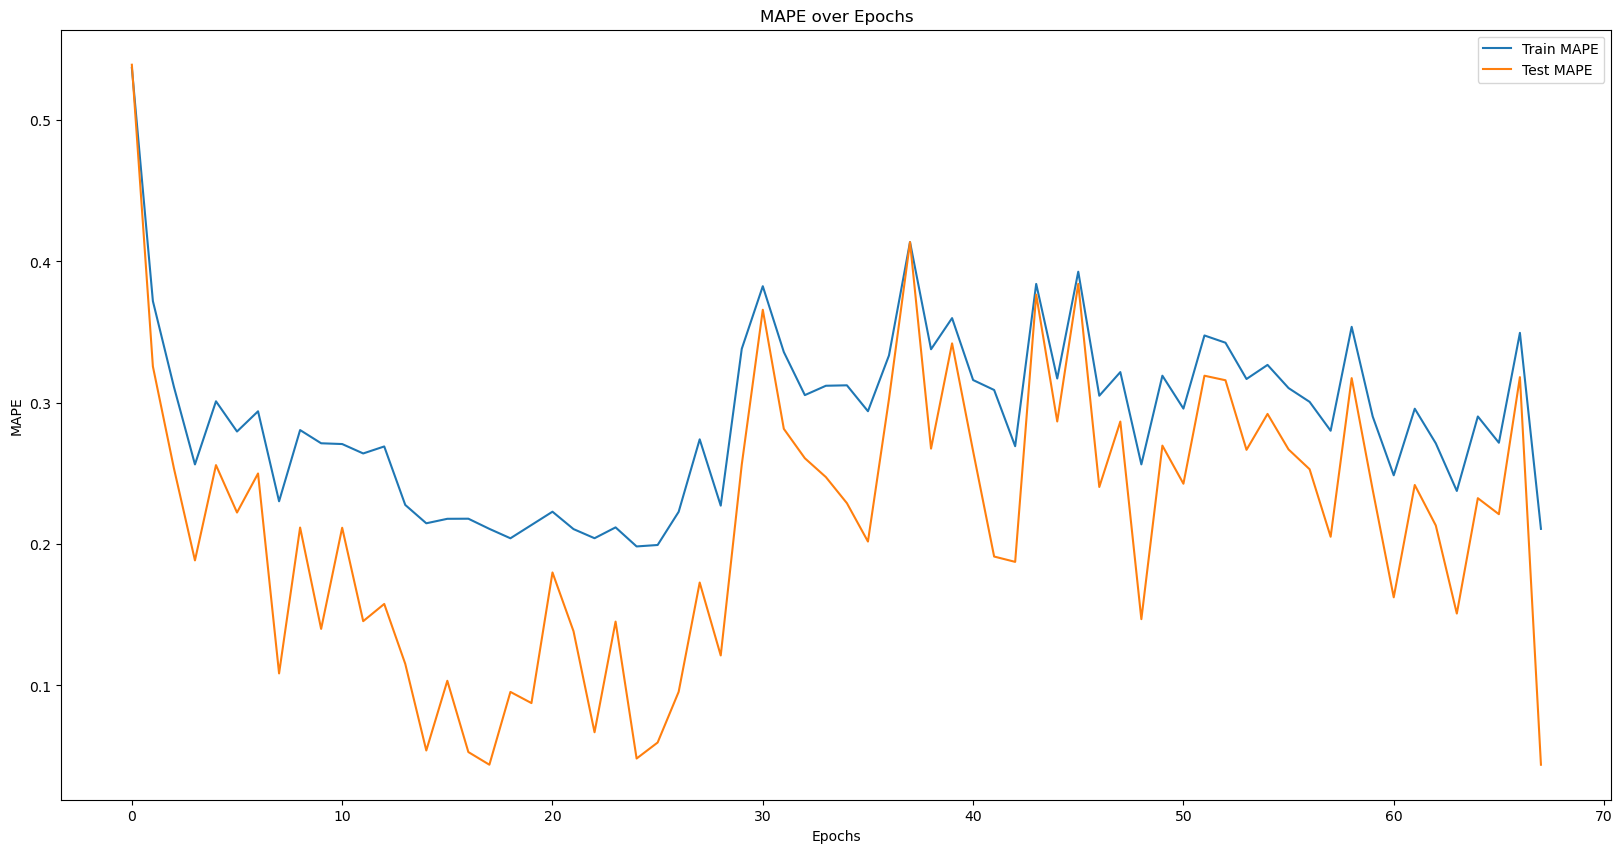

Iteration 4/20:
Lookback Periods: 4, Dropout proportion: 0.3, Epochs: 150, Learning Rate: 0.01
8/8 [==============================] - 0s 559us/step


Restoring model weights from the end of the best epoch: 26.
8/8 [==============================] - 0s 535us/step
Epoch 76: early stopping
8/8 [==============================] - 0s 553us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 428.2350158691406
Last epoch val_loss: 490.60064697265625
Average Test MAPE: 0.2404764521142906


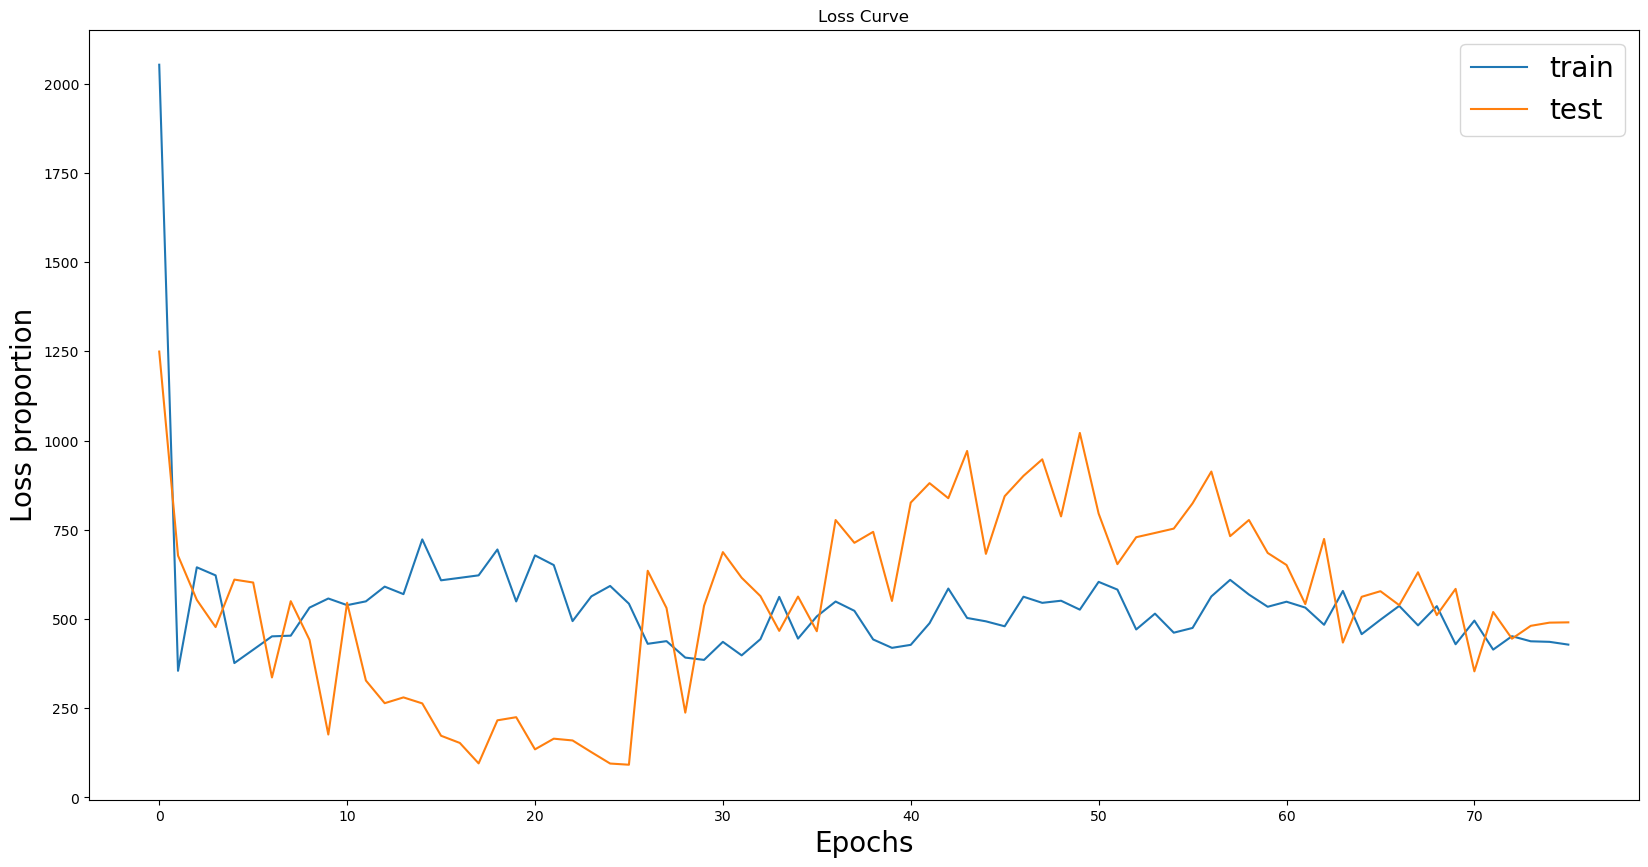

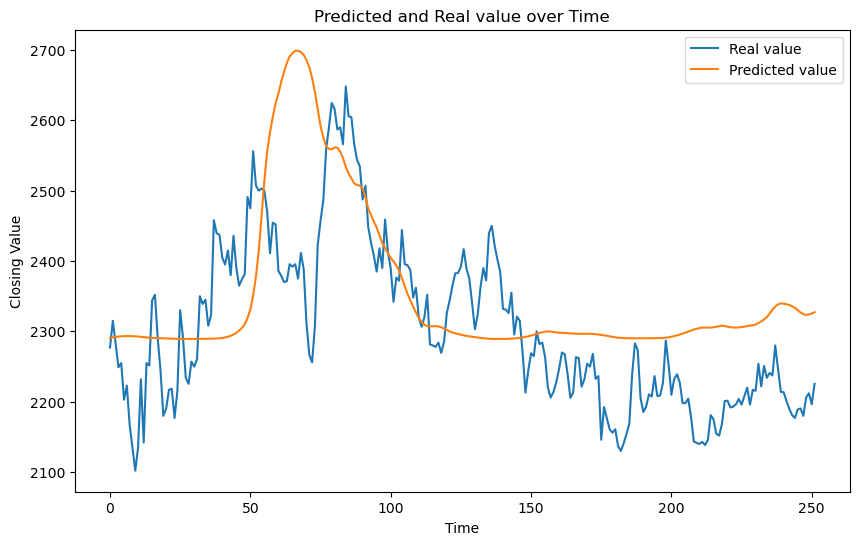

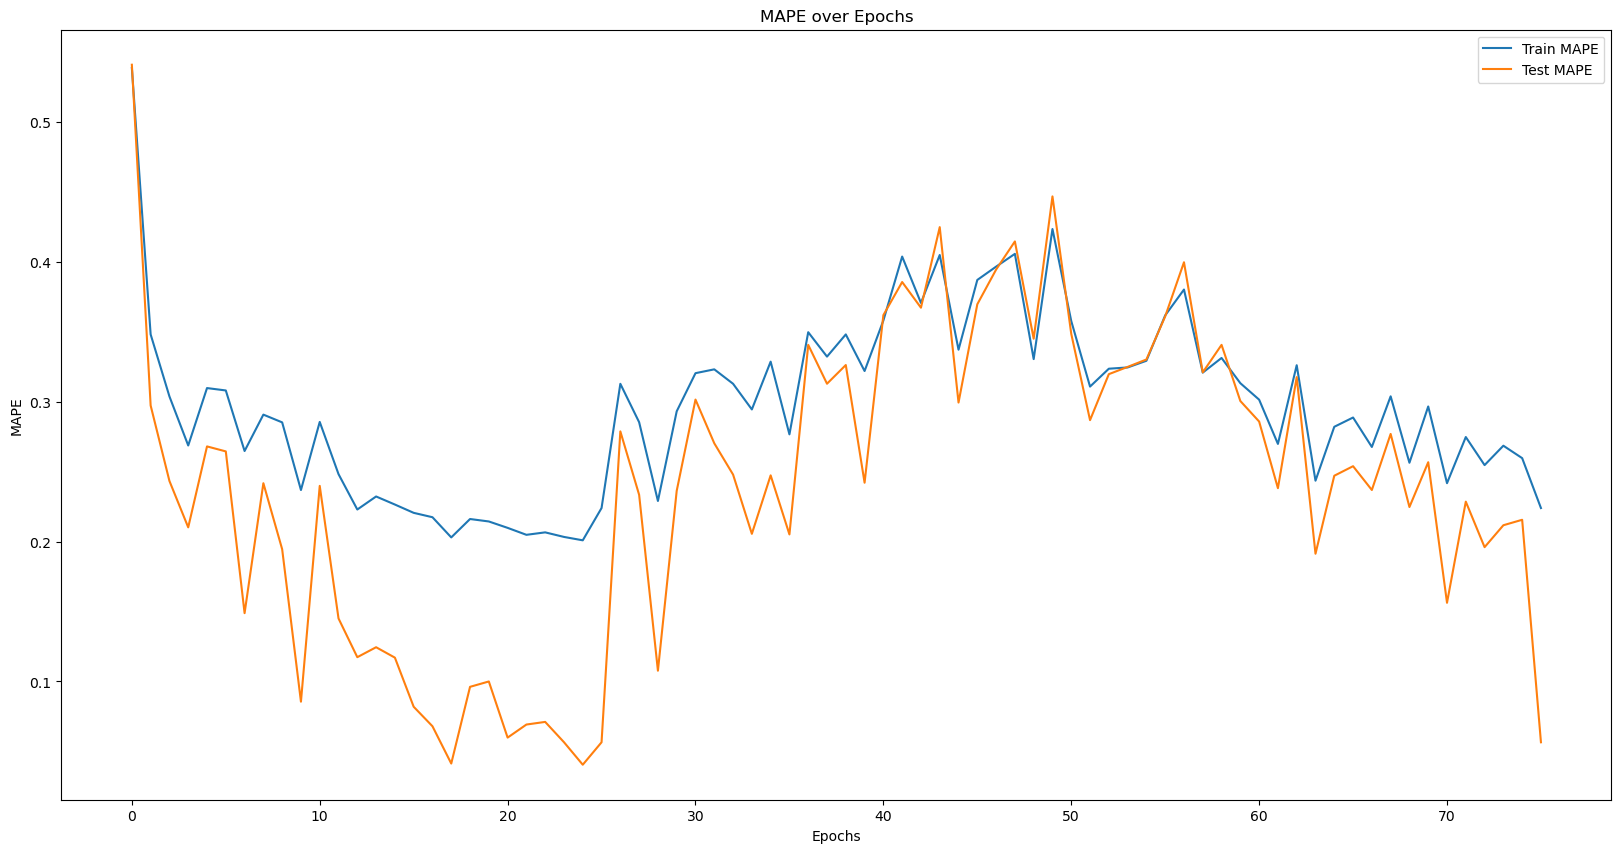

Iteration 5/20:
Lookback Periods: 4, Dropout proportion: 0.4, Epochs: 50, Learning Rate: 0.1
8/8 [==============================] - 0s 527us/step
Restoring model weights from the end of the best epoch: 17.
8/8 [==============================] - 0s 519us/step
Epoch 67: early stopping
8/8 [==============================] - 0s 625us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 537.834228515625
Last epoch val_loss: 761.86181640625
Average Test MAPE: 0.24648748552637686


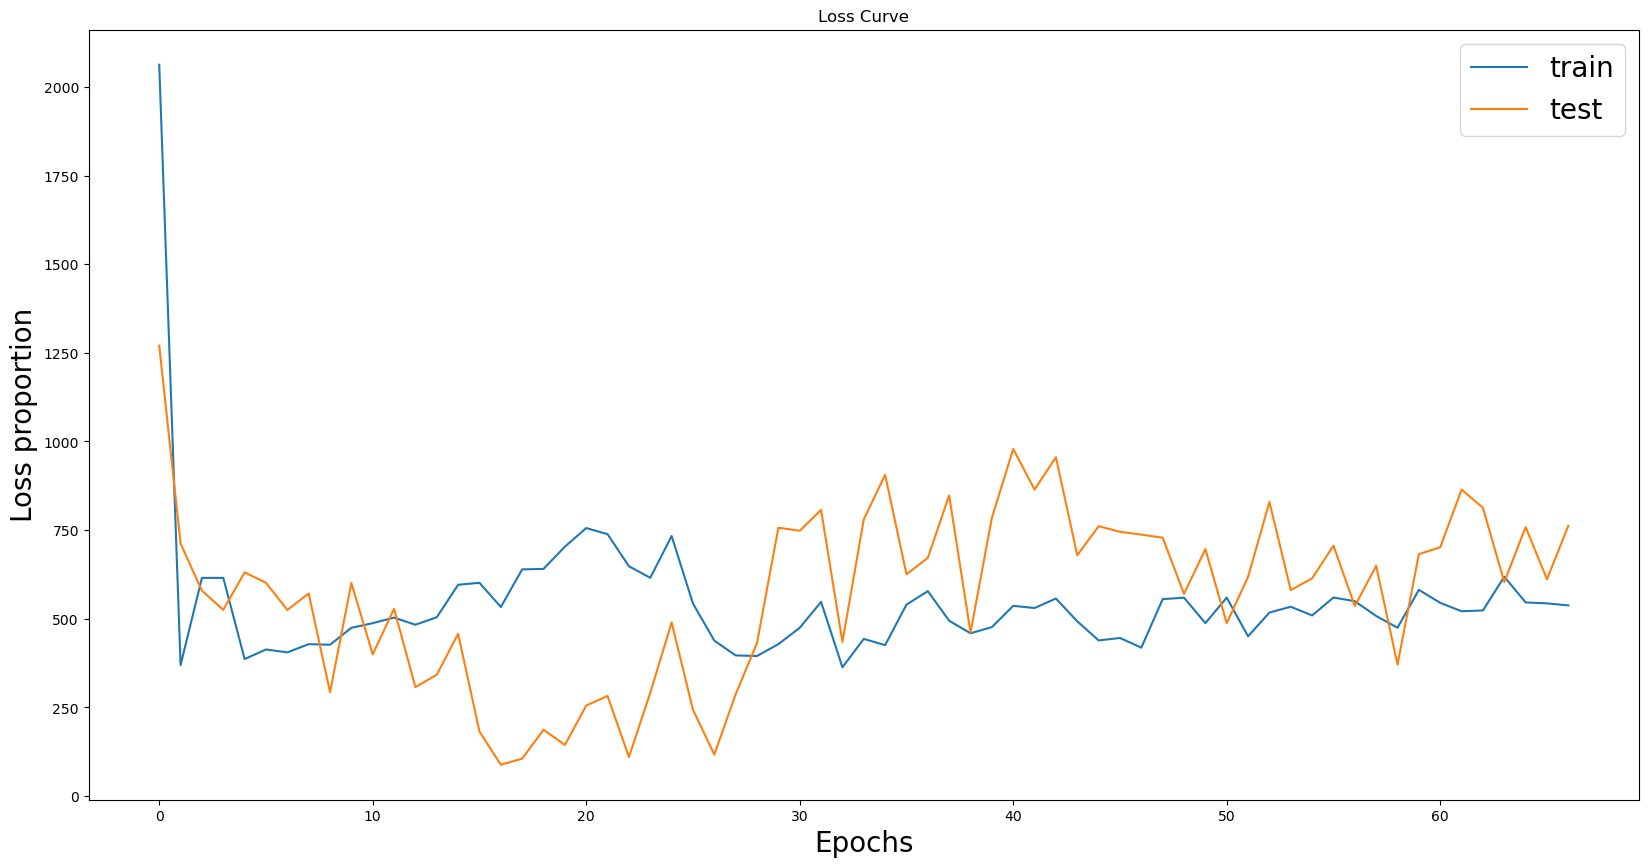

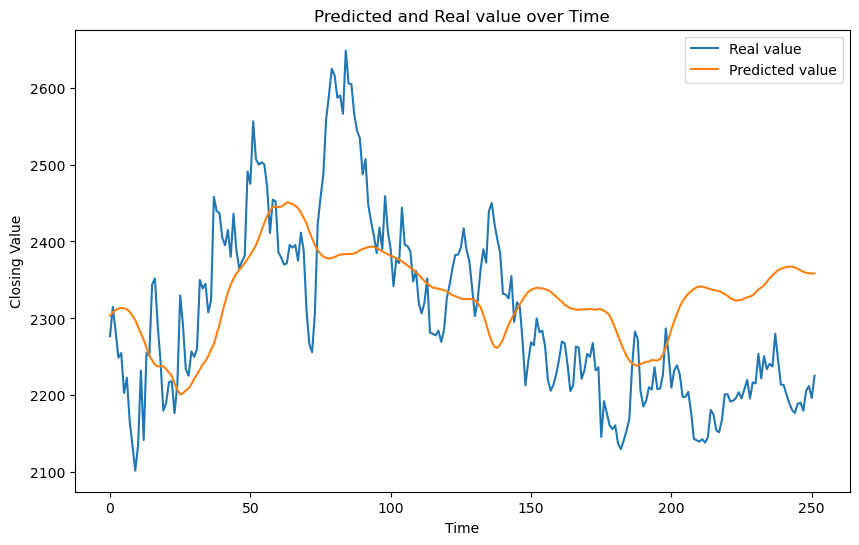

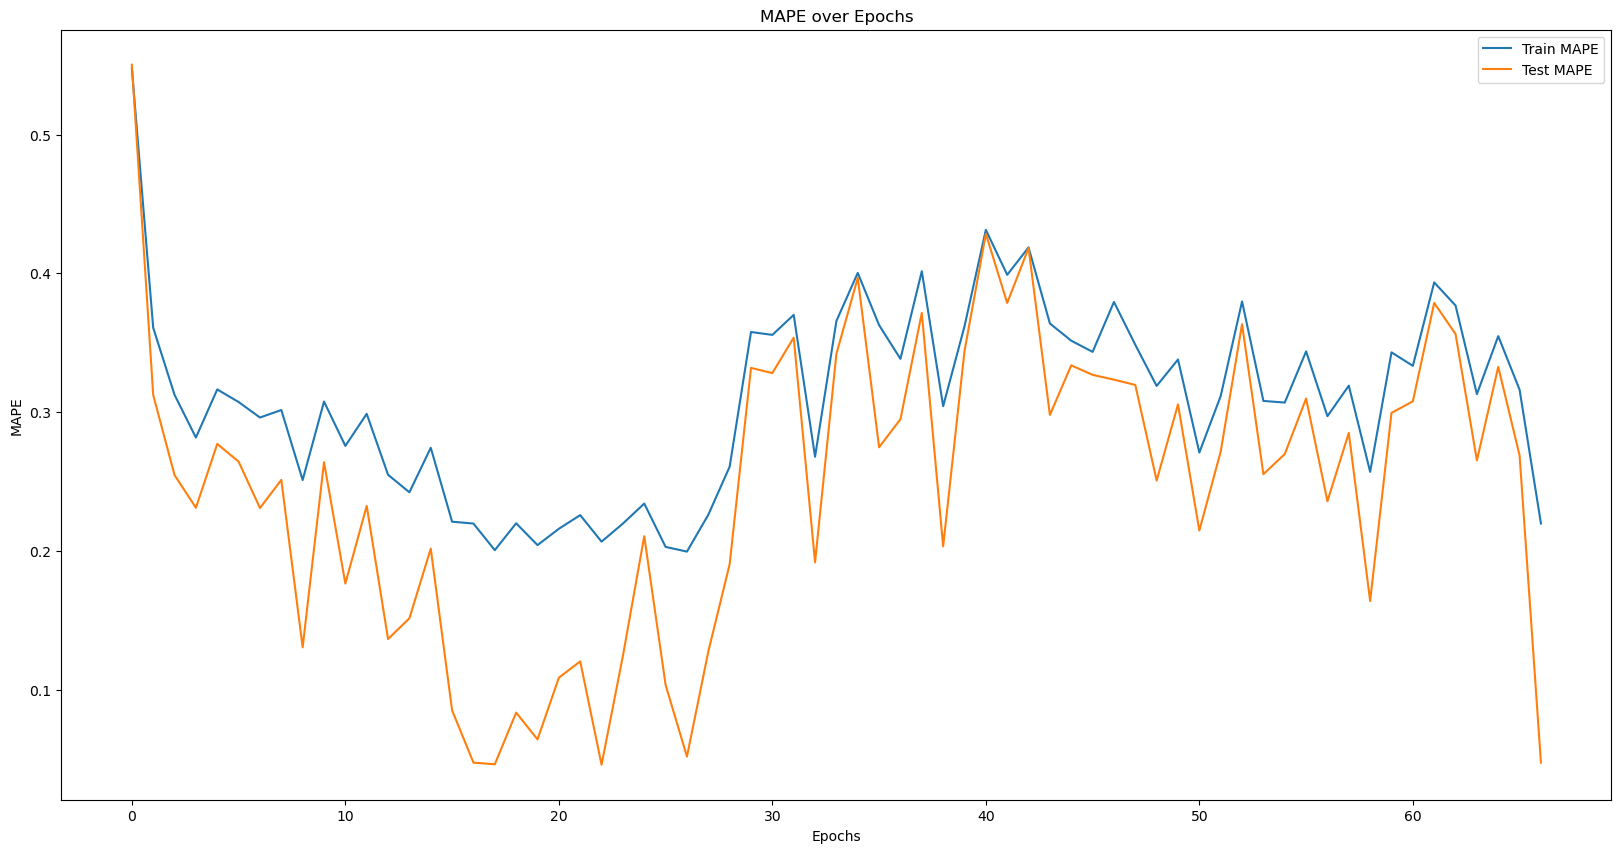

Iteration 6/20:
Lookback Periods: 5, Dropout proportion: 0.4, Epochs: 150, Learning Rate: 0.1
8/8 [==============================] - 0s 553us/step
Restoring model weights from the end of the best epoch: 19.
8/8 [==============================] - 0s 553us/step
Epoch 69: early stopping
8/8 [==============================] - 0s 551us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 488.8065185546875
Last epoch val_loss: 517.98486328125
Average Test MAPE: 0.21407233770149228


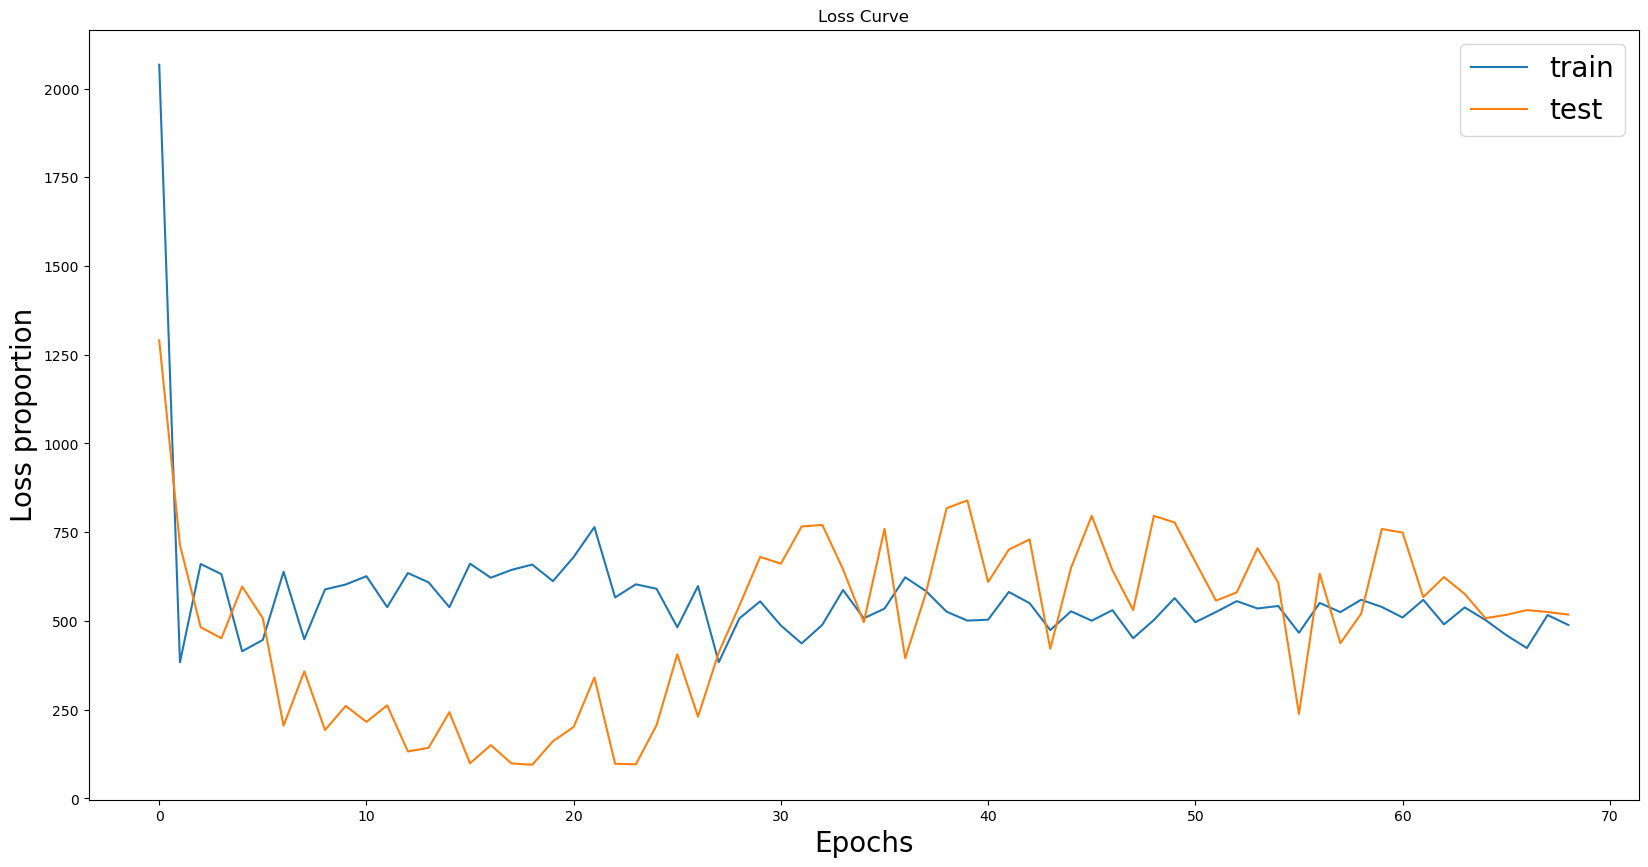

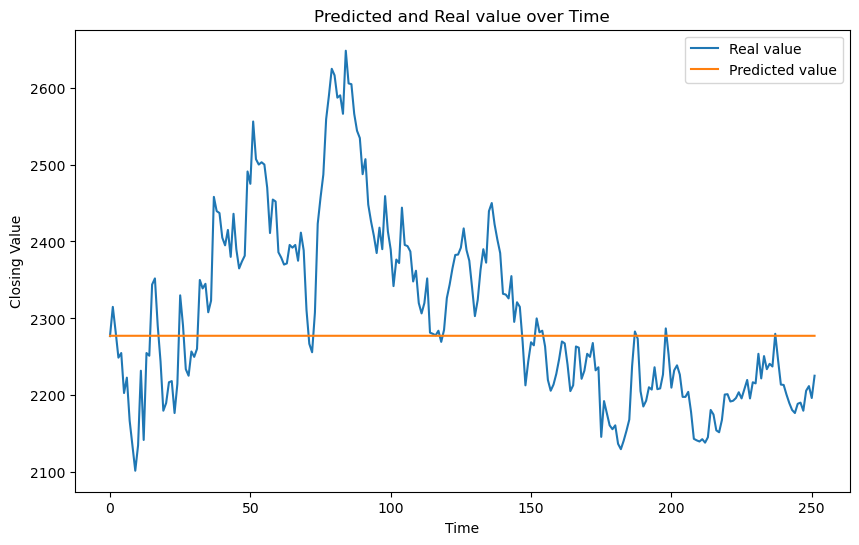

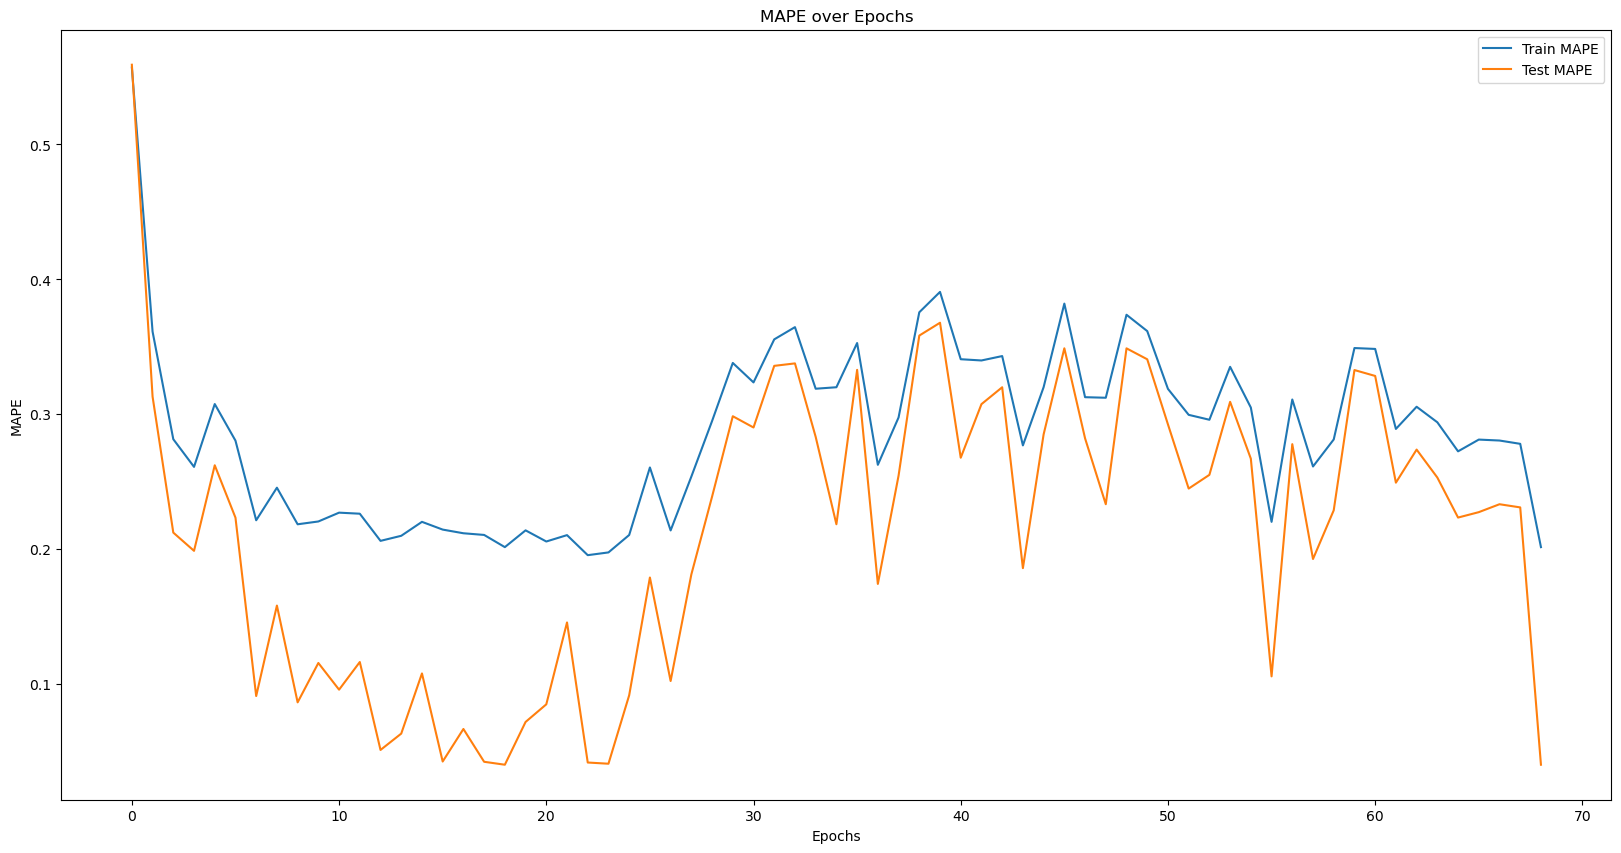

Iteration 7/20:
Lookback Periods: 3, Dropout proportion: 0.4, Epochs: 100, Learning Rate: 0.1
8/8 [==============================] - 0s 528us/step
Restoring model weights from the end of the best epoch: 18.
8/8 [==============================] - 0s 547us/step
Epoch 68: early stopping
8/8 [==============================] - 0s 561us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 558.65966796875
Last epoch val_loss: 372.7677307128906
Average Test MAPE: 0.2122140955937677


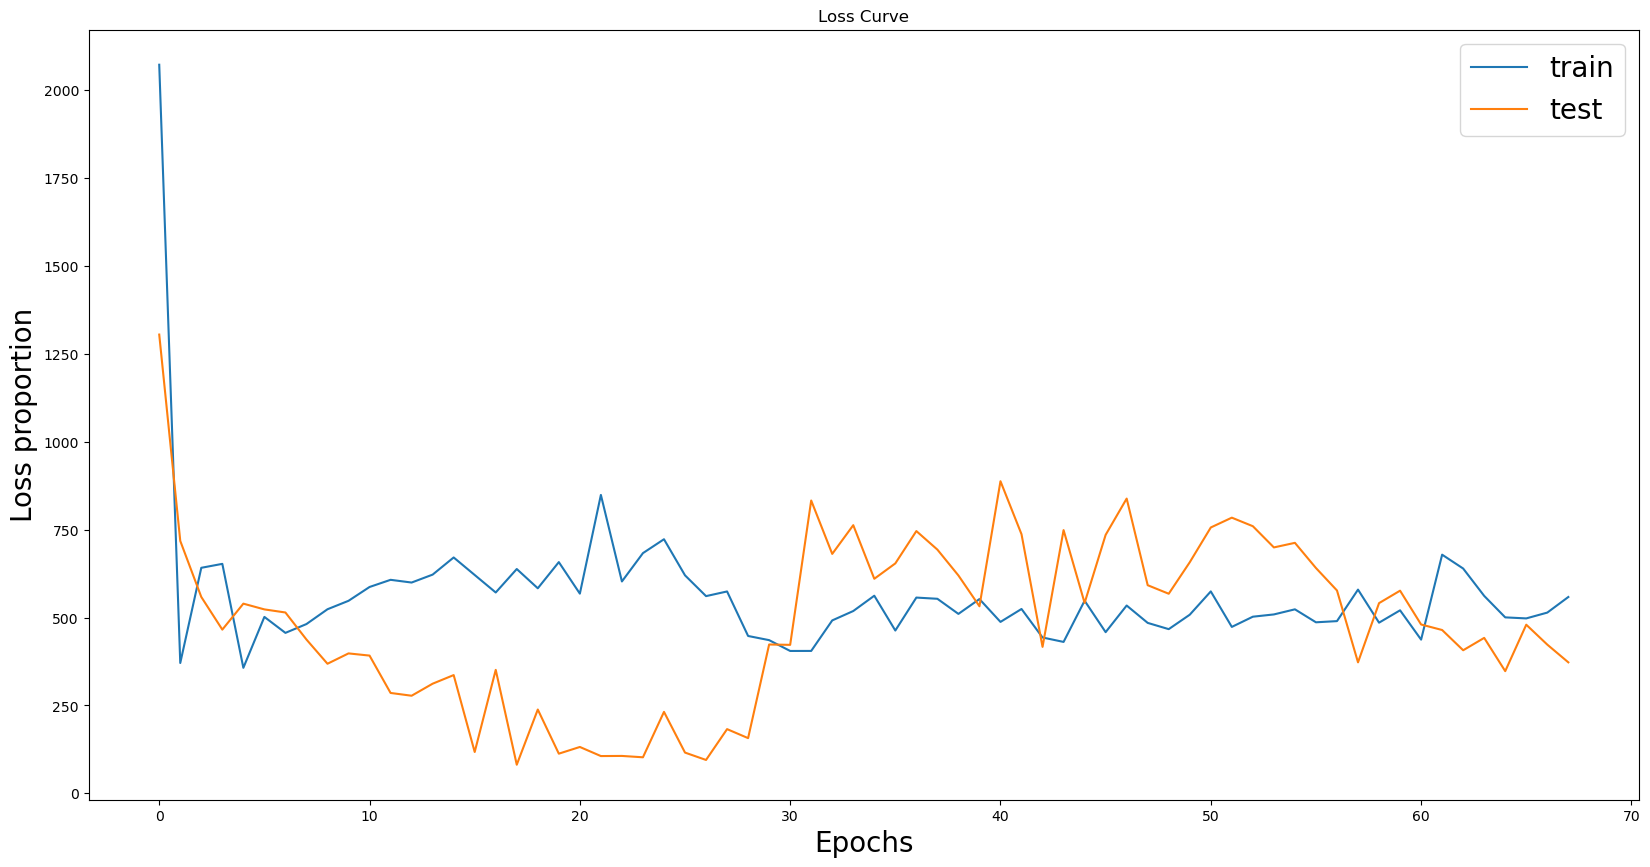

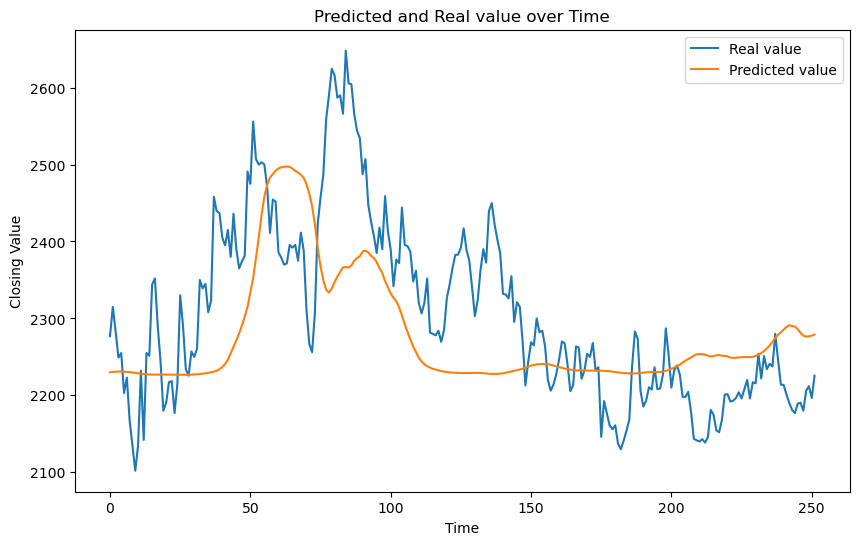

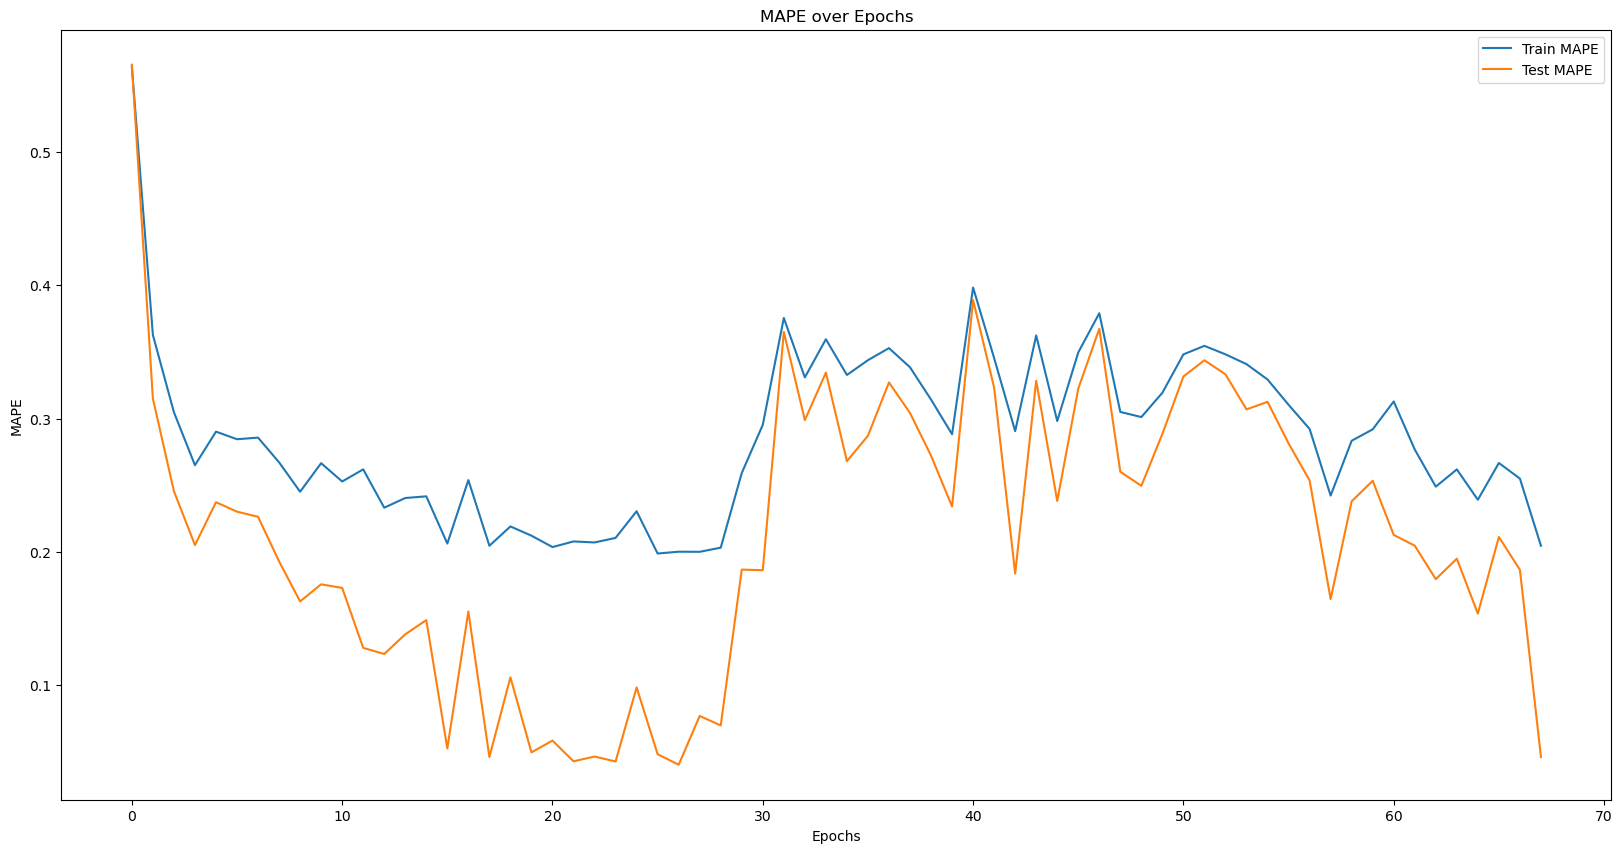

Iteration 8/20:
Lookback Periods: 5, Dropout proportion: 0.3, Epochs: 100, Learning Rate: 0.01
8/8 [==============================] - 0s 513us/step
Restoring model weights from the end of the best epoch: 23.
8/8 [==============================] - 0s 548us/step
Epoch 73: early stopping
8/8 [==============================] - 0s 542us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 478.7867736816406
Last epoch val_loss: 600.9063110351562
Average Test MAPE: 0.1932846621460438


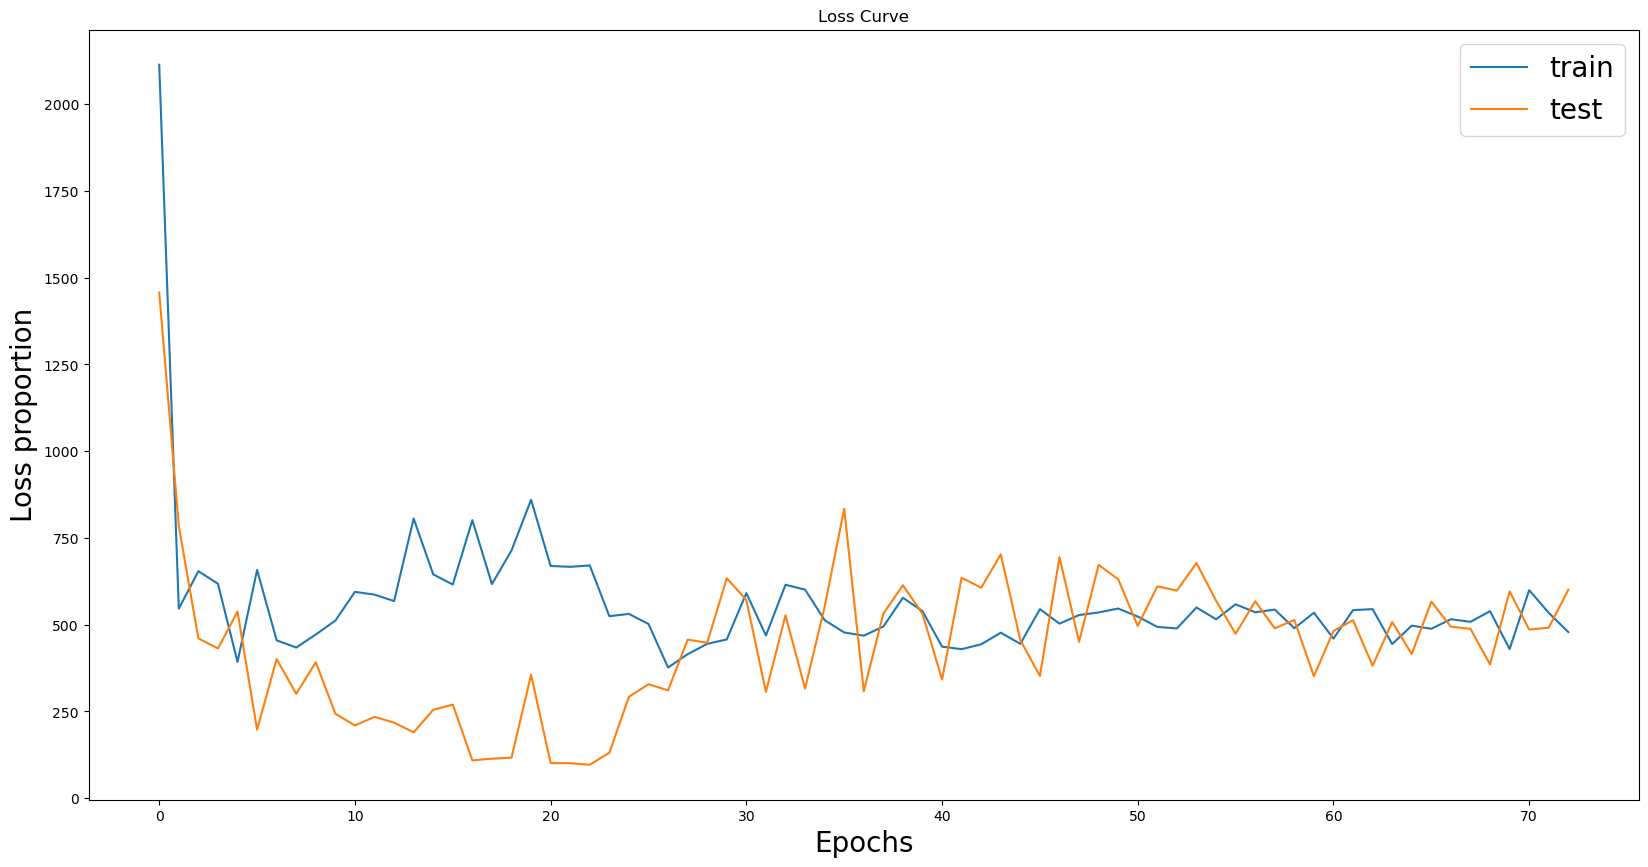

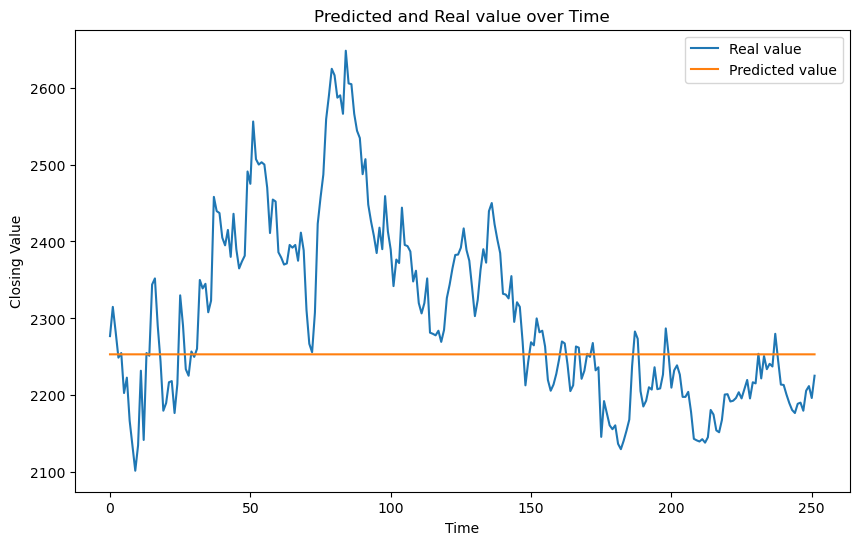

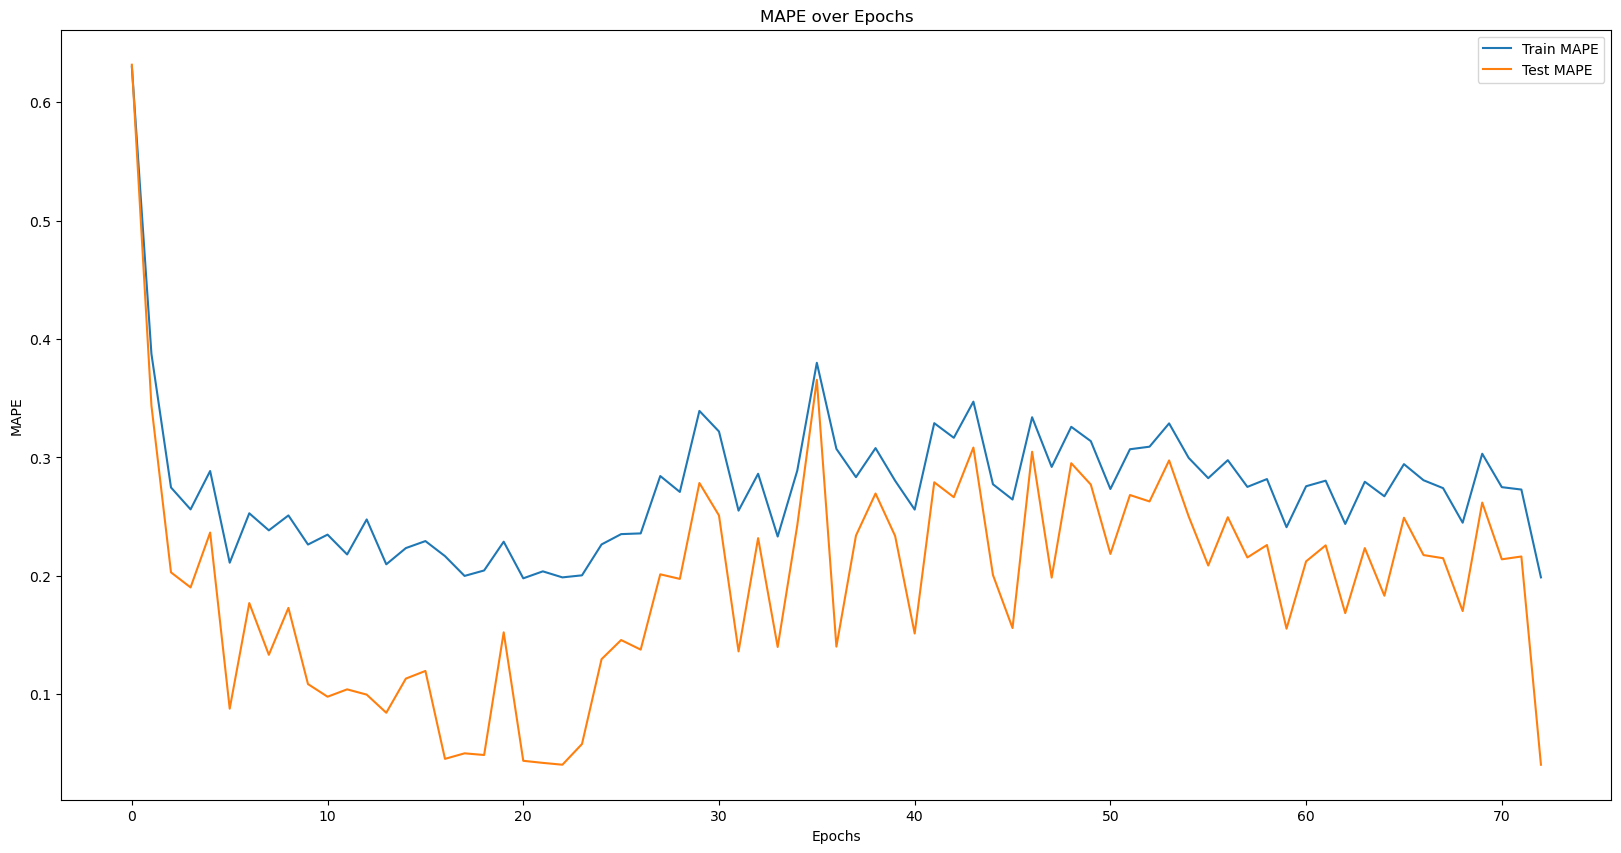

Iteration 9/20:
Lookback Periods: 3, Dropout proportion: 0.2, Epochs: 100, Learning Rate: 0.1
8/8 [==============================] - 0s 513us/step
Restoring model weights from the end of the best epoch: 18.
8/8 [==============================] - 0s 529us/step
Epoch 68: early stopping
8/8 [==============================] - 0s 555us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 510.6800537109375
Last epoch val_loss: 559.0294189453125
Average Test MAPE: 0.22257951672685977


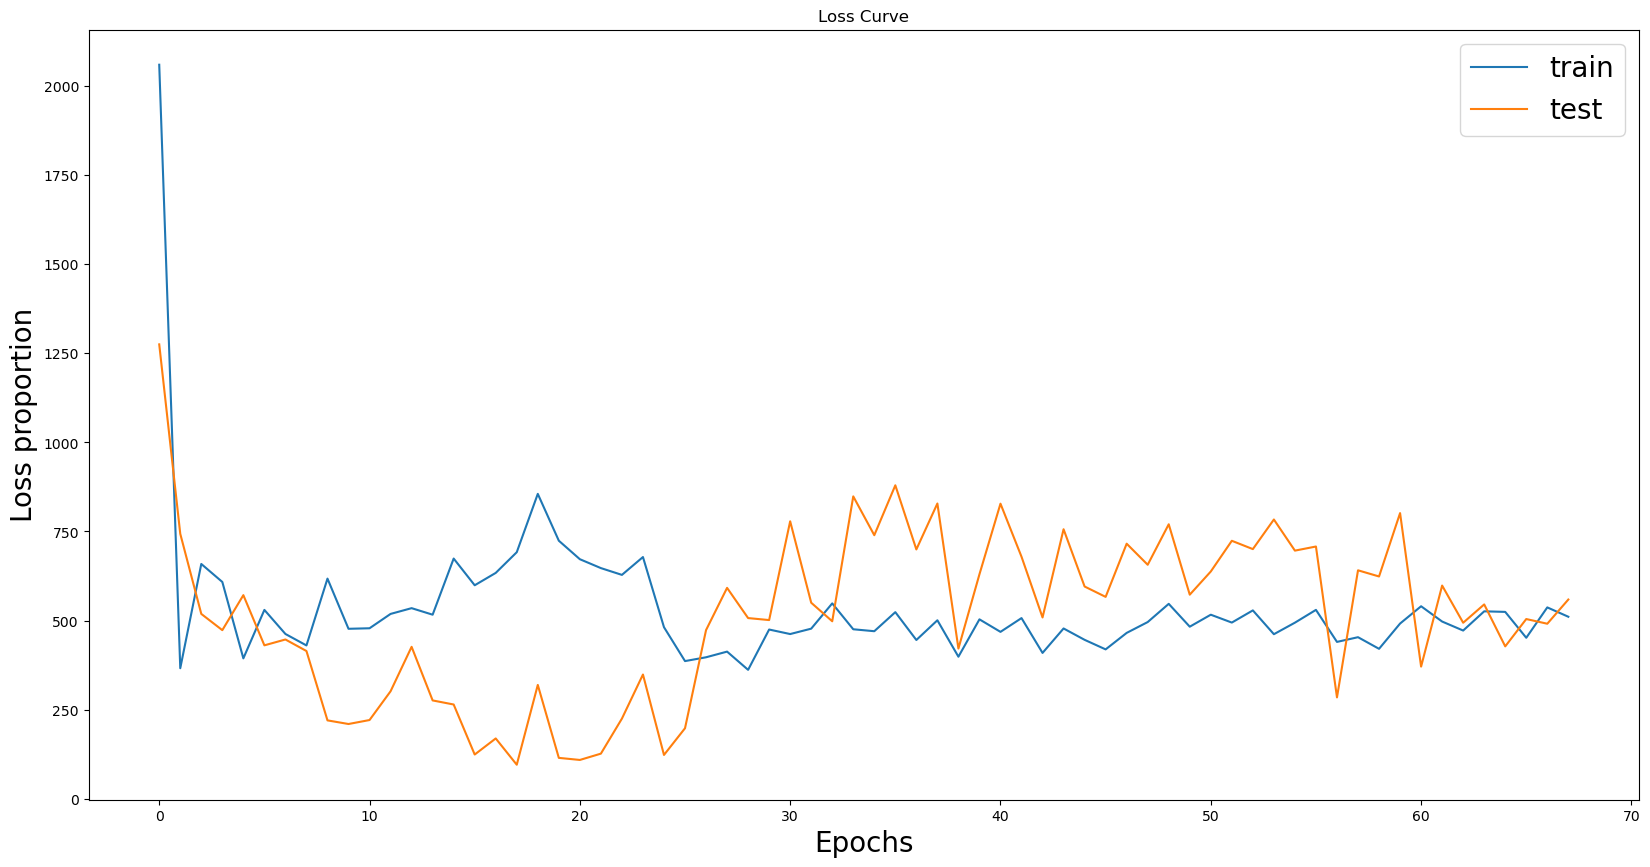

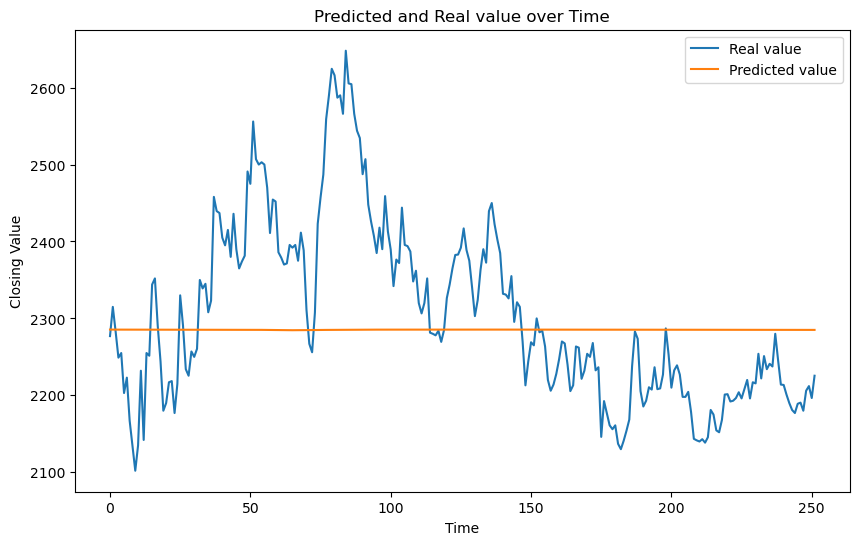

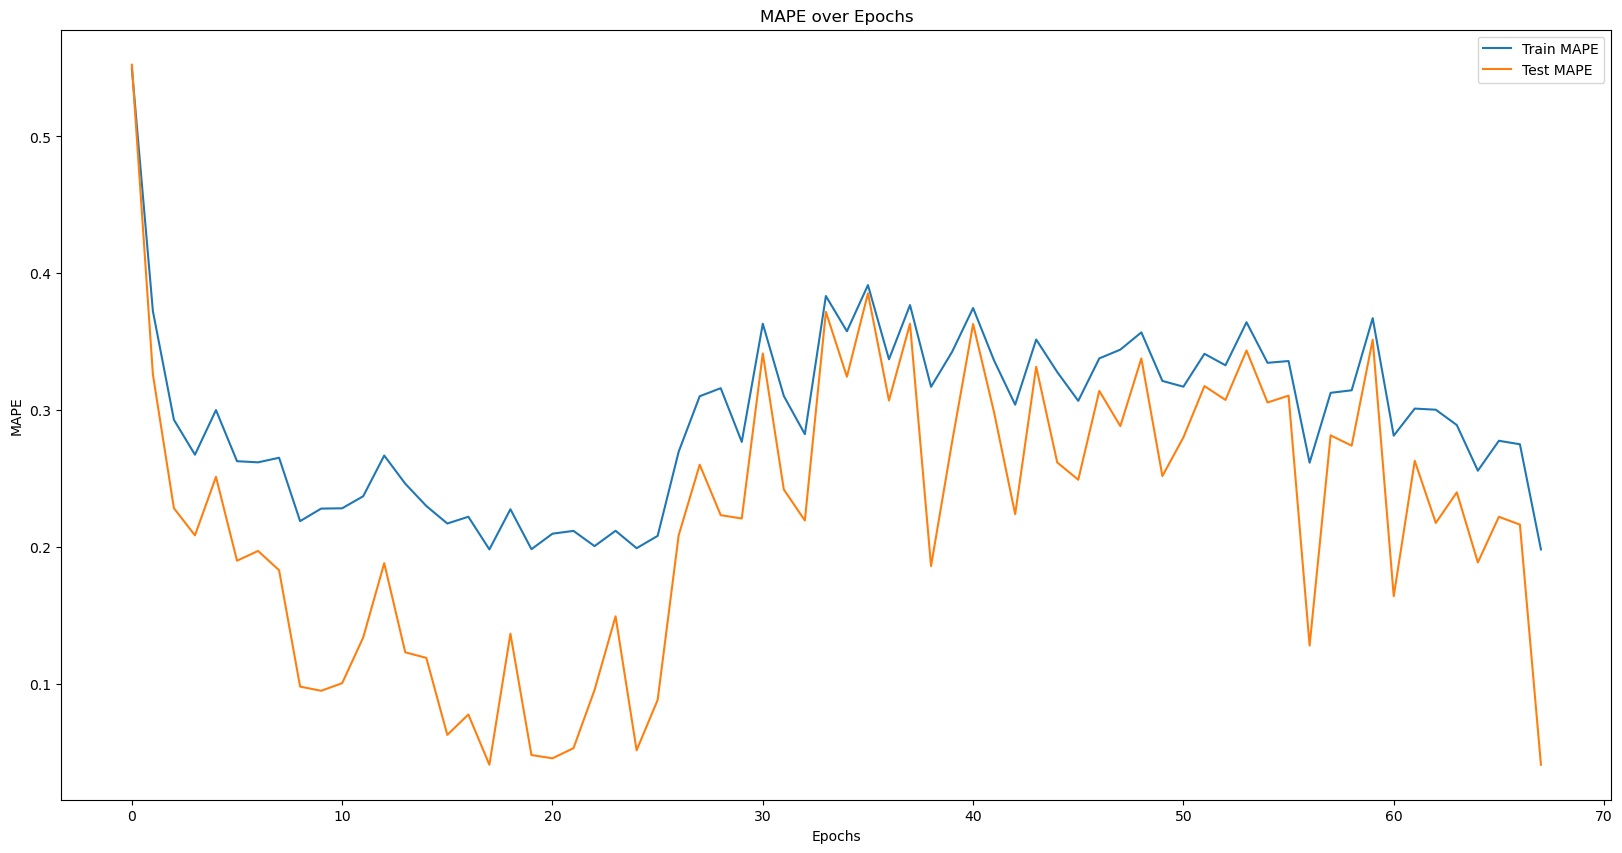

Iteration 10/20:
Lookback Periods: 3, Dropout proportion: 0.2, Epochs: 100, Learning Rate: 0.001
8/8 [==============================] - 0s 530us/step
Restoring model weights from the end of the best epoch: 24.
8/8 [==============================] - 0s 547us/step
Epoch 74: early stopping


8/8 [==============================] - 0s 565us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 516.7001953125
Last epoch val_loss: 505.4801330566406
Average Test MAPE: 0.20922582225329328


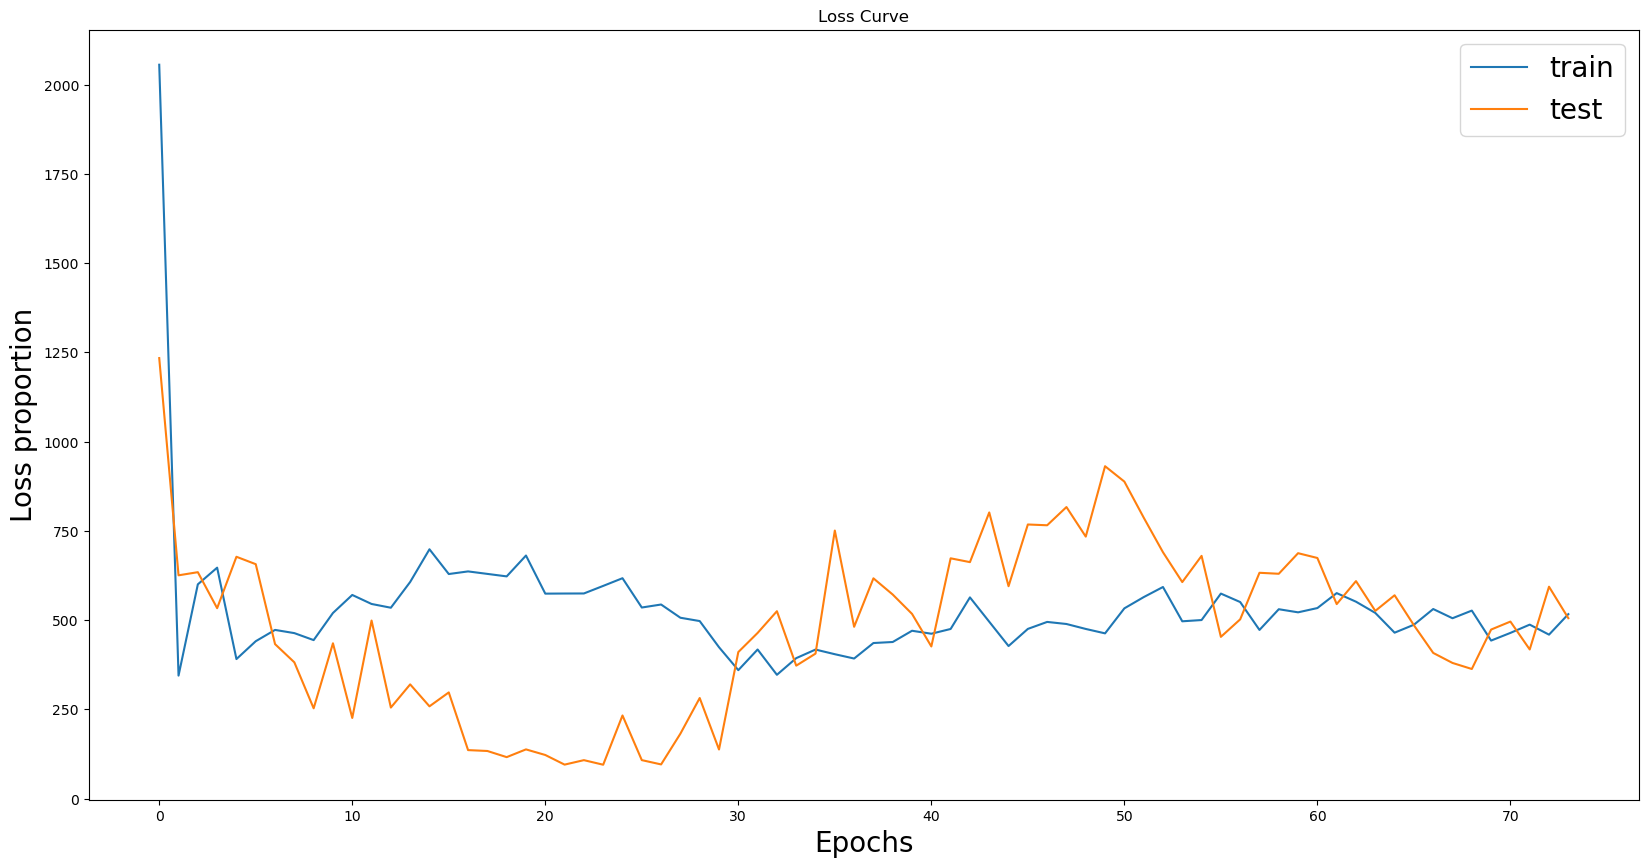

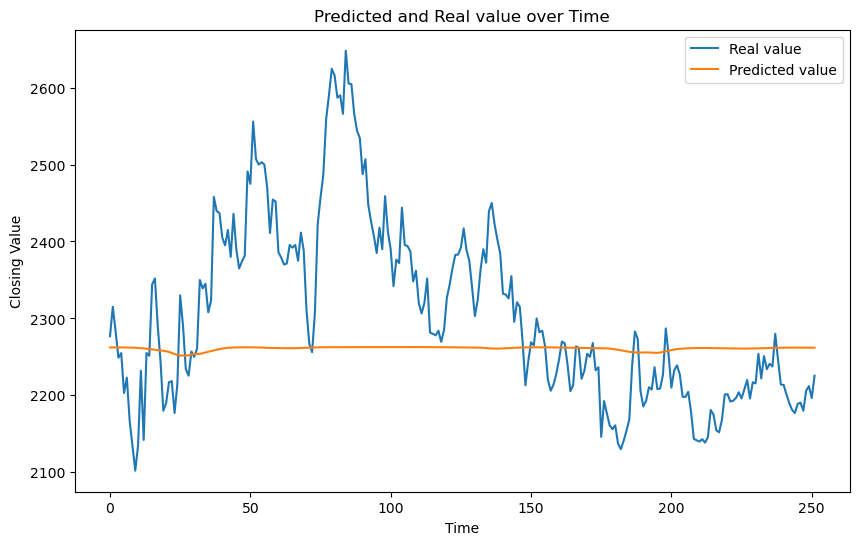

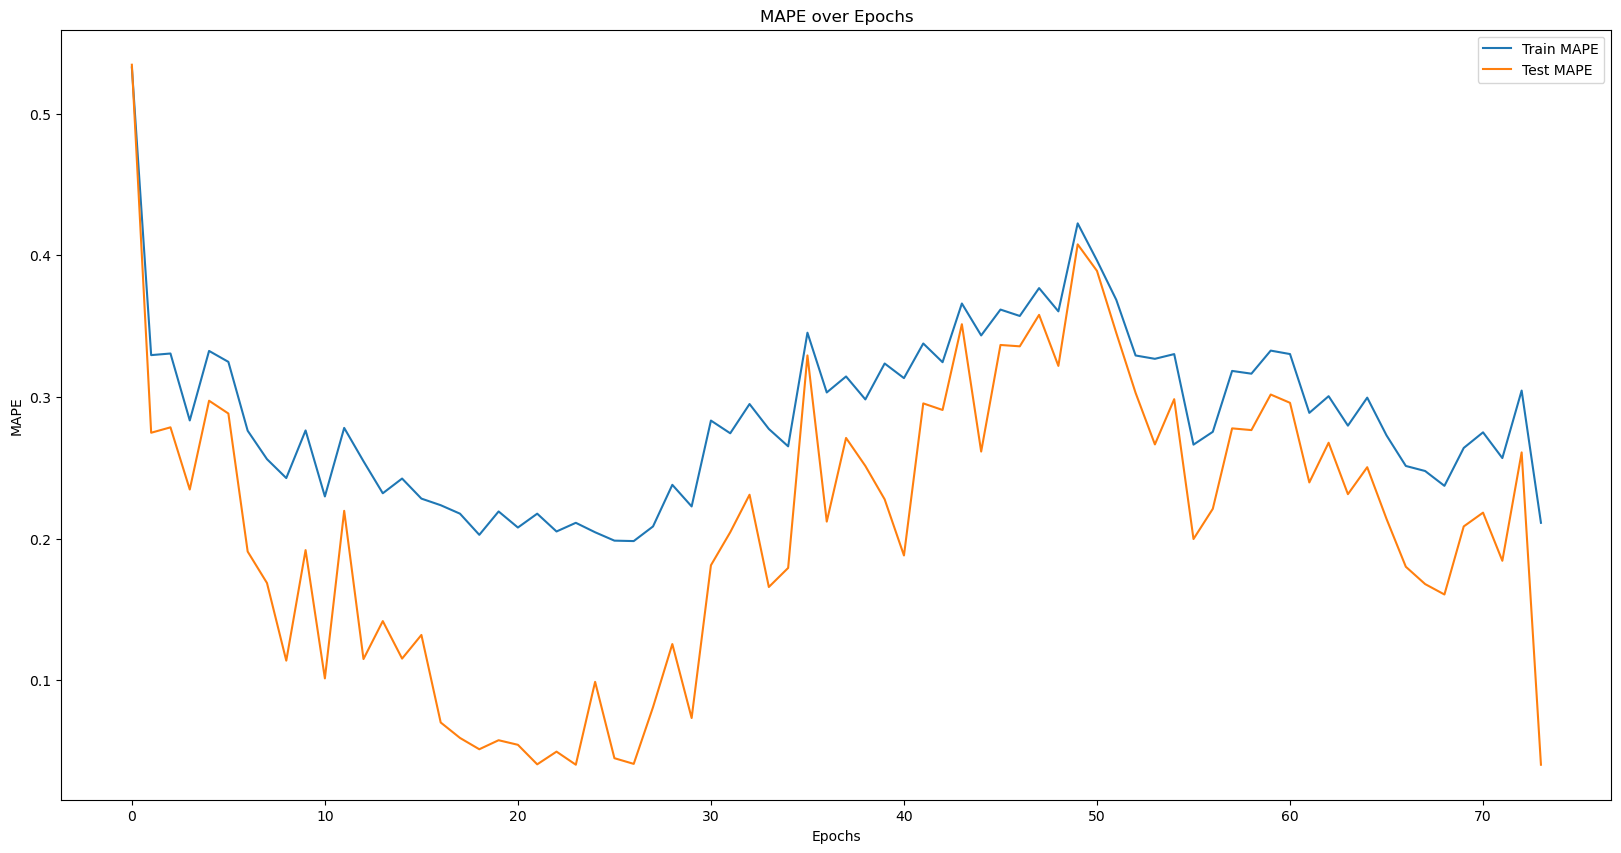

Iteration 11/20:
Lookback Periods: 5, Dropout proportion: 0.3, Epochs: 50, Learning Rate: 0.001
8/8 [==============================] - 0s 524us/step
Restoring model weights from the end of the best epoch: 17.
8/8 [==============================] - 0s 544us/step
Epoch 67: early stopping
8/8 [==============================] - 0s 590us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 533.085693359375
Last epoch val_loss: 580.47314453125
Average Test MAPE: 0.20927446307505634


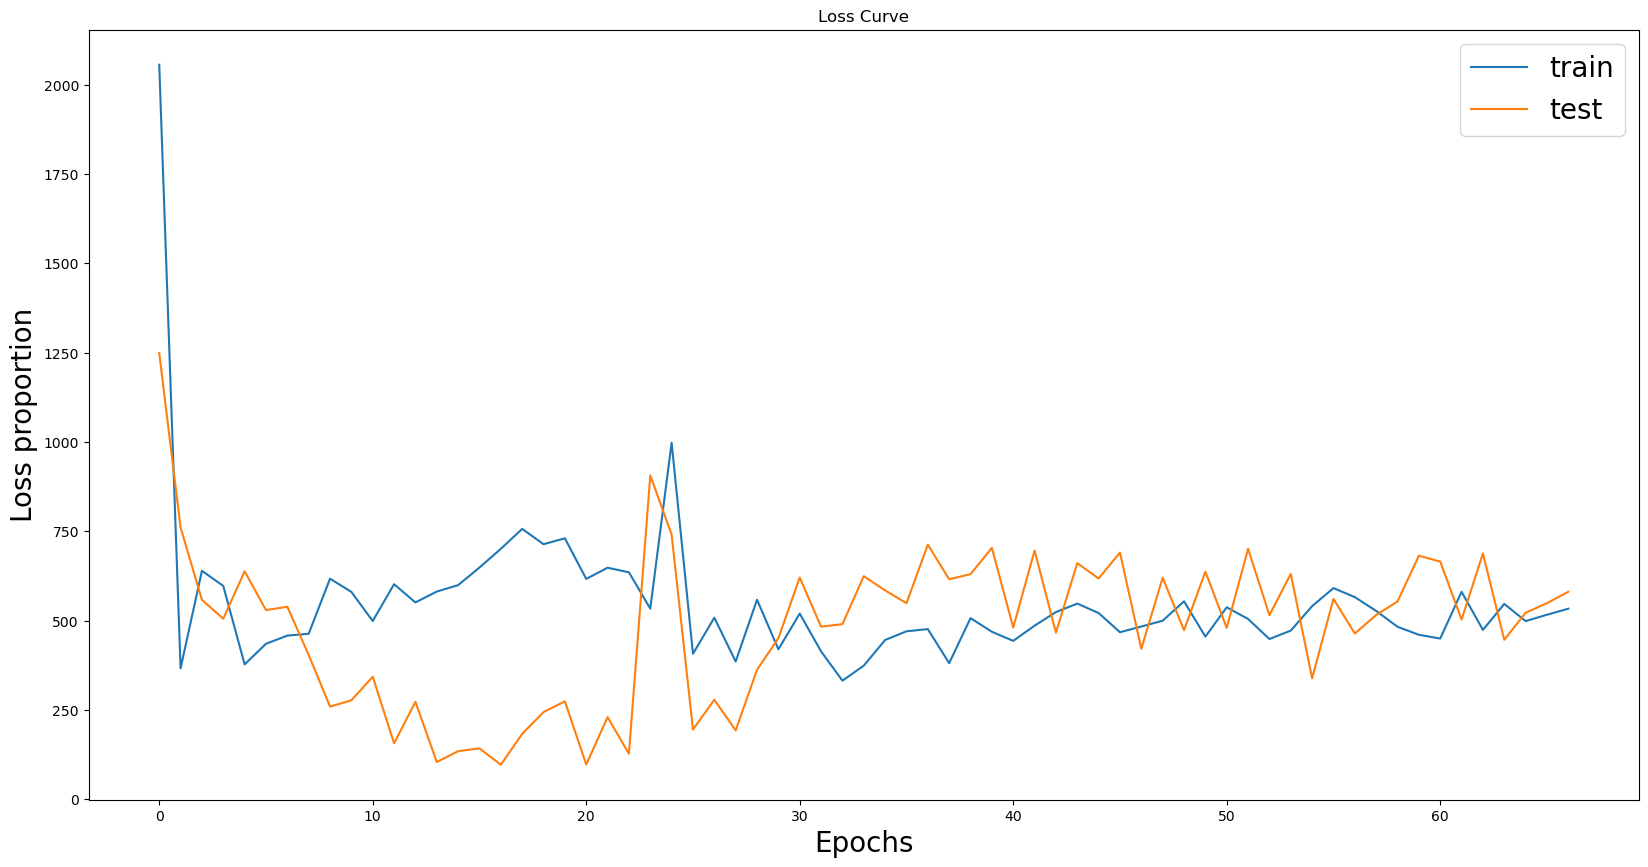

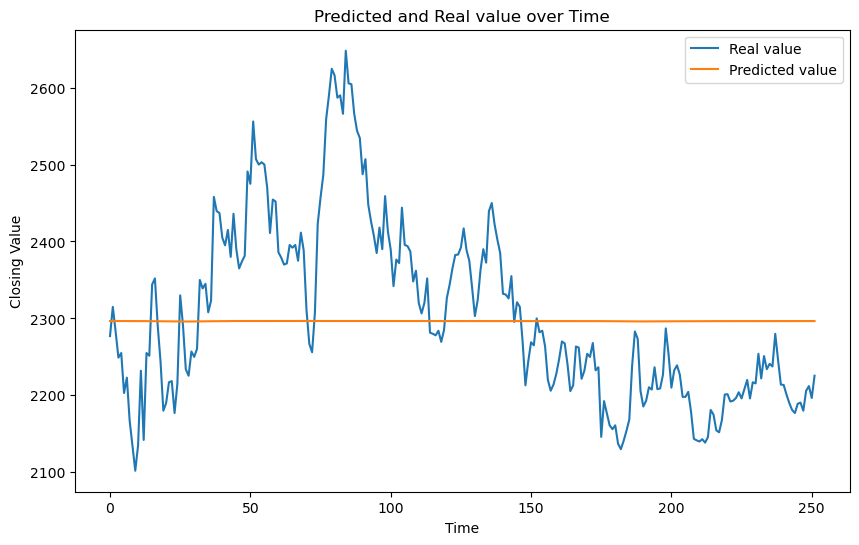

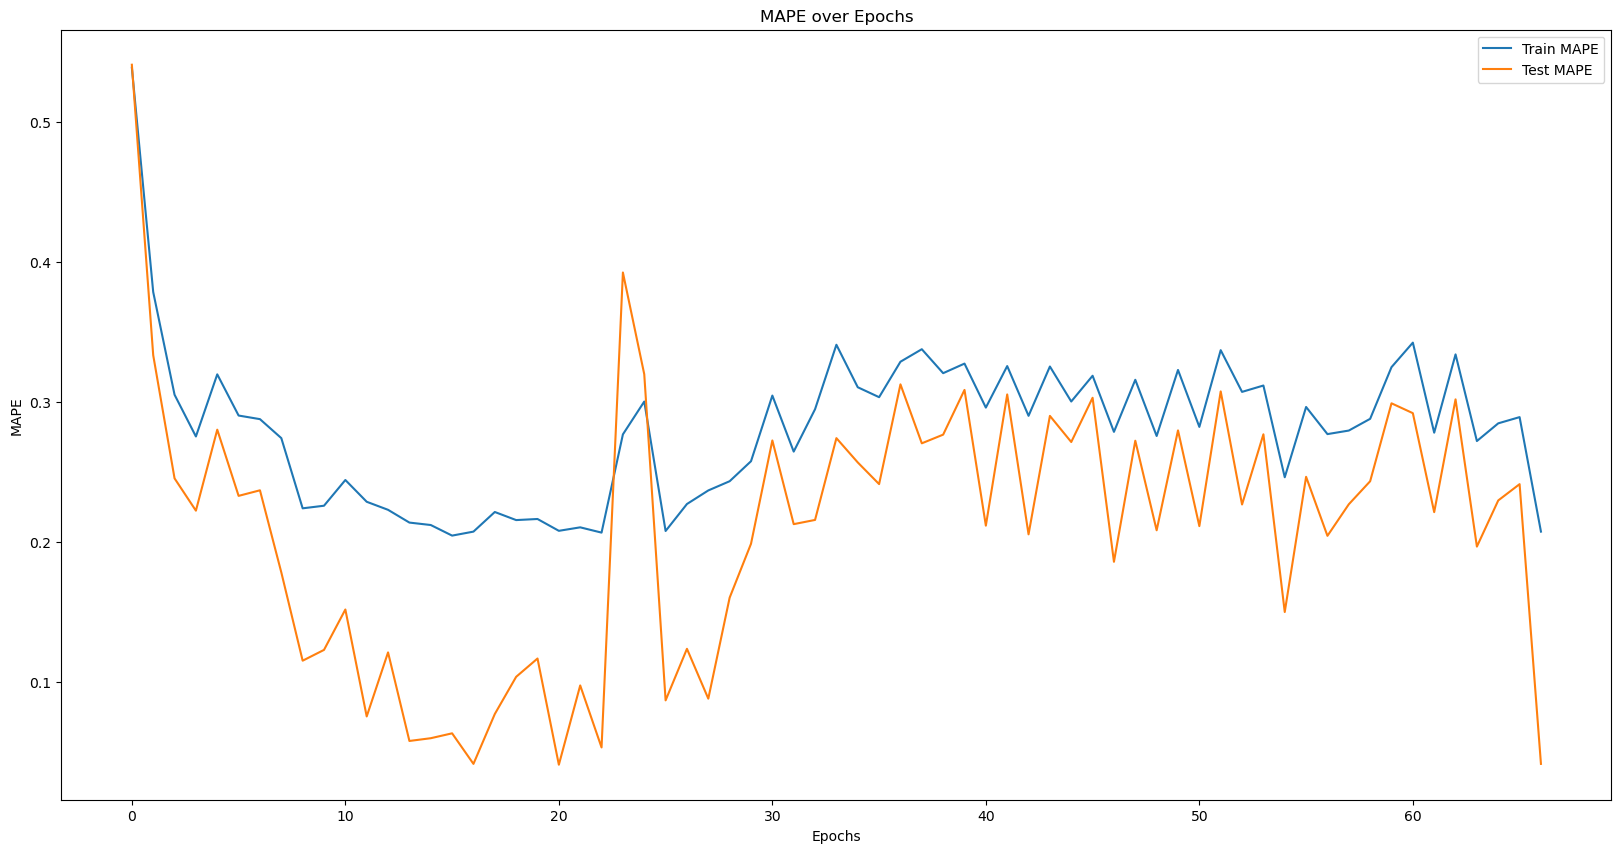

Iteration 12/20:
Lookback Periods: 3, Dropout proportion: 0.4, Epochs: 50, Learning Rate: 0.001
8/8 [==============================] - 0s 500us/step
Restoring model weights from the end of the best epoch: 17.
8/8 [==============================] - 0s 558us/step
Epoch 67: early stopping
8/8 [==============================] - 0s 546us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 471.76806640625
Last epoch val_loss: 567.39306640625
Average Test MAPE: 0.2311964070844456


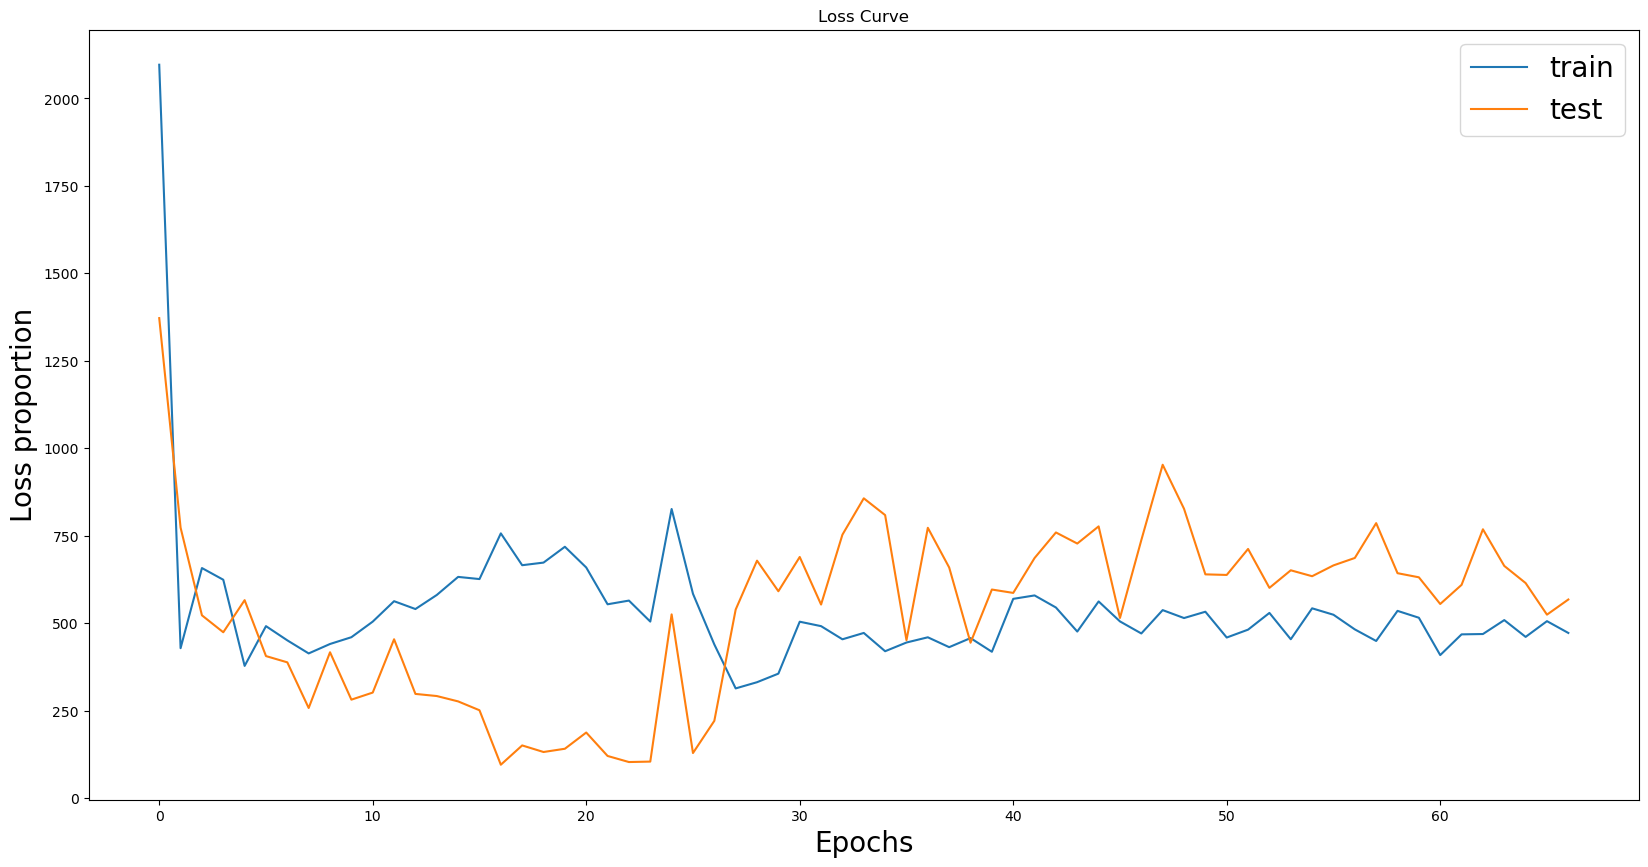

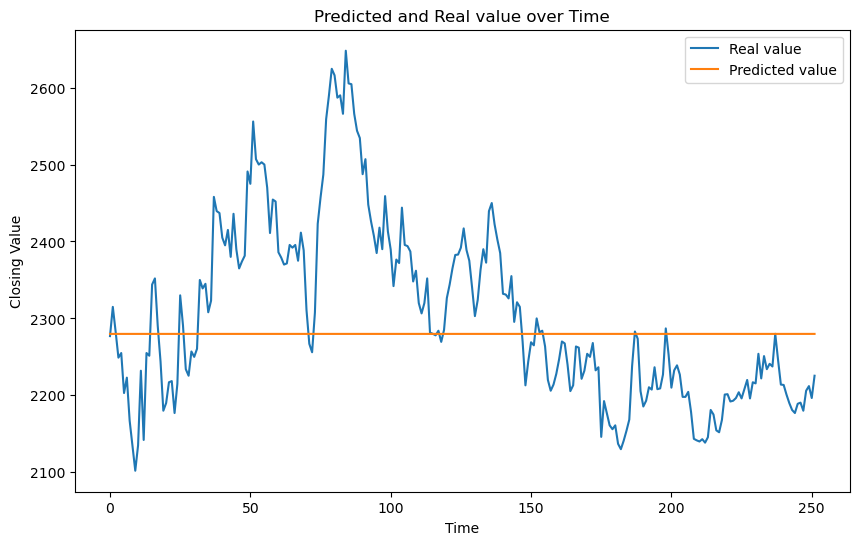

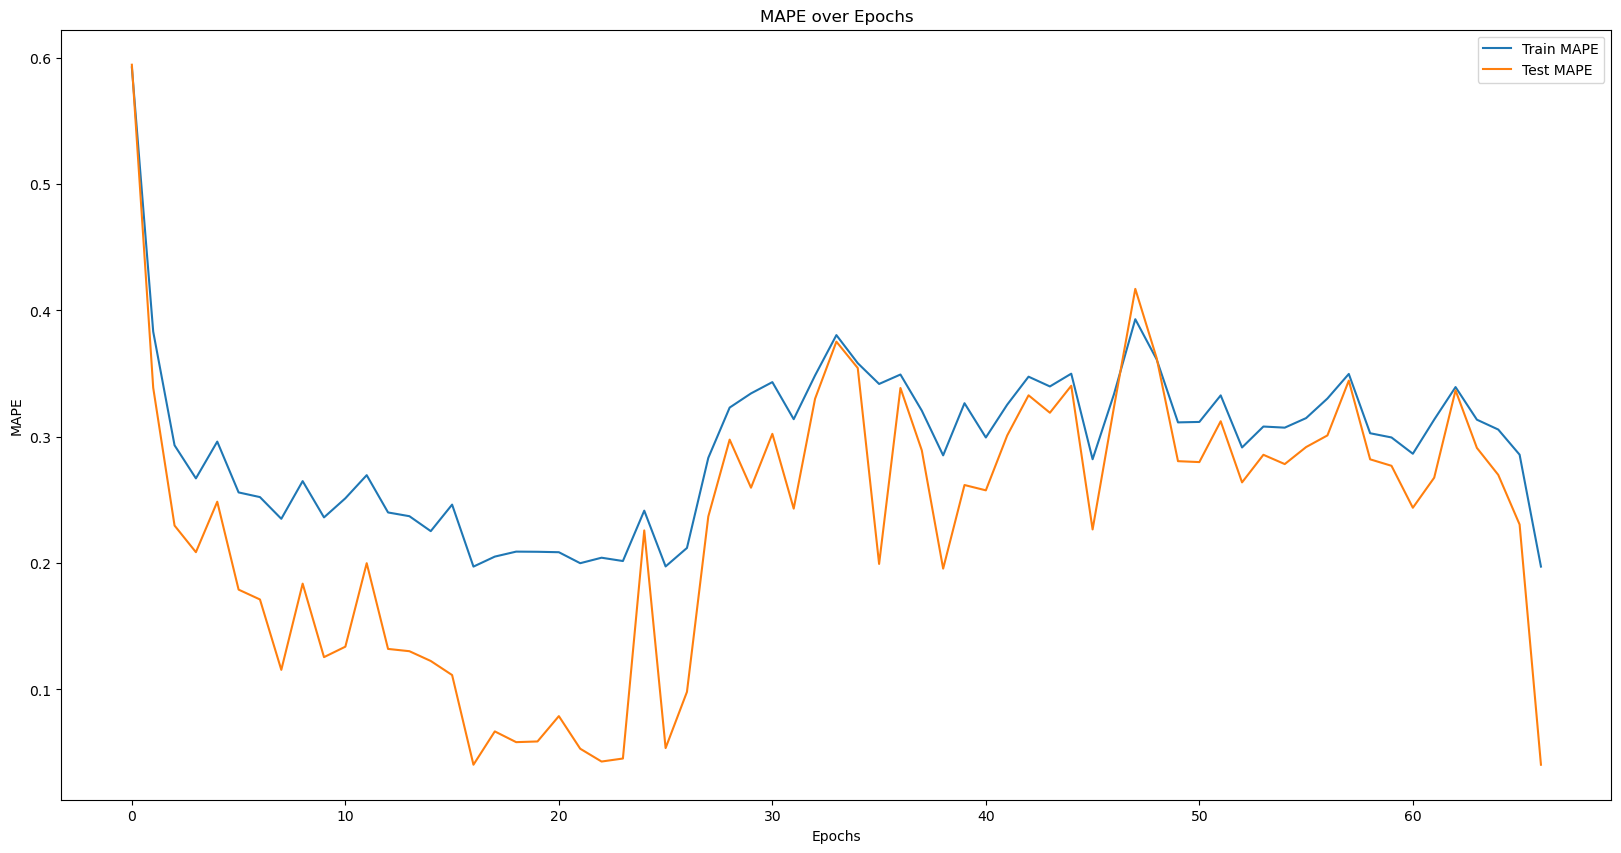

Iteration 13/20:
Lookback Periods: 4, Dropout proportion: 0.3, Epochs: 100, Learning Rate: 0.1
8/8 [==============================] - 0s 539us/step
Restoring model weights from the end of the best epoch: 25.


8/8 [==============================] - 0s 618us/step
Epoch 75: early stopping
8/8 [==============================] - 0s 568us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 506.781005859375
Last epoch val_loss: 548.62890625
Average Test MAPE: 0.2583371188850925


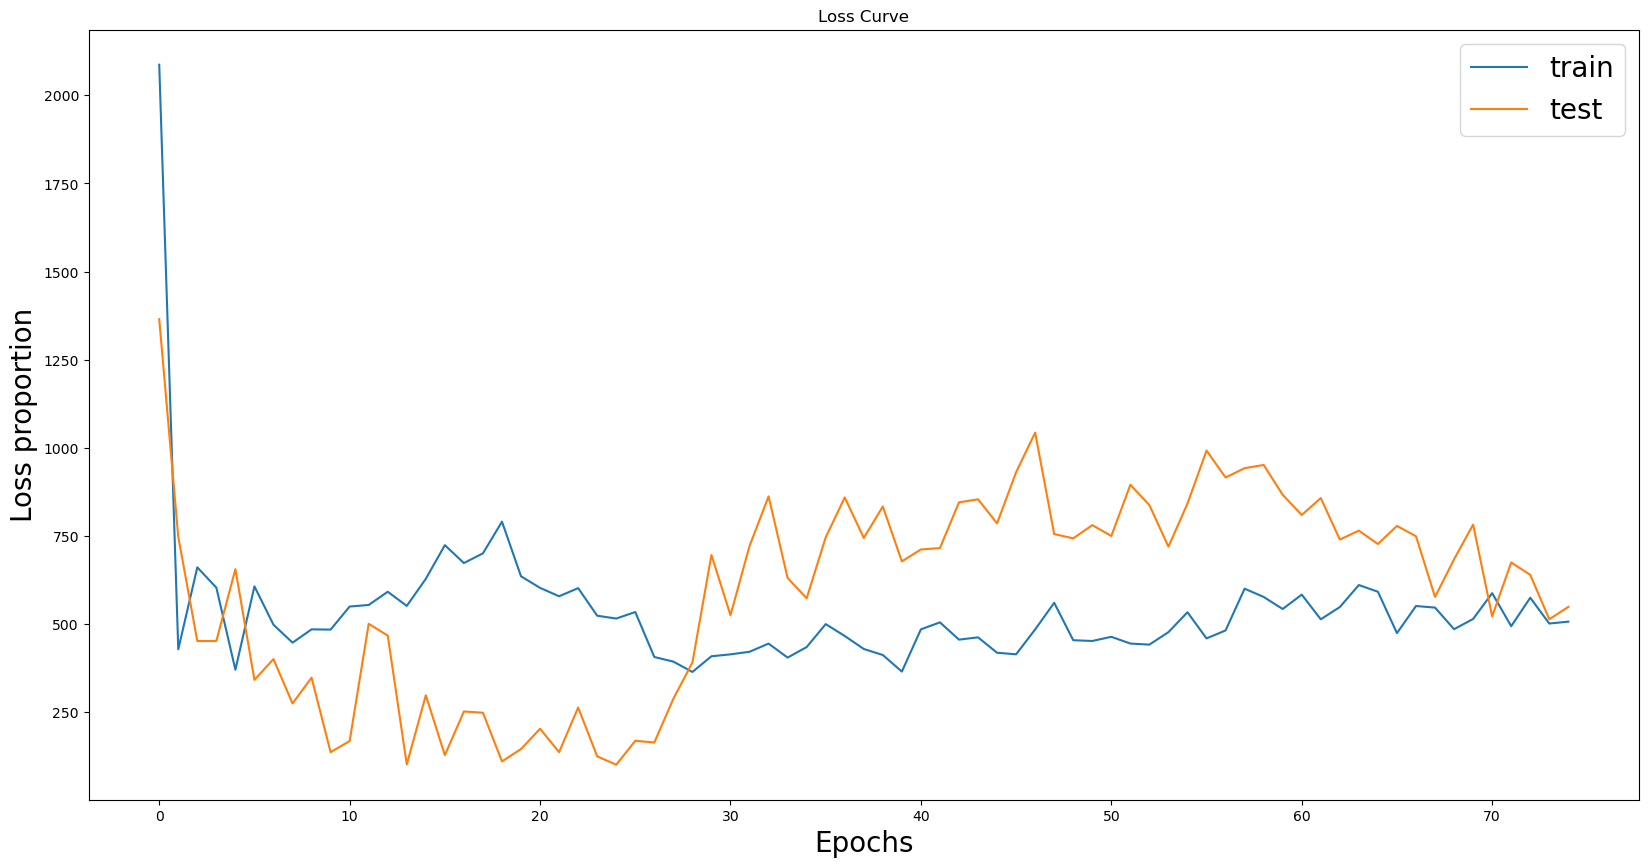

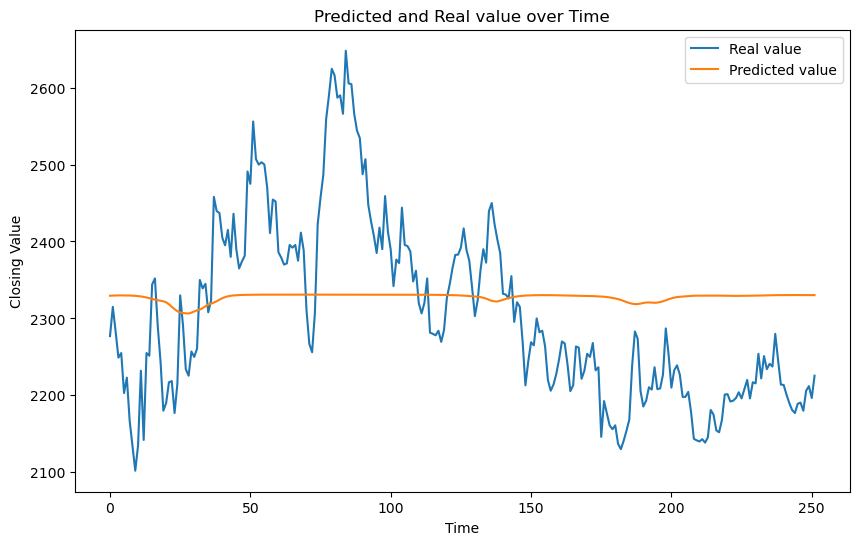

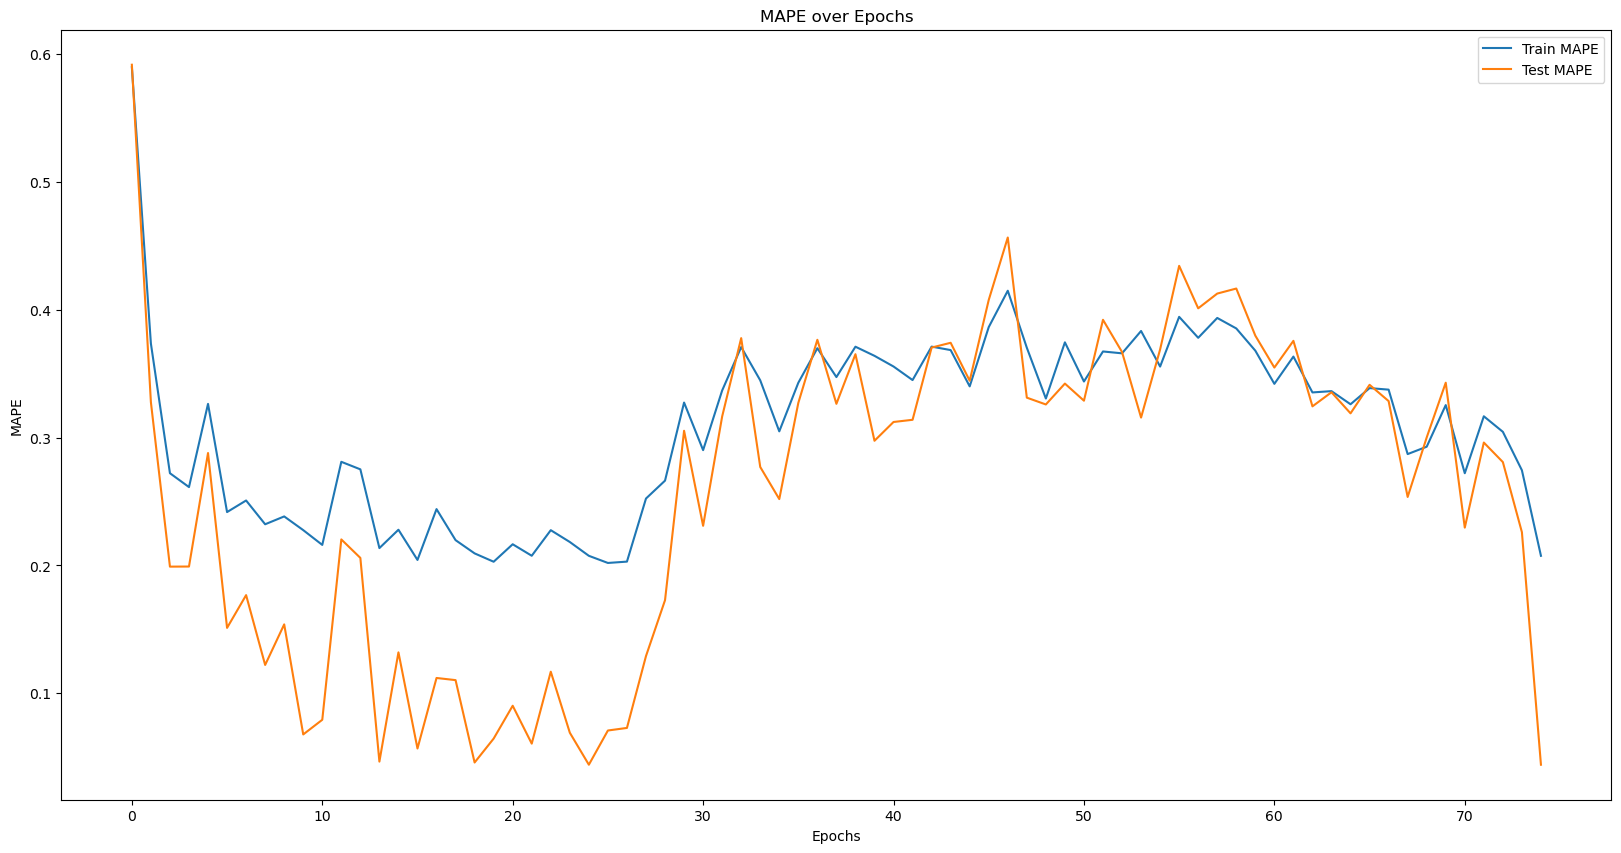

Iteration 14/20:
Lookback Periods: 5, Dropout proportion: 0.3, Epochs: 100, Learning Rate: 0.001
8/8 [==============================] - 0s 583us/step
Restoring model weights from the end of the best epoch: 16.
8/8 [==============================] - 0s 554us/step
Epoch 66: early stopping
8/8 [==============================] - 0s 557us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 560.8877563476562
Last epoch val_loss: 690.8497314453125
Average Test MAPE: 0.24900037532903005


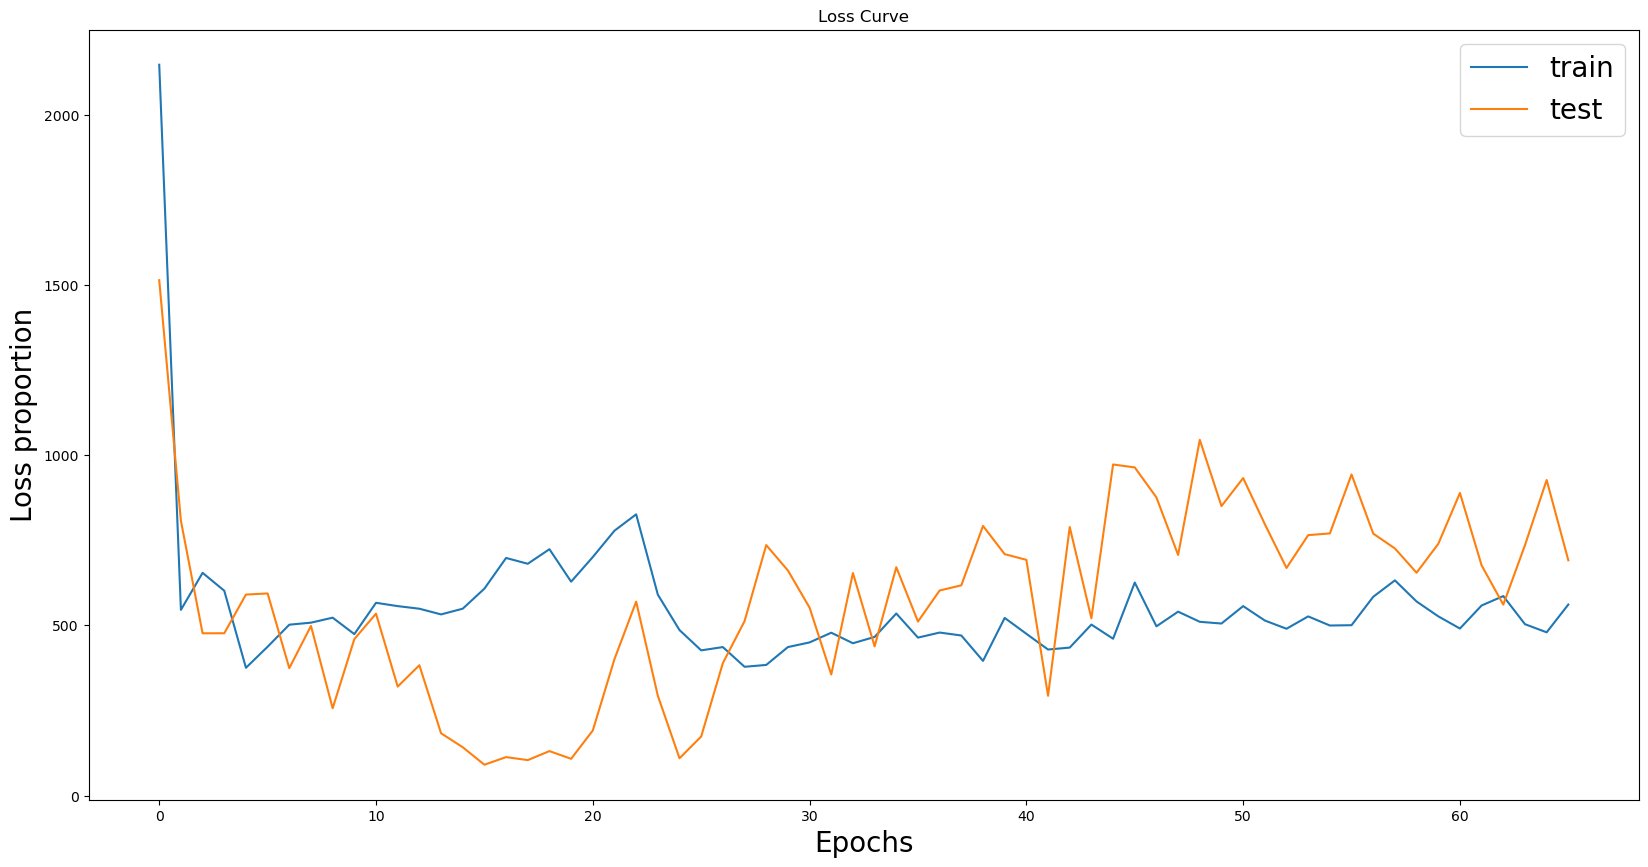

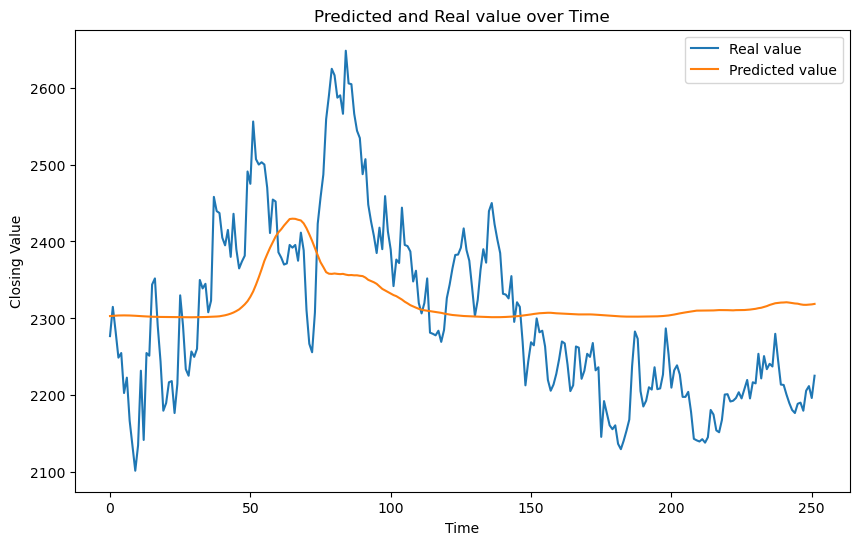

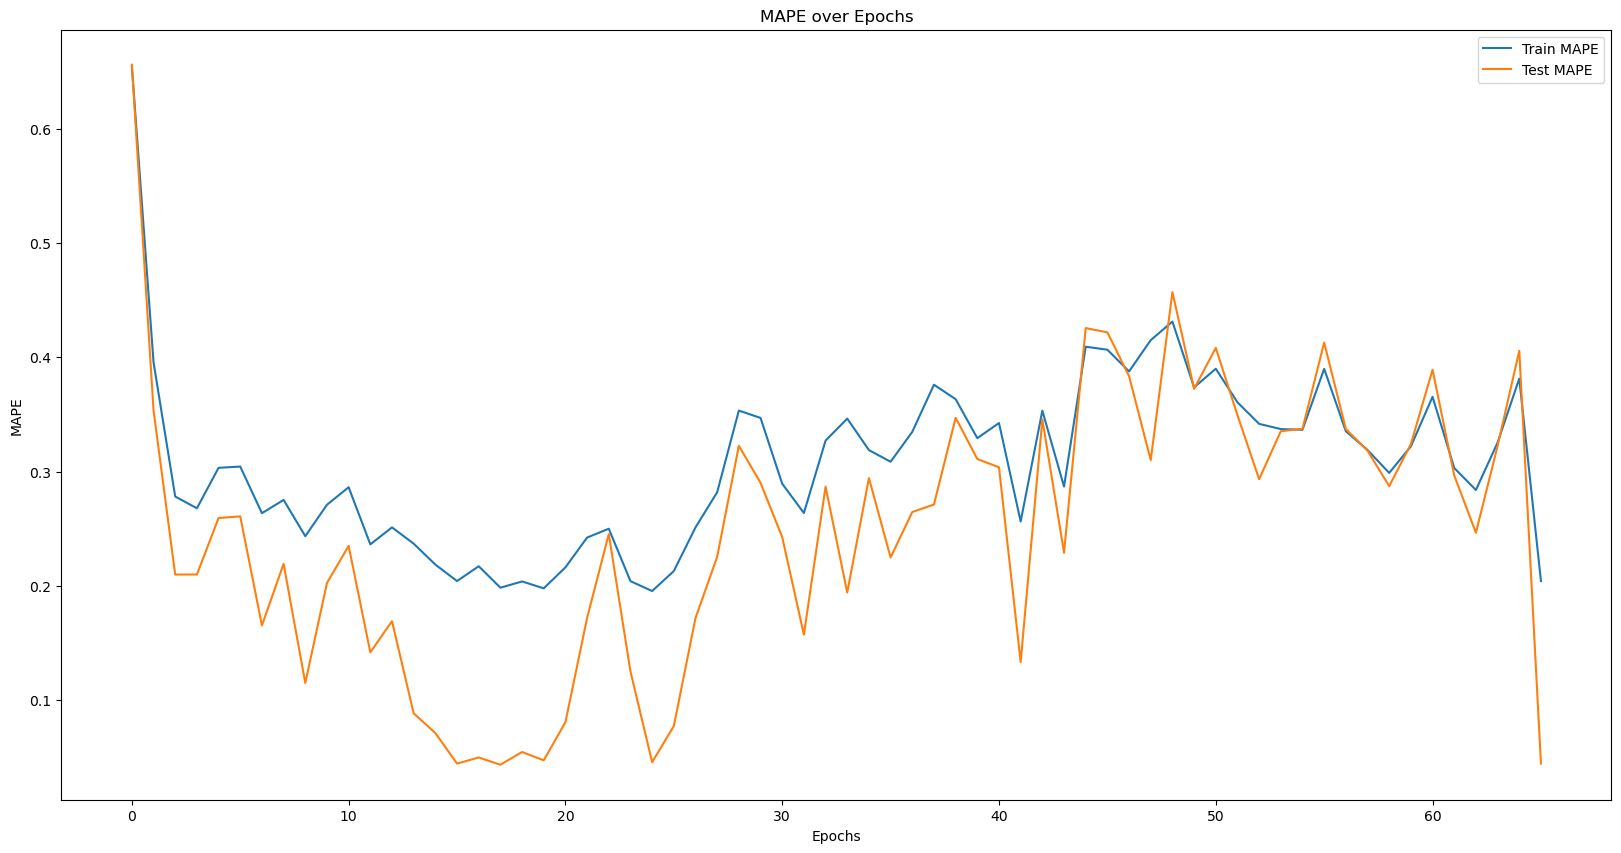

Iteration 15/20:
Lookback Periods: 4, Dropout proportion: 0.3, Epochs: 50, Learning Rate: 0.1
8/8 [==============================] - 0s 533us/step
Restoring model weights from the end of the best epoch: 15.
8/8 [==============================] - 0s 551us/step
Epoch 65: early stopping
8/8 [==============================] - 0s 579us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 587.9501342773438
Last epoch val_loss: 464.1407775878906
Average Test MAPE: 0.22588944853905013


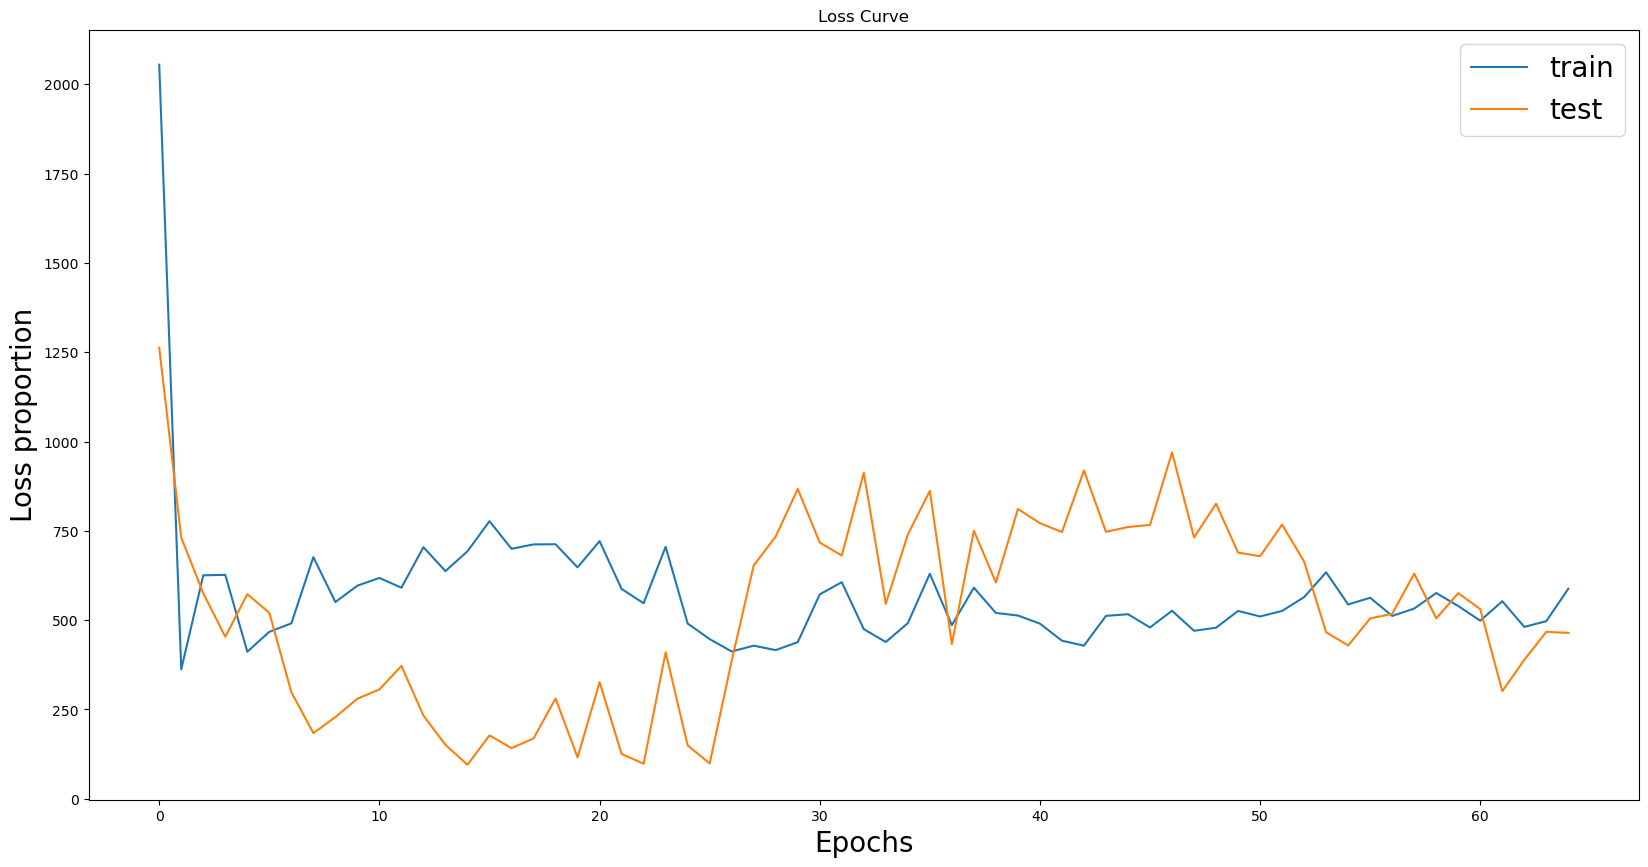

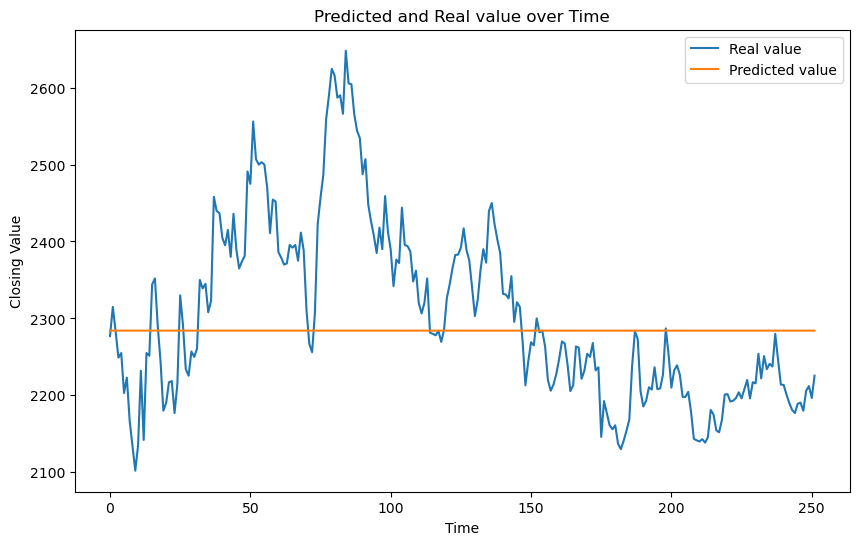

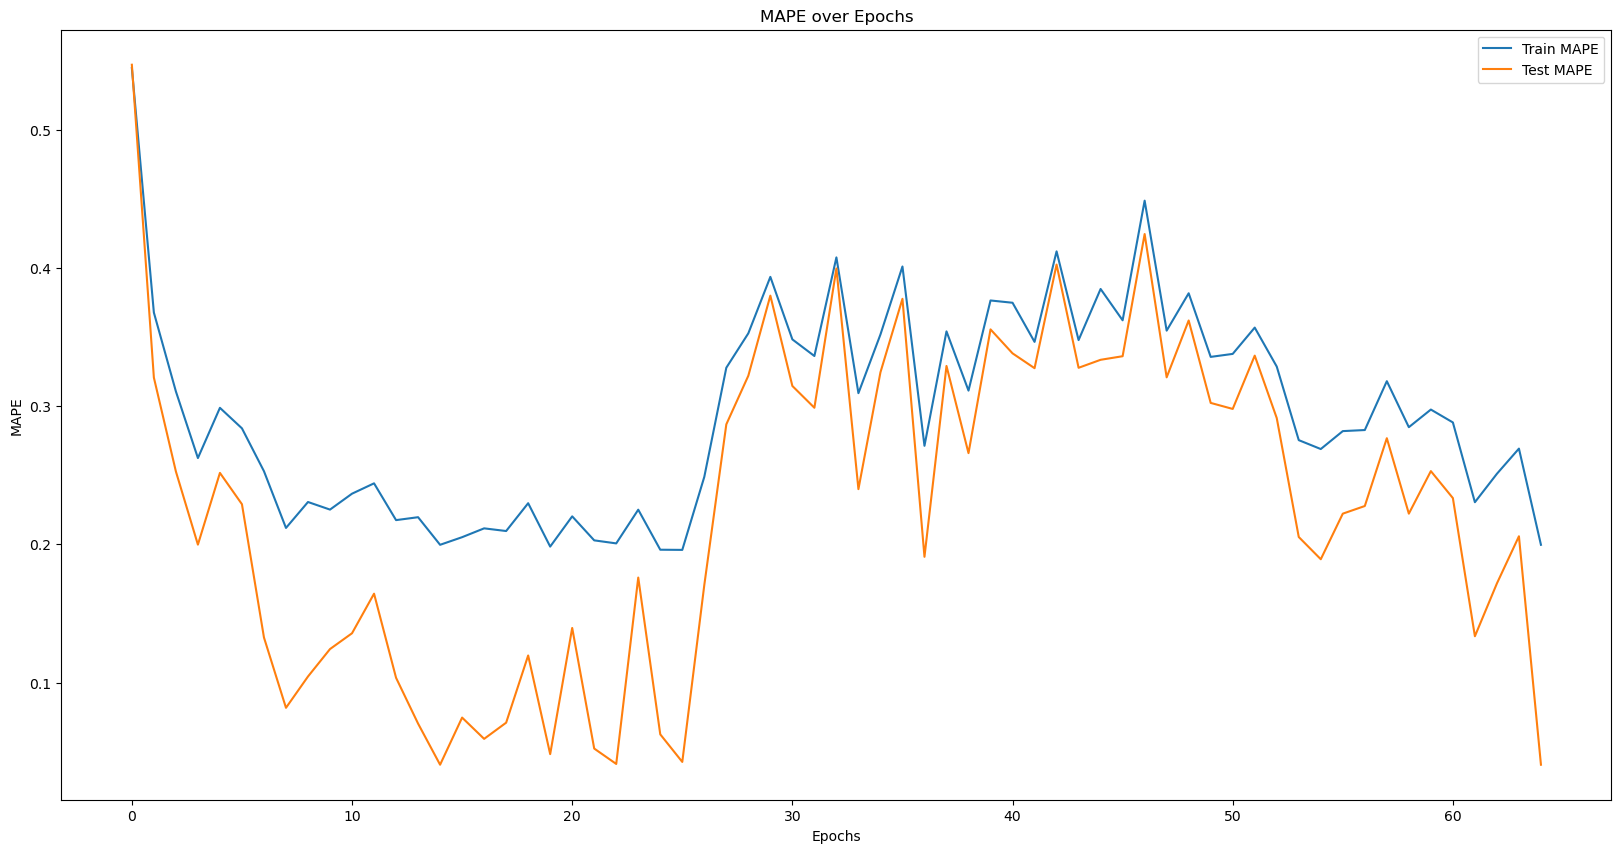

Iteration 16/20:
Lookback Periods: 4, Dropout proportion: 0.2, Epochs: 100, Learning Rate: 0.1
8/8 [==============================] - 0s 536us/step
Restoring model weights from the end of the best epoch: 17.
8/8 [==============================] - 0s 535us/step
Epoch 67: early stopping
8/8 [==============================] - 0s 554us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 486.8785705566406
Last epoch val_loss: 713.9133911132812
Average Test MAPE: 0.21590074120570293


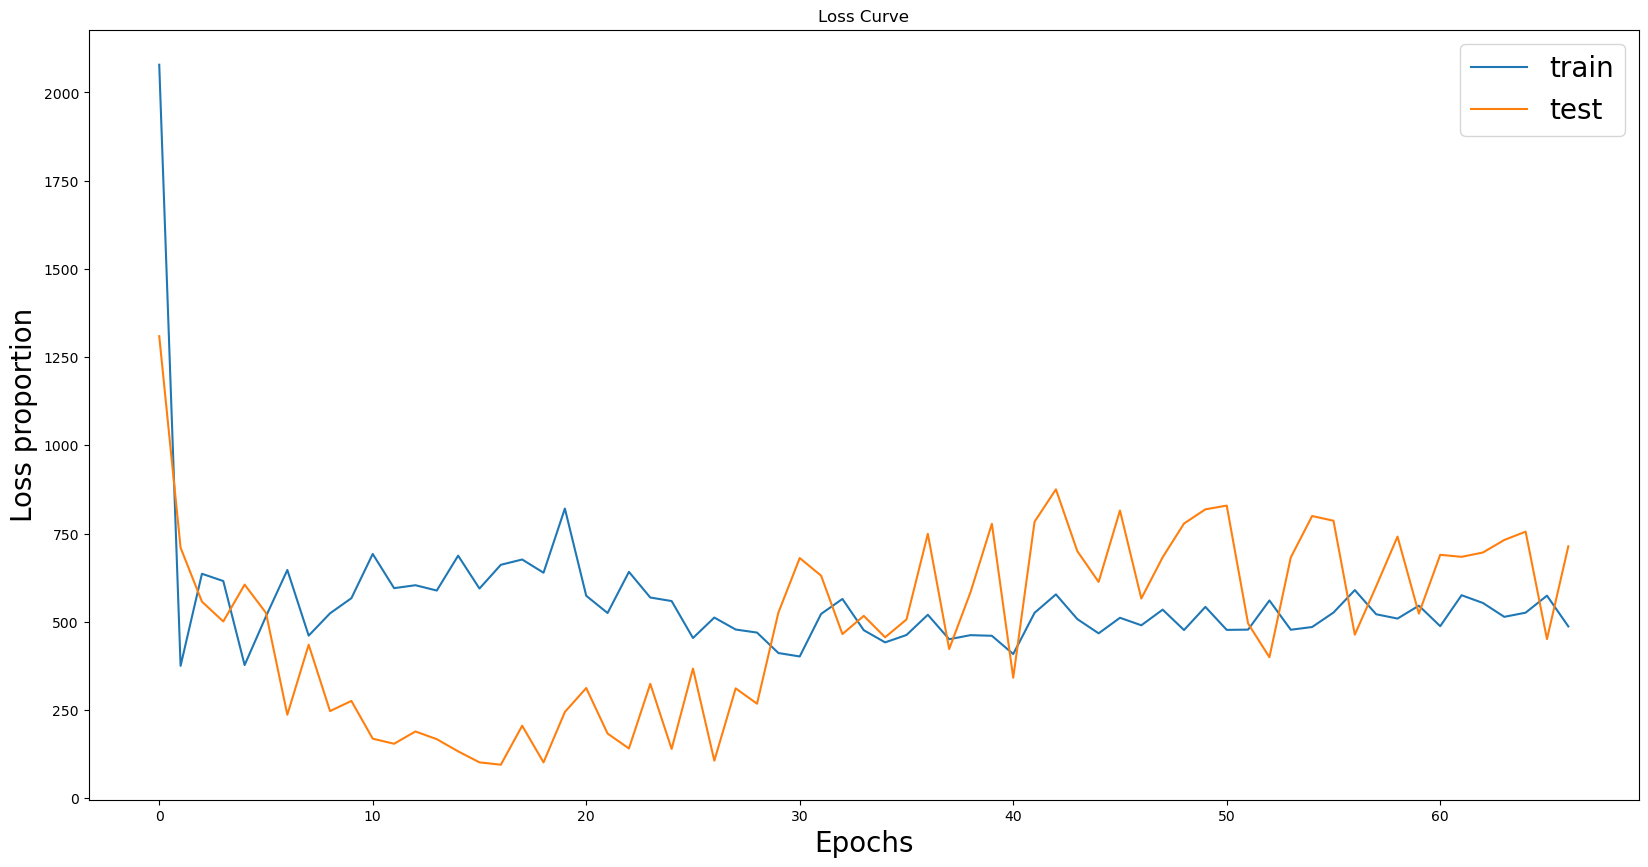

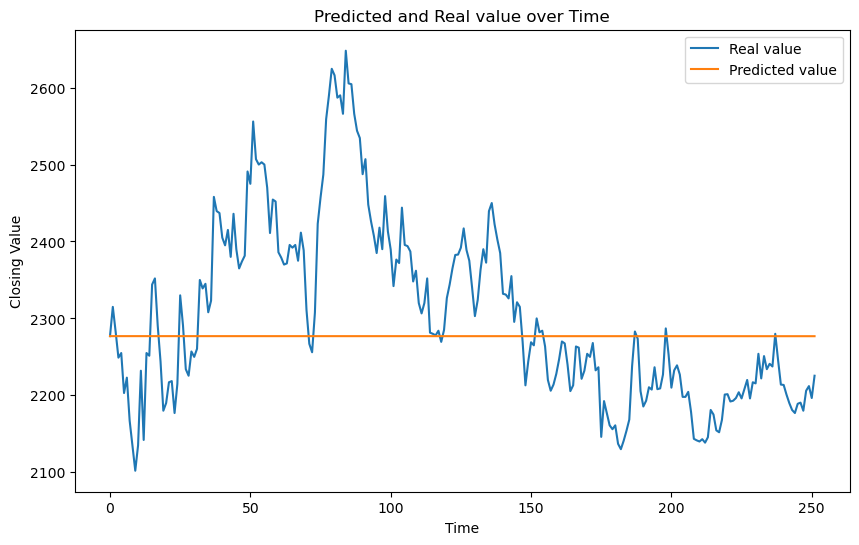

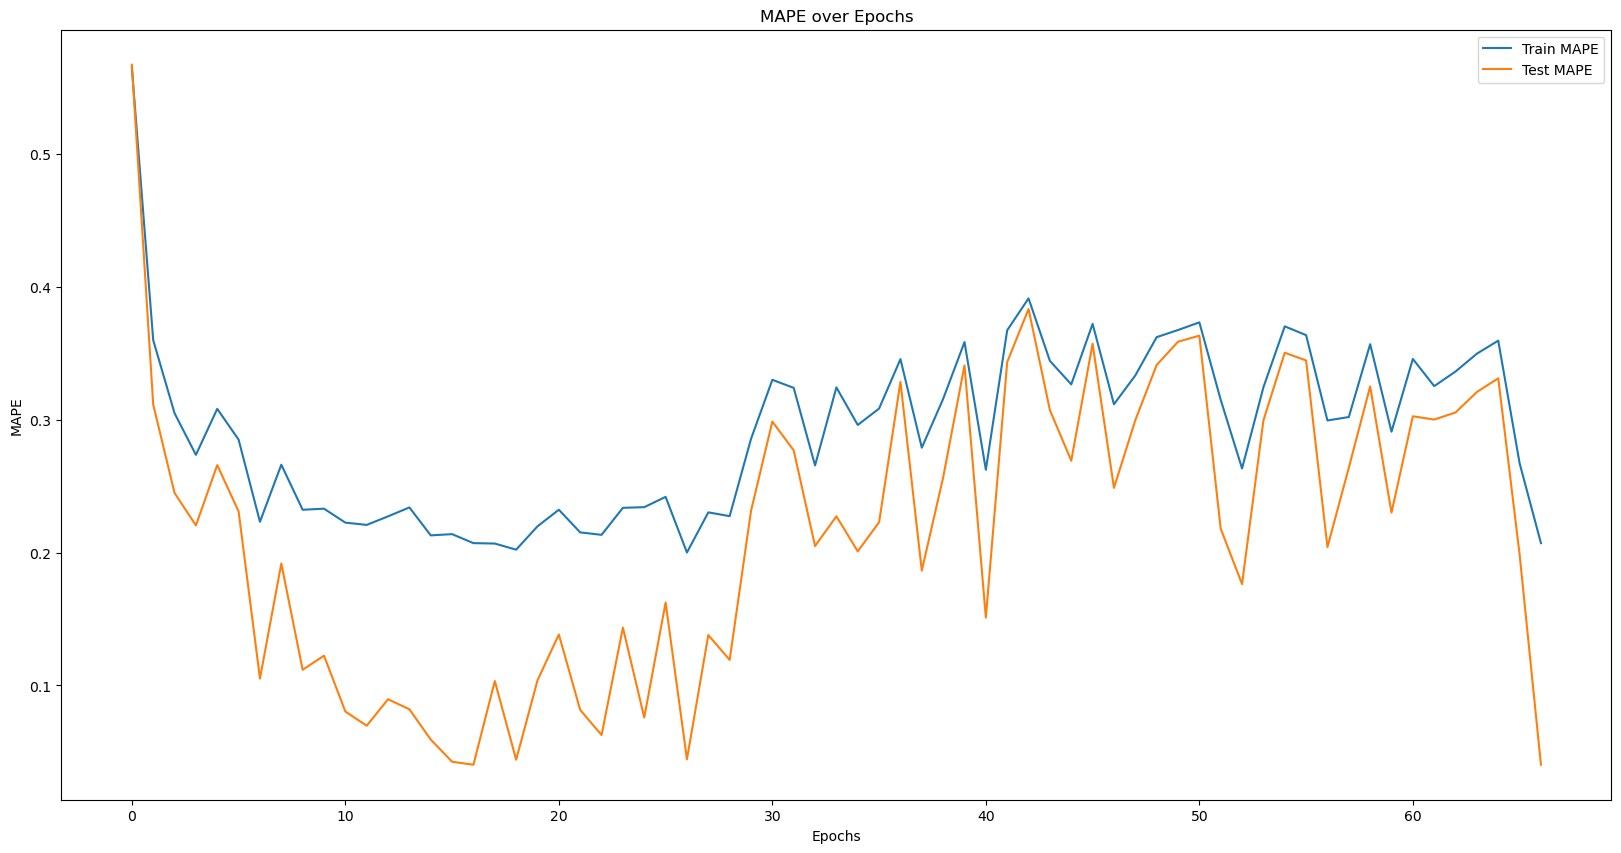

Iteration 17/20:
Lookback Periods: 3, Dropout proportion: 0.4, Epochs: 50, Learning Rate: 0.1
8/8 [==============================] - 0s 529us/step
Restoring model weights from the end of the best epoch: 20.
8/8 [==============================] - 0s 538us/step
Epoch 70: early stopping
8/8 [==============================] - 0s 540us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 488.93353271484375
Last epoch val_loss: 533.7376708984375
Average Test MAPE: 0.22870304501057806


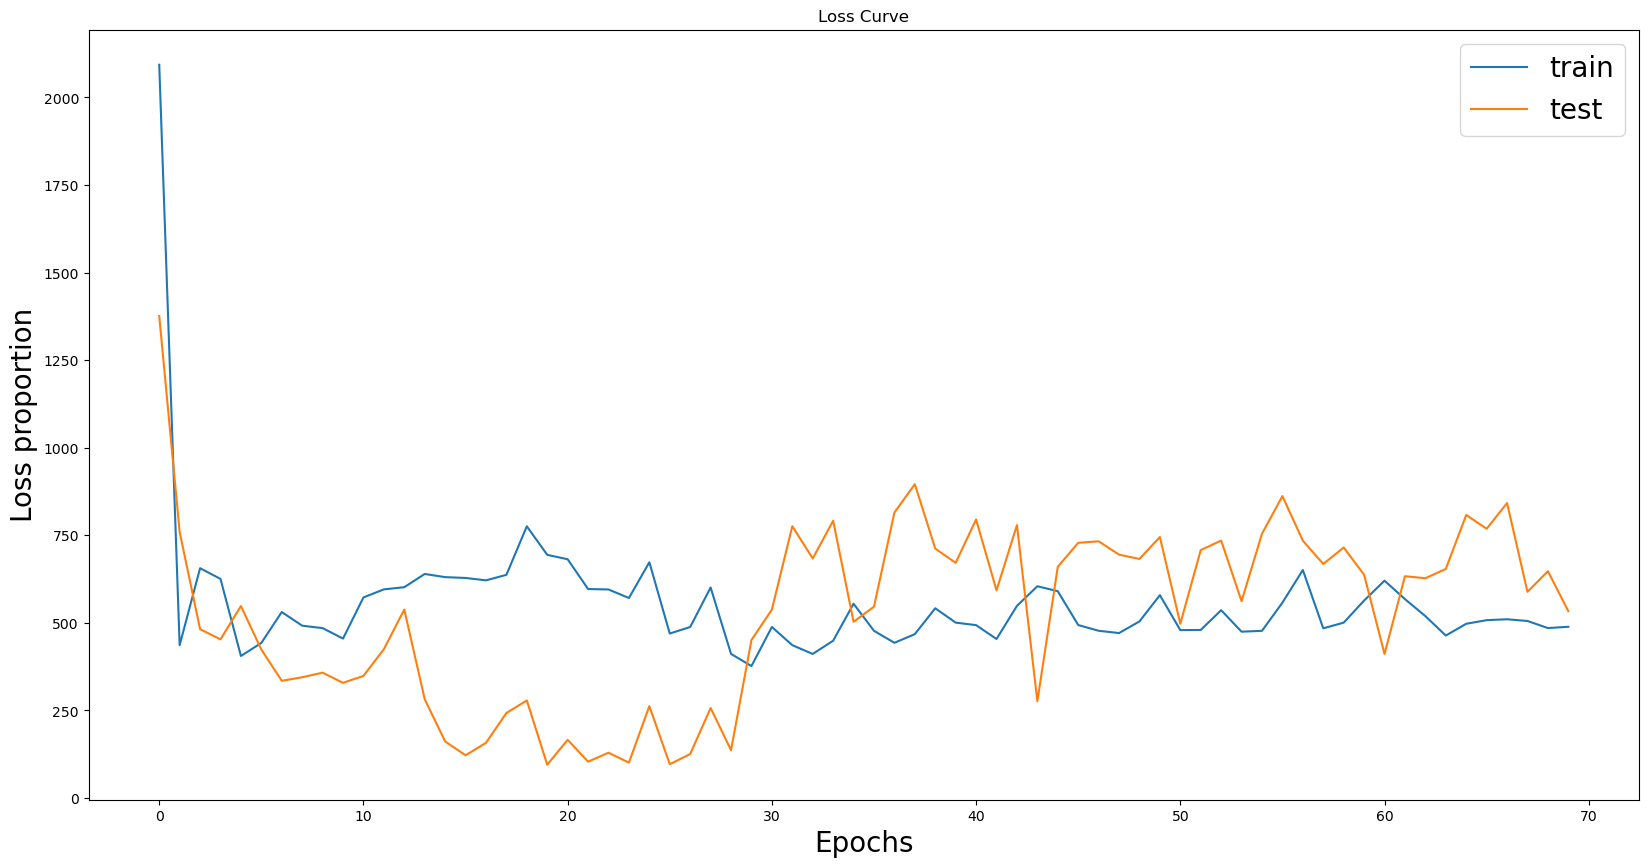

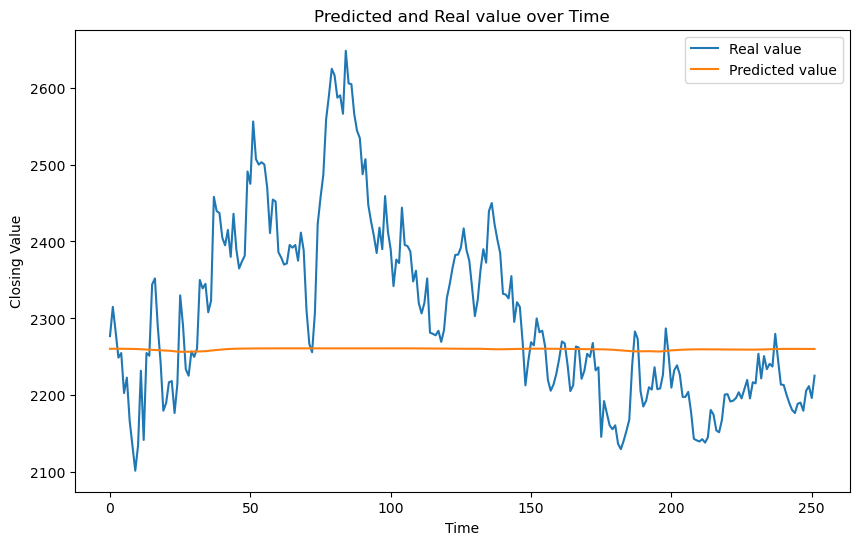

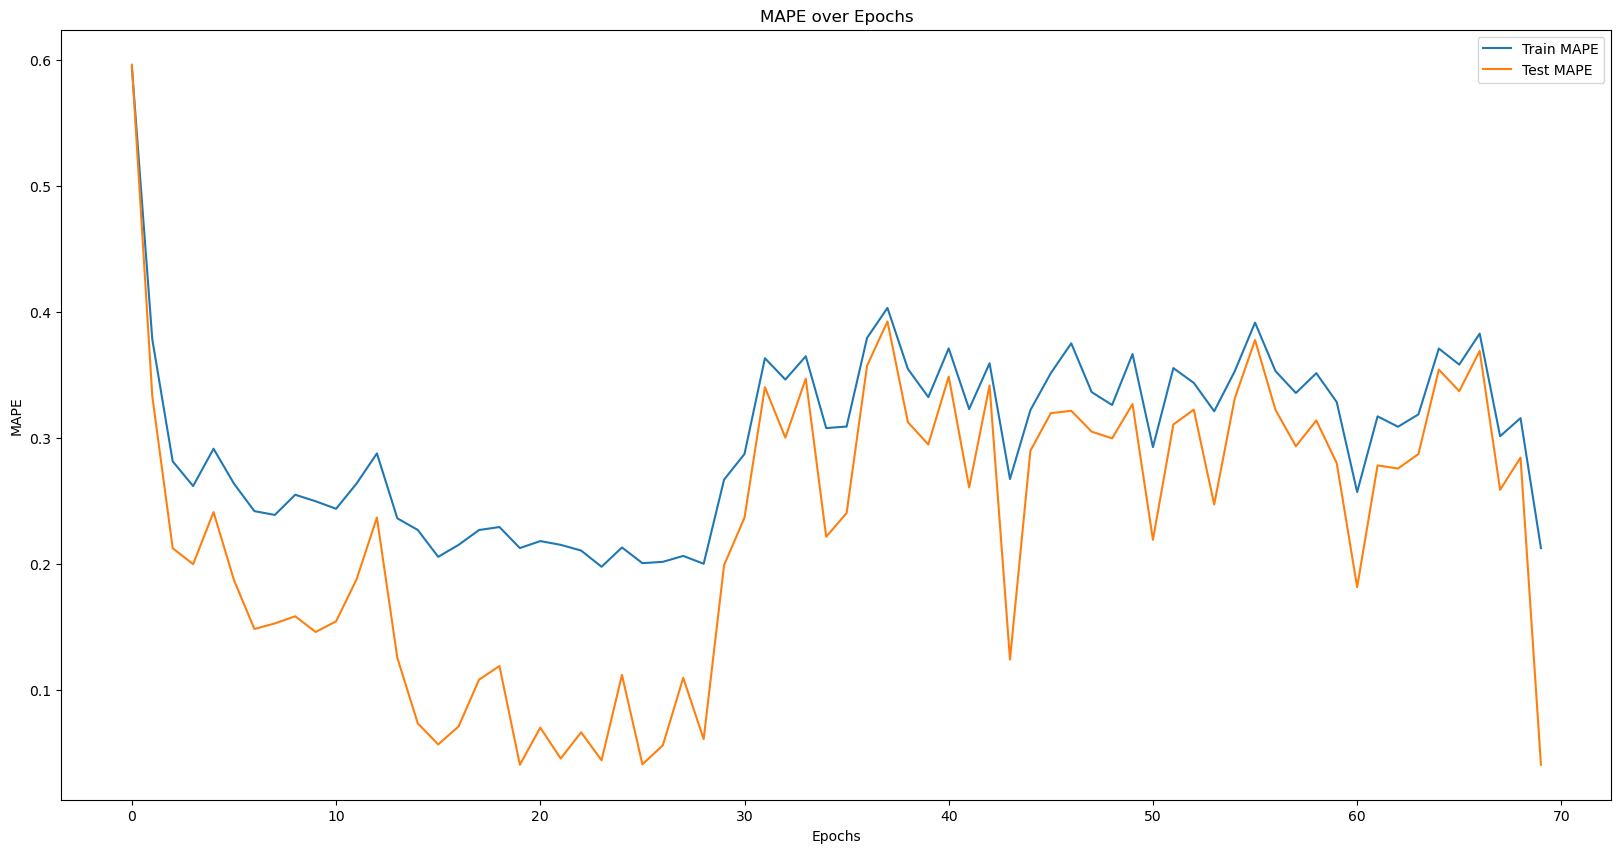

Iteration 18/20:
Lookback Periods: 3, Dropout proportion: 0.2, Epochs: 150, Learning Rate: 0.1
8/8 [==============================] - 0s 524us/step
Restoring model weights from the end of the best epoch: 19.
8/8 [==============================] - 0s 546us/step
Epoch 69: early stopping
8/8 [==============================] - 0s 611us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 447.318359375
Last epoch val_loss: 625.7178344726562
Average Test MAPE: 0.2295826192562712


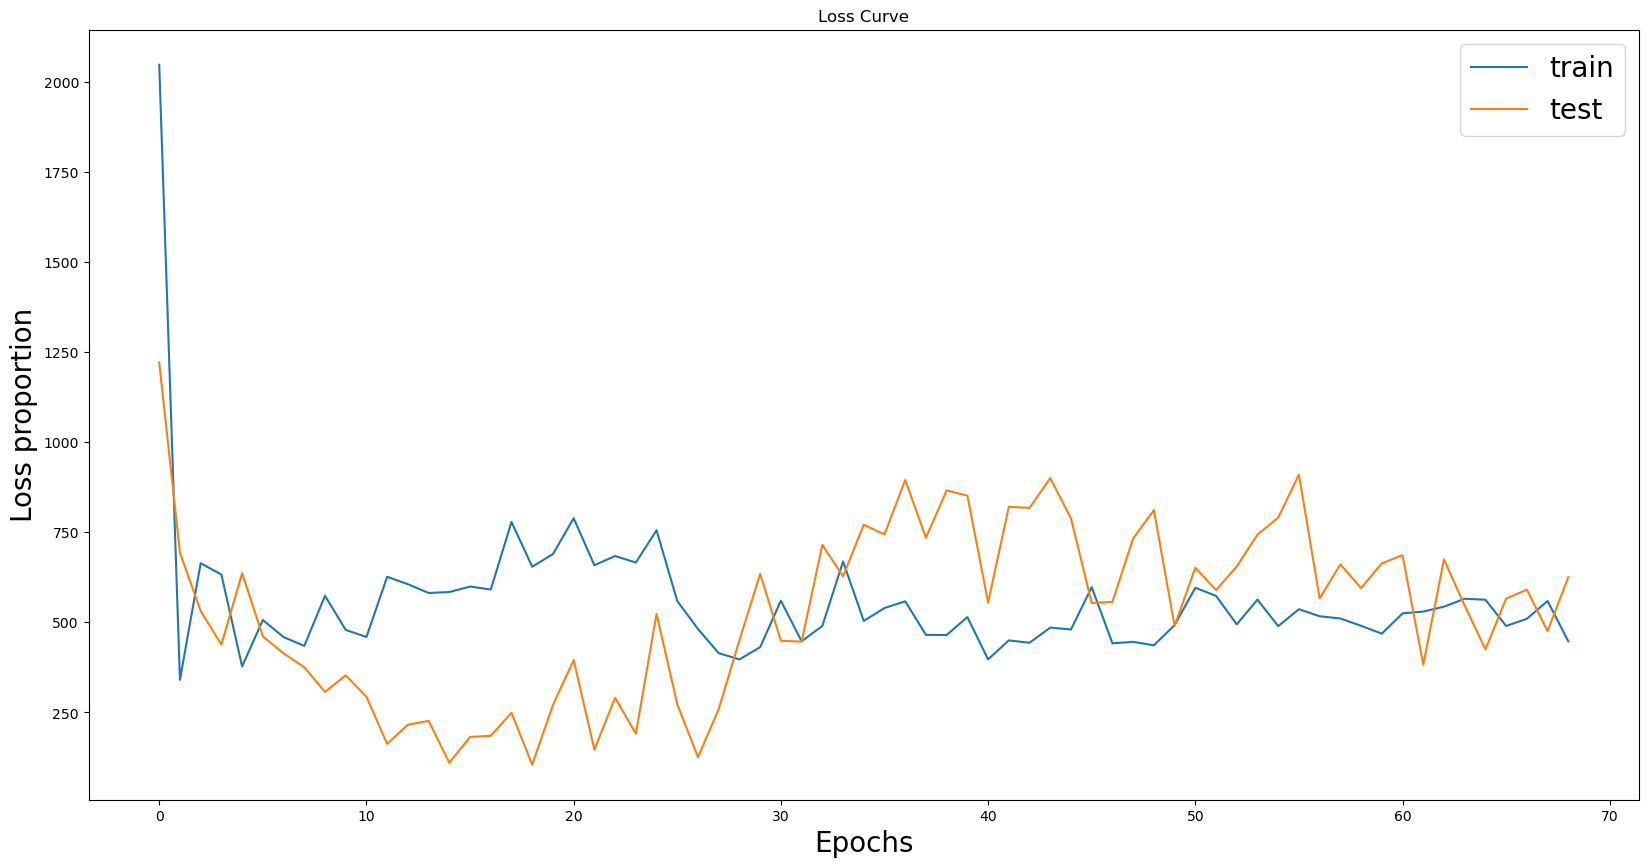

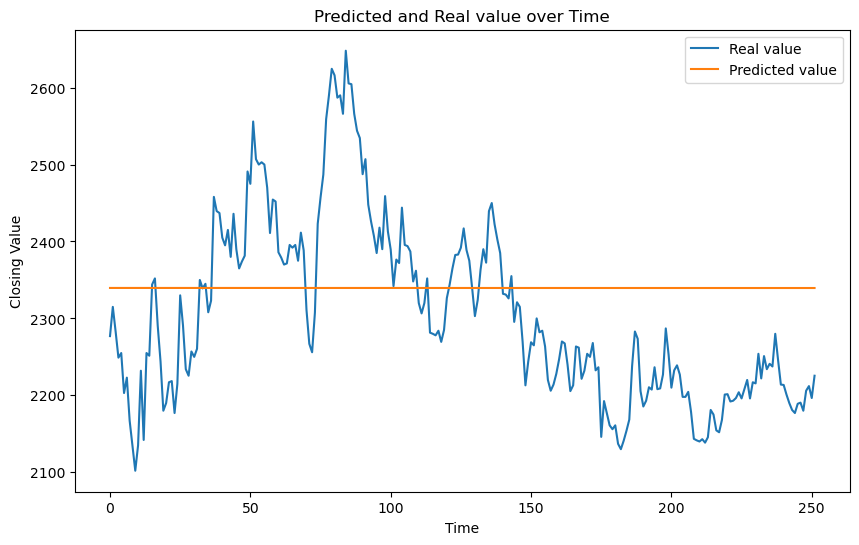

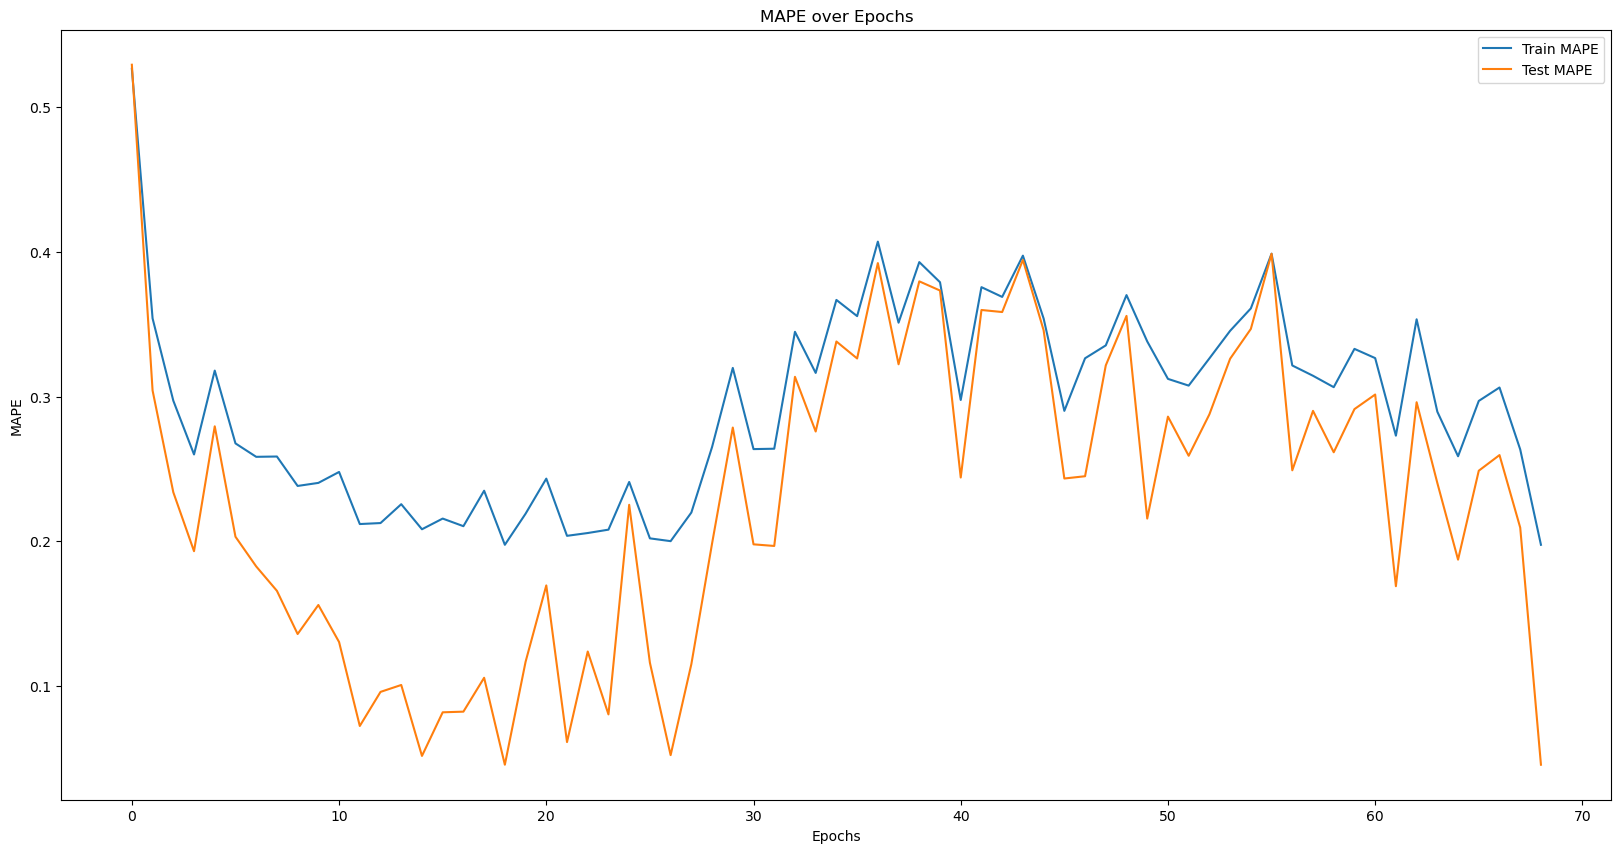

Iteration 19/20:
Lookback Periods: 4, Dropout proportion: 0.3, Epochs: 150, Learning Rate: 0.01
8/8 [==============================] - 0s 538us/step
Restoring model weights from the end of the best epoch: 24.
8/8 [==============================] - 0s 529us/step
Epoch 74: early stopping


8/8 [==============================] - 0s 561us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 500.98870849609375
Last epoch val_loss: 452.4899597167969
Average Test MAPE: 0.24169312104571303


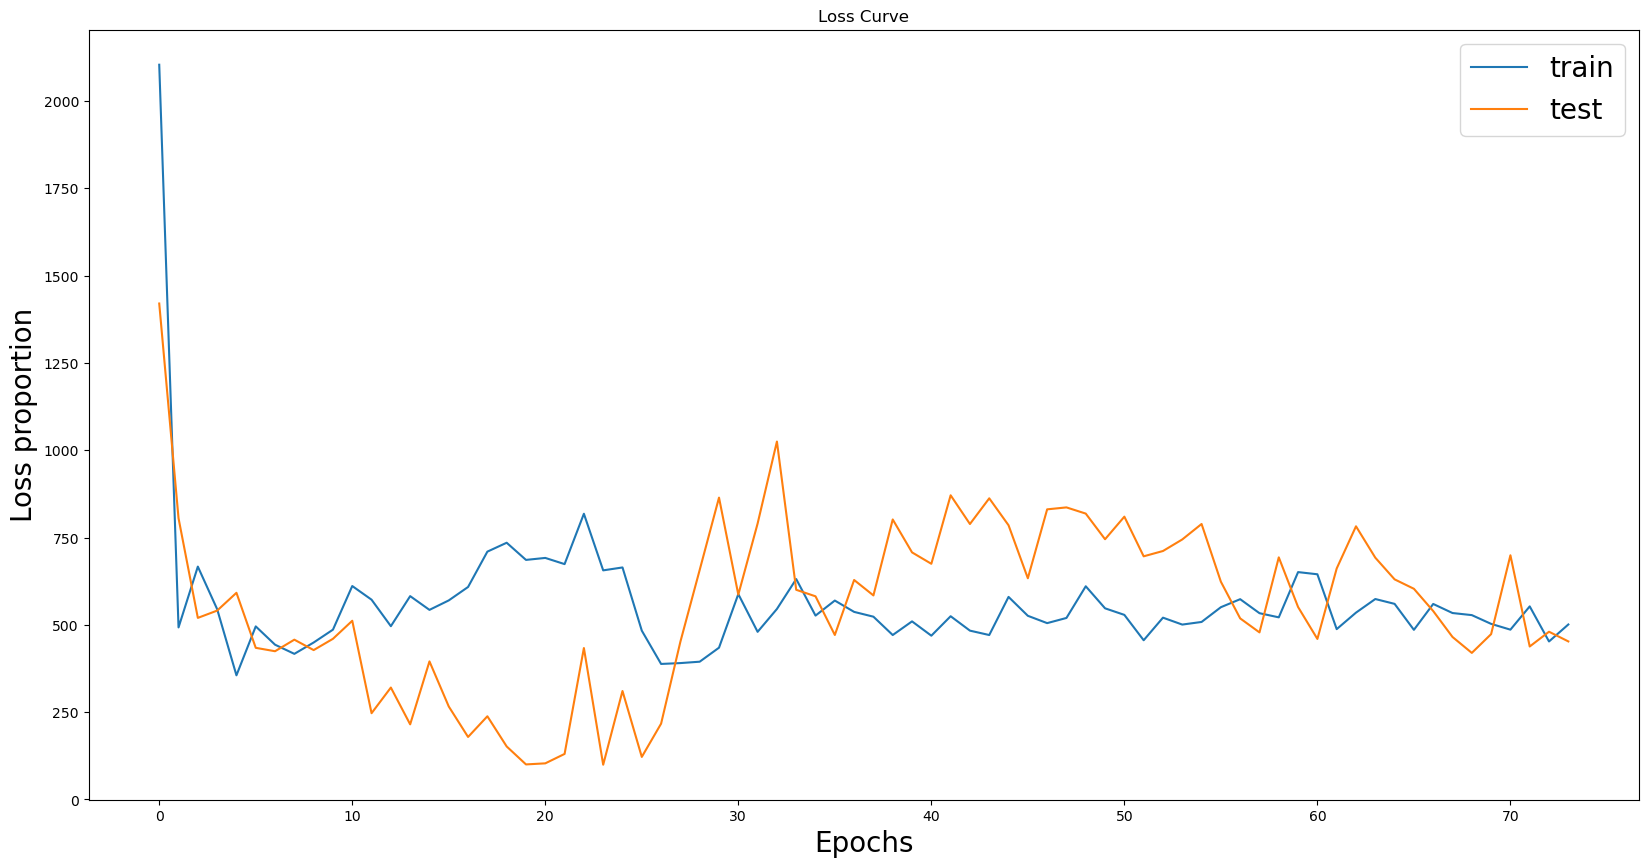

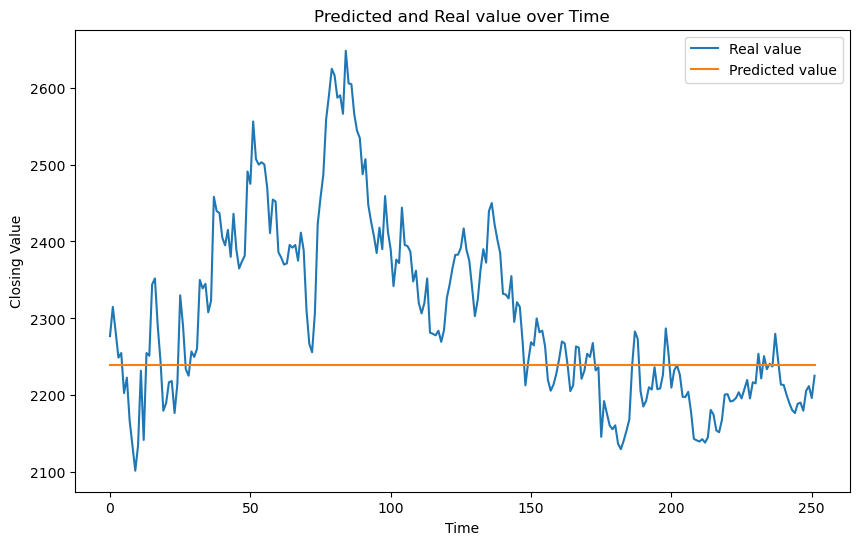

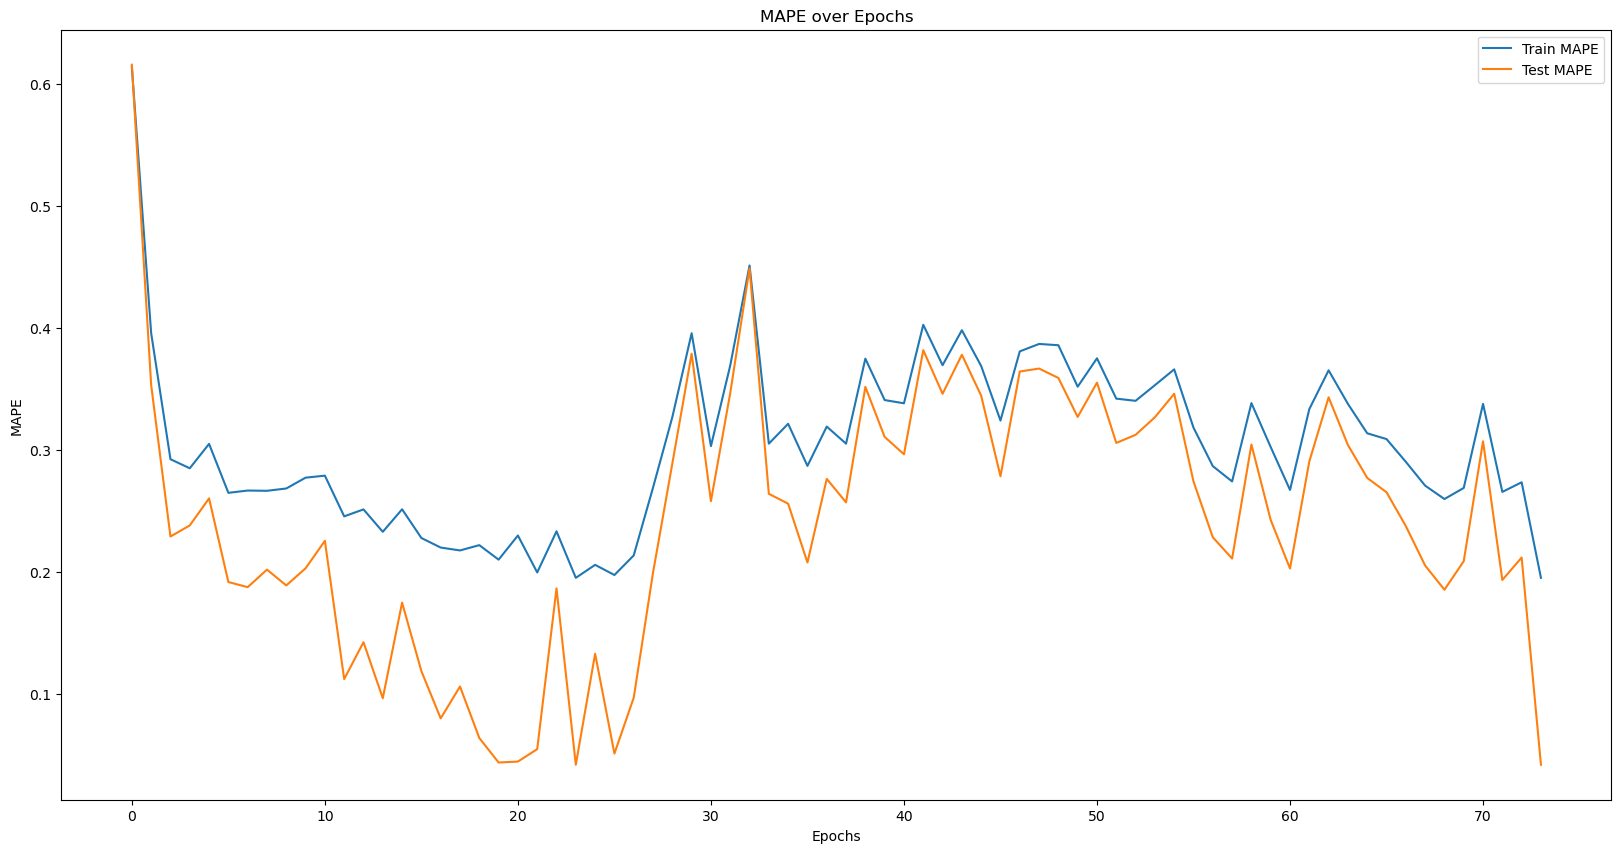

Iteration 20/20:
Lookback Periods: 5, Dropout proportion: 0.2, Epochs: 100, Learning Rate: 0.001
8/8 [==============================] - 0s 508us/step
Restoring model weights from the end of the best epoch: 17.
8/8 [==============================] - 0s 550us/step
Epoch 67: early stopping
8/8 [==============================] - 0s 556us/step
Dataset name: Example Dataset
Lookback window periods: 60
Dropout proportion: 0.5
Last epoch loss: 579.173583984375
Last epoch val_loss: 615.4724731445312
Average Test MAPE: 0.2274021883488677


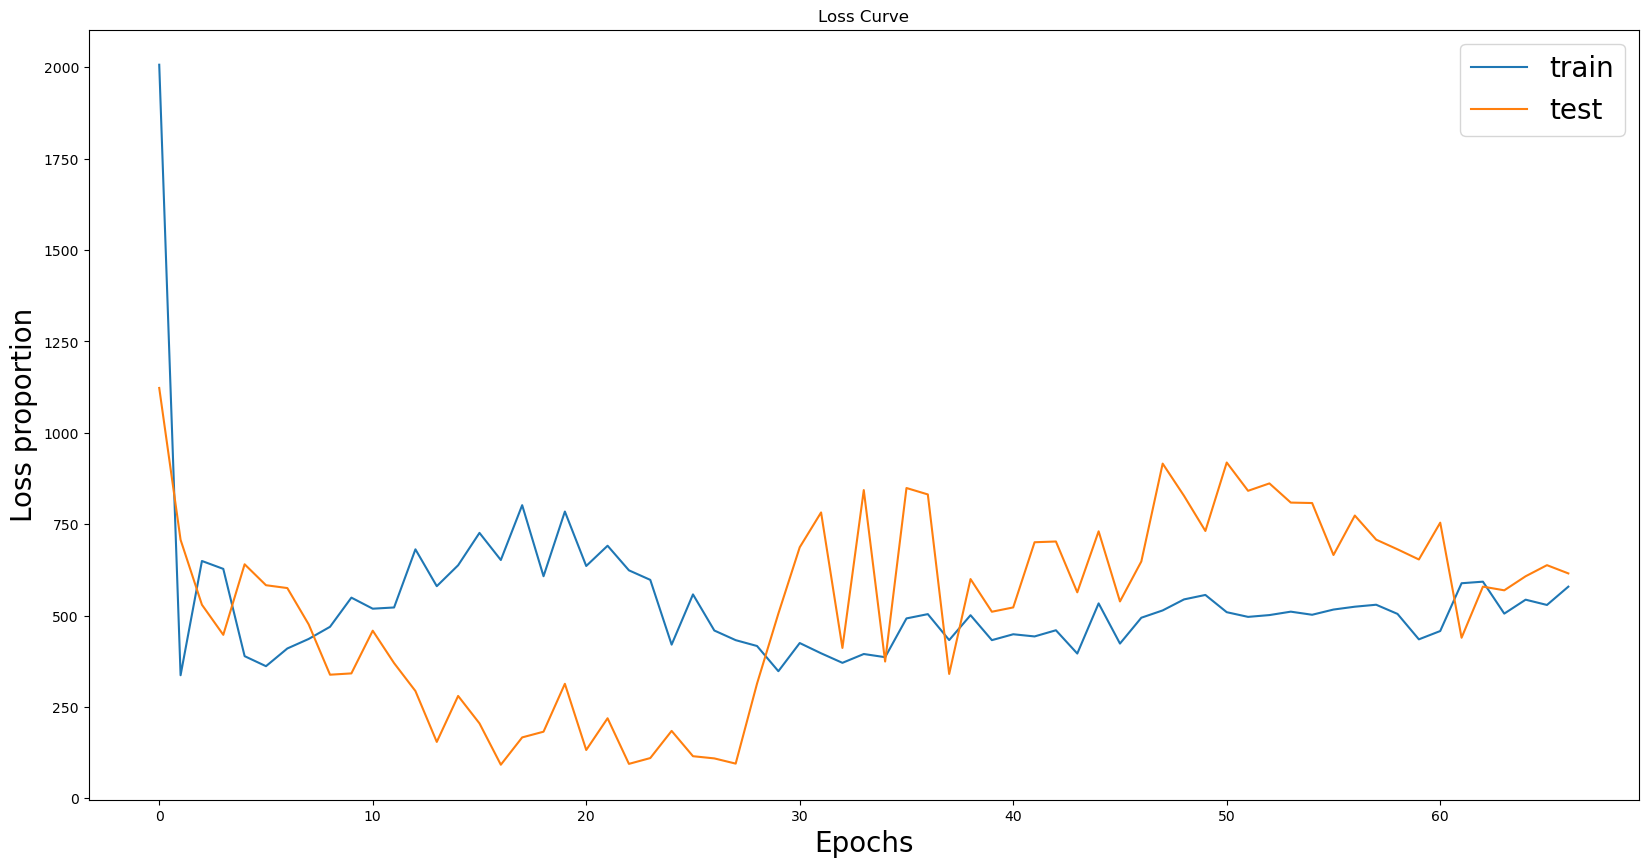

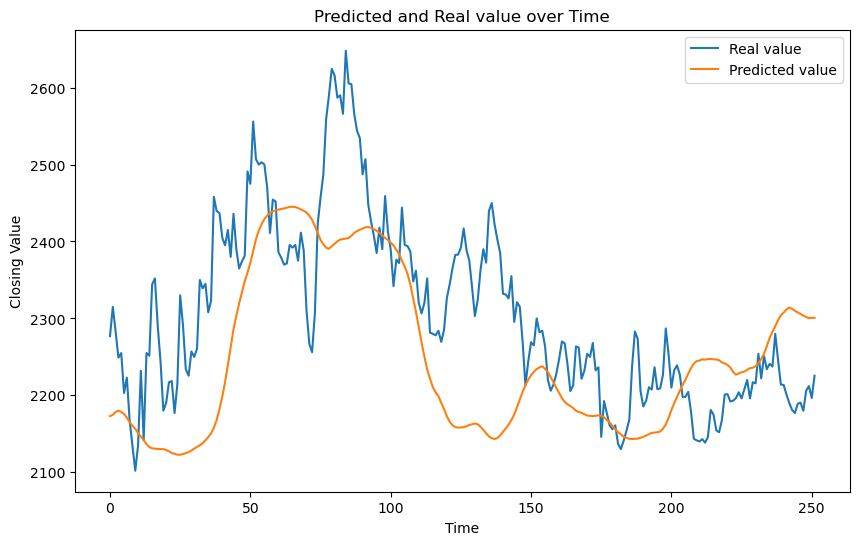

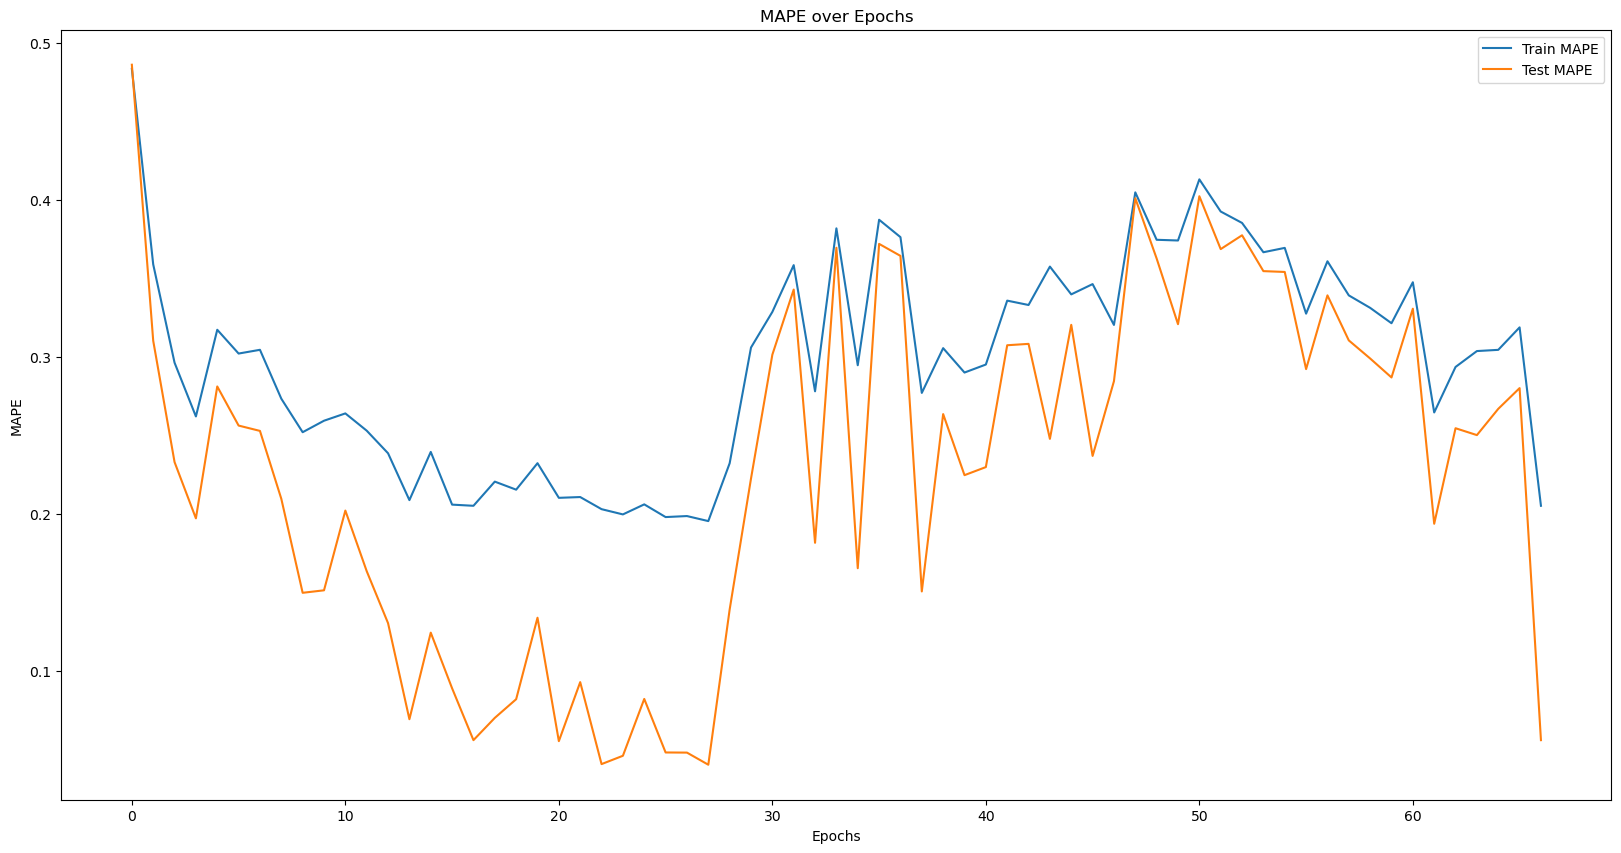

In [140]:
random_search_lstm(x_seq_train, y_train_a, x_seq_test, y_test_a, 
                       hyperparameters, iterations, dataset_name_string)